In [ ]:
import numpy as np
import pandas as pd
import os , cv2 , random , time , shutil , csv
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import scipy
from tensorflow.compat.v1 import ConfigProto,GPUOptions

In [ ]:
np.random.seed(42)
%matplotlib inline
import json
import os
import cv2
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import BatchNormalization, Dense, GlobalAveragePooling2D,Lambda,Dropout,InputLayer,Input
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Data directories
train_path = 'C:/Users/User/Desktop/input/train/'
test_path = 'C:/Users/User/Desktop/input/test/'

In [ ]:
labels_df = pd.read_csv('C:/Users/User/Desktop/input/labels.csv')

labels_df.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

In [ ]:
labels_df.shape

(10222, 2)

In [ ]:
print(f"number of images in training set {len(os.listdir(train_path))}")
print(f"number of images in testing set {len(os.listdir(test_path))}")

number of images in training set 10222
number of images in testing set 10357


In [ ]:
dog_breeds = sorted(list(set(labels_df.breed)))
numClass = len(dog_breeds)
print(numClass)
print(dog_breeds[:10])

120
['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle']


In [ ]:
class_to_num = dict(zip(dog_breeds,range(numClass)))
class_to_num

{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [ ]:
(train_path+labels_df.id+'.jpg')[0]

'C:/Users/Adi/Desktop/input/train/000bec180eb18c7604dcecc8fe0dba07.jpg'

In [ ]:
cv2.imread((train_path+labels_df.id+'.jpg')[0]).shape


(375, 500, 3)

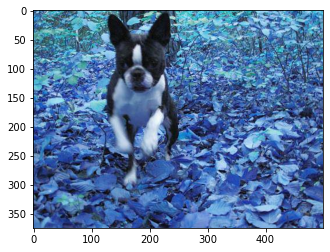

In [ ]:
plt.imshow(cv2.imread((train_path+labels_df.id+'.jpg')[0]))

In [ ]:
labels_df['file_name'] = labels_df['id'].apply(lambda x:train_path+f"{x}.jpg")

In [ ]:
labels_df.head()

id             breed  \
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull   
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo   
2  001cdf01b096e06d78e9e5112d419397          pekinese   
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick   
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever   

                                           file_name  
0  C:/Users/Adi/Desktop/input/train/000bec180eb18...  
1  C:/Users/Adi/Desktop/input/train/001513dfcb2ff...  
2  C:/Users/Adi/Desktop/input/train/001cdf01b096e...  
3  C:/Users/Adi/Desktop/input/train/00214f311d5d2...  
4  C:/Users/Adi/Desktop/input/train/0021f9ceb3235...

In [ ]:
labels_df['breed'] = labels_df.breed.map(class_to_num)

In [ ]:
labels_df.head()

id  breed  \
0  000bec180eb18c7604dcecc8fe0dba07     19   
1  001513dfcb2ffafc82cccf4d8bbaba97     37   
2  001cdf01b096e06d78e9e5112d419397     85   
3  00214f311d5d2247d5dfe4fe24b2303d     15   
4  0021f9ceb3235effd7fcde7f7538ed62     49   

                                           file_name  
0  C:/Users/Adi/Desktop/input/train/000bec180eb18...  
1  C:/Users/Adi/Desktop/input/train/001513dfcb2ff...  
2  C:/Users/Adi/Desktop/input/train/001cdf01b096e...  
3  C:/Users/Adi/Desktop/input/train/00214f311d5d2...  
4  C:/Users/Adi/Desktop/input/train/0021f9ceb3235...

In [ ]:
y = to_categorical(labels_df.breed)

FEATURE EXTRACTION

In [ ]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input as resnet_preprocess
from keras.applications.inception_v3 import InceptionV3,preprocess_input as inception_preprocess
from keras.applications.xception import Xception,preprocess_input as xception_preprocess
#from keras.applications.nasnet import NASNetLarge, preprocess_input as nasnet_preprocess
from keras.layers import concatenate

input_shape = (331,331,3)
input_layer = Input(shape= input_shape)

#inception Resnet
preprocessor_resnet = Lambda(resnet_preprocess)(input_layer)
inception_resnet = InceptionResNetV2(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling = 'avg')(preprocessor_resnet)


#Inception V3
preprocessor_inception = Lambda(inception_preprocess)(input_layer)
inception_v3 = InceptionV3(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling = 'avg')(preprocessor_inception)

preprocessor_xception = Lambda(xception_preprocess)(input_layer)
xception =Xception(weights = 'imagenet',include_top = False,input_shape = input_shape,pooling = 'avg')(preprocessor_xception)

merge = concatenate([inception_v3,inception_resnet,xception])
model = Model(inputs = input_layer,outputs = merge)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 331, 331, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 331, 331, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 331, 331, 3)  0           ['input_1[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 331, 331, 3)  0           ['input_1[0][0]']            

In [ ]:
model.save('feature_extractor.h5')

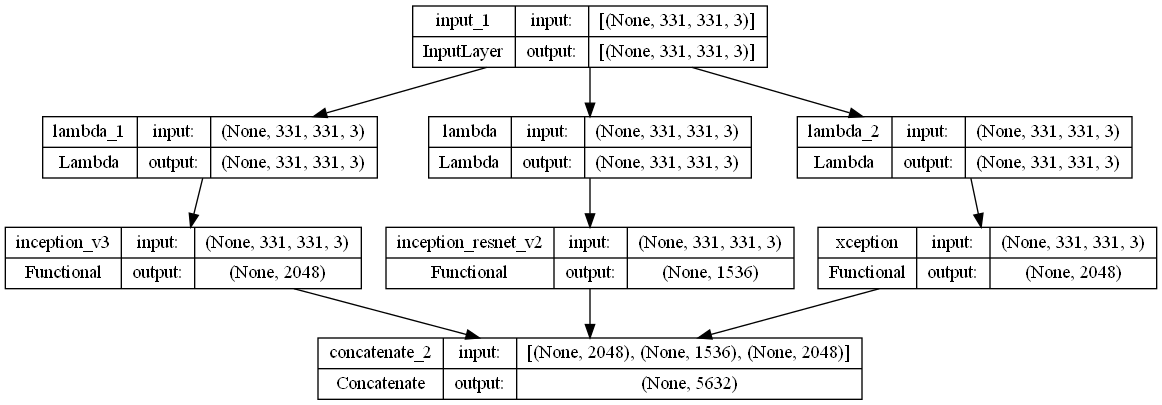

In [ ]:
from keras.utils import plot_model
plot_model(model,show_shapes = True)

In [ ]:
model.output.shape

TensorShape([None, 5632])

In [ ]:
len(model.trainable_weights)

830

In [ ]:
def feature_extractor(df):
    img_size = (331,331,3)
    data_size = len(df)
    batch_size = 10
    X = np.zeros([data_size,5632],dtype=np.uint8)
    # y = np.zeros([data_size,120],dtype = np.uint8)
    datagen = ImageDataGenerator()
    generator = datagen.flow_from_dataframe(df,
                                           x_col='file_name',class_mode=None,
                                           batch_size=10, shuffle=False,target_size=(img_size[:2]),color_mode='rgb')
    i=0
    for input_batch in tqdm(generator):
        input_batch=model.predict(input_batch)
        X[i*batch_size:(i+1)*batch_size]=input_batch
        i+=1
        if i*batch_size >= data_size:
            break;
    return X

In [ ]:
X=feature_extractor(labels_df)

Found 10222 validated image filenames.


  0%|                                                                                         | 0/1023 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


  0%|                                                                               | 1/1023 [00:11<3:18:38, 11.66s/it]

1/1 [==============================] - 0s 150ms/step


  0%|▏                                                                              | 2/1023 [00:11<1:24:48,  4.98s/it]

1/1 [==============================] - 0s 140ms/step


  0%|▏                                                                                | 3/1023 [00:12<48:28,  2.85s/it]

1/1 [==============================] - 0s 142ms/step


  0%|▎                                                                                | 4/1023 [00:12<31:26,  1.85s/it]

1/1 [==============================] - 0s 151ms/step


  0%|▍                                                                                | 5/1023 [00:12<22:14,  1.31s/it]

1/1 [==============================] - 0s 149ms/step


  1%|▍                                                                                | 6/1023 [00:13<16:32,  1.02it/s]

1/1 [==============================] - 0s 142ms/step


  1%|▌                                                                                | 7/1023 [00:13<12:54,  1.31it/s]

1/1 [==============================] - 0s 141ms/step


  1%|▋                                                                                | 8/1023 [00:13<10:29,  1.61it/s]

1/1 [==============================] - 0s 140ms/step


  1%|▋                                                                                | 9/1023 [00:14<08:55,  1.89it/s]

1/1 [==============================] - 0s 148ms/step


  1%|▊                                                                               | 10/1023 [00:14<07:48,  2.16it/s]

1/1 [==============================] - 0s 142ms/step


  1%|▊                                                                               | 11/1023 [00:14<07:03,  2.39it/s]

1/1 [==============================] - 0s 141ms/step


  1%|▉                                                                               | 12/1023 [00:15<06:29,  2.60it/s]

1/1 [==============================] - 0s 141ms/step


  1%|█                                                                               | 13/1023 [00:15<06:10,  2.73it/s]

1/1 [==============================] - 0s 140ms/step


  1%|█                                                                               | 14/1023 [00:15<05:52,  2.86it/s]

1/1 [==============================] - 0s 158ms/step


  1%|█▏                                                                              | 15/1023 [00:16<05:41,  2.95it/s]

1/1 [==============================] - 0s 167ms/step


  2%|█▎                                                                              | 16/1023 [00:16<05:32,  3.03it/s]

1/1 [==============================] - 0s 145ms/step


  2%|█▎                                                                              | 17/1023 [00:16<05:26,  3.08it/s]

1/1 [==============================] - 0s 143ms/step


  2%|█▍                                                                              | 18/1023 [00:17<05:19,  3.14it/s]

1/1 [==============================] - 0s 158ms/step


  2%|█▍                                                                              | 19/1023 [00:17<05:16,  3.17it/s]

1/1 [==============================] - 0s 131ms/step


  2%|█▌                                                                              | 20/1023 [00:17<05:18,  3.15it/s]

1/1 [==============================] - 0s 146ms/step


  2%|█▋                                                                              | 21/1023 [00:18<05:16,  3.17it/s]

1/1 [==============================] - 0s 144ms/step


  2%|█▋                                                                              | 22/1023 [00:18<05:14,  3.18it/s]

1/1 [==============================] - 0s 146ms/step


  2%|█▊                                                                              | 23/1023 [00:18<05:14,  3.18it/s]

1/1 [==============================] - 0s 147ms/step


  2%|█▉                                                                              | 24/1023 [00:18<05:11,  3.21it/s]

1/1 [==============================] - 0s 147ms/step


  2%|█▉                                                                              | 25/1023 [00:19<05:09,  3.22it/s]

1/1 [==============================] - 0s 150ms/step


  3%|██                                                                              | 26/1023 [00:19<05:08,  3.24it/s]

1/1 [==============================] - 0s 143ms/step


  3%|██                                                                              | 27/1023 [00:19<05:07,  3.24it/s]

1/1 [==============================] - 0s 137ms/step


  3%|██▏                                                                             | 28/1023 [00:20<05:07,  3.24it/s]

1/1 [==============================] - 0s 149ms/step


  3%|██▎                                                                             | 29/1023 [00:20<05:05,  3.25it/s]

1/1 [==============================] - 0s 149ms/step


  3%|██▎                                                                             | 30/1023 [00:20<05:06,  3.24it/s]

1/1 [==============================] - 0s 138ms/step


  3%|██▍                                                                             | 31/1023 [00:21<05:03,  3.27it/s]

1/1 [==============================] - 0s 139ms/step


  3%|██▌                                                                             | 32/1023 [00:21<05:01,  3.28it/s]

1/1 [==============================] - 0s 145ms/step


  3%|██▌                                                                             | 33/1023 [00:21<05:05,  3.24it/s]

1/1 [==============================] - 0s 143ms/step


  3%|██▋                                                                             | 34/1023 [00:22<05:05,  3.24it/s]

1/1 [==============================] - 0s 145ms/step


  3%|██▋                                                                             | 35/1023 [00:22<05:04,  3.24it/s]

1/1 [==============================] - 0s 141ms/step


  4%|██▊                                                                             | 36/1023 [00:22<05:10,  3.18it/s]

1/1 [==============================] - 0s 159ms/step


  4%|██▉                                                                             | 37/1023 [00:22<05:08,  3.19it/s]

1/1 [==============================] - 0s 138ms/step


  4%|██▉                                                                             | 38/1023 [00:23<05:10,  3.18it/s]

1/1 [==============================] - 0s 144ms/step


  4%|███                                                                             | 39/1023 [00:23<05:08,  3.19it/s]

1/1 [==============================] - 0s 139ms/step


  4%|███▏                                                                            | 40/1023 [00:23<05:06,  3.20it/s]

1/1 [==============================] - 0s 145ms/step


  4%|███▏                                                                            | 41/1023 [00:24<05:09,  3.17it/s]

1/1 [==============================] - 0s 143ms/step


  4%|███▎                                                                            | 42/1023 [00:24<05:08,  3.18it/s]

1/1 [==============================] - 0s 144ms/step


  4%|███▎                                                                            | 43/1023 [00:24<05:04,  3.22it/s]

1/1 [==============================] - 0s 146ms/step


  4%|███▍                                                                            | 44/1023 [00:25<04:58,  3.28it/s]

1/1 [==============================] - 0s 146ms/step


  4%|███▌                                                                            | 45/1023 [00:25<05:10,  3.15it/s]

1/1 [==============================] - 0s 149ms/step


  4%|███▌                                                                            | 46/1023 [00:25<05:04,  3.21it/s]

1/1 [==============================] - 0s 145ms/step


  5%|███▋                                                                            | 47/1023 [00:26<05:05,  3.19it/s]

1/1 [==============================] - 0s 140ms/step


  5%|███▊                                                                            | 48/1023 [00:26<05:09,  3.15it/s]

1/1 [==============================] - 0s 149ms/step


  5%|███▊                                                                            | 49/1023 [00:26<05:11,  3.13it/s]

1/1 [==============================] - 0s 147ms/step


  5%|███▉                                                                            | 50/1023 [00:27<05:16,  3.07it/s]

1/1 [==============================] - 0s 134ms/step


  5%|███▉                                                                            | 51/1023 [00:27<05:11,  3.12it/s]

1/1 [==============================] - 0s 139ms/step


  5%|████                                                                            | 52/1023 [00:27<05:10,  3.12it/s]

1/1 [==============================] - 0s 141ms/step


  5%|████▏                                                                           | 53/1023 [00:28<05:06,  3.16it/s]

1/1 [==============================] - 0s 160ms/step


  5%|████▏                                                                           | 54/1023 [00:28<05:05,  3.17it/s]

1/1 [==============================] - 0s 149ms/step


  5%|████▎                                                                           | 55/1023 [00:28<05:06,  3.16it/s]

1/1 [==============================] - 0s 150ms/step


  5%|████▍                                                                           | 56/1023 [00:28<05:03,  3.18it/s]

1/1 [==============================] - 0s 158ms/step


  6%|████▍                                                                           | 57/1023 [00:29<05:05,  3.16it/s]

1/1 [==============================] - 0s 146ms/step


  6%|████▌                                                                           | 58/1023 [00:29<05:06,  3.15it/s]

1/1 [==============================] - 0s 147ms/step


  6%|████▌                                                                           | 59/1023 [00:29<05:04,  3.17it/s]

1/1 [==============================] - 0s 142ms/step


  6%|████▋                                                                           | 60/1023 [00:30<05:08,  3.12it/s]

1/1 [==============================] - 0s 153ms/step


  6%|████▊                                                                           | 61/1023 [00:30<05:13,  3.07it/s]

1/1 [==============================] - 0s 153ms/step


  6%|████▊                                                                           | 62/1023 [00:30<05:16,  3.04it/s]

1/1 [==============================] - 0s 159ms/step


  6%|████▉                                                                           | 63/1023 [00:31<05:15,  3.04it/s]

1/1 [==============================] - 0s 158ms/step


  6%|█████                                                                           | 64/1023 [00:31<05:17,  3.02it/s]

1/1 [==============================] - 0s 146ms/step


  6%|█████                                                                           | 65/1023 [00:31<05:15,  3.04it/s]

1/1 [==============================] - 0s 148ms/step


  6%|█████▏                                                                          | 66/1023 [00:32<05:15,  3.03it/s]

1/1 [==============================] - 0s 153ms/step


  7%|█████▏                                                                          | 67/1023 [00:32<05:12,  3.06it/s]

1/1 [==============================] - 0s 145ms/step


  7%|█████▎                                                                          | 68/1023 [00:32<05:11,  3.06it/s]

1/1 [==============================] - 0s 149ms/step


  7%|█████▍                                                                          | 69/1023 [00:33<05:15,  3.02it/s]

1/1 [==============================] - 0s 141ms/step


  7%|█████▍                                                                          | 70/1023 [00:33<05:08,  3.09it/s]

1/1 [==============================] - 0s 144ms/step


  7%|█████▌                                                                          | 71/1023 [00:33<05:06,  3.11it/s]

1/1 [==============================] - 0s 144ms/step


  7%|█████▋                                                                          | 72/1023 [00:34<05:00,  3.17it/s]

1/1 [==============================] - 0s 139ms/step


  7%|█████▋                                                                          | 73/1023 [00:34<04:53,  3.23it/s]

1/1 [==============================] - 0s 142ms/step


  7%|█████▊                                                                          | 74/1023 [00:34<04:52,  3.24it/s]

1/1 [==============================] - 0s 150ms/step


  7%|█████▊                                                                          | 75/1023 [00:35<04:56,  3.20it/s]

1/1 [==============================] - 0s 144ms/step


  7%|█████▉                                                                          | 76/1023 [00:35<04:51,  3.24it/s]

1/1 [==============================] - 0s 159ms/step


  8%|██████                                                                          | 77/1023 [00:35<04:52,  3.24it/s]

1/1 [==============================] - 0s 133ms/step


  8%|██████                                                                          | 78/1023 [00:35<04:56,  3.19it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▏                                                                         | 79/1023 [00:36<04:55,  3.20it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▎                                                                         | 80/1023 [00:36<04:53,  3.21it/s]

1/1 [==============================] - 0s 146ms/step


  8%|██████▎                                                                         | 81/1023 [00:36<04:51,  3.24it/s]

1/1 [==============================] - 0s 143ms/step


  8%|██████▍                                                                         | 82/1023 [00:37<04:50,  3.24it/s]

1/1 [==============================] - 0s 141ms/step


  8%|██████▍                                                                         | 83/1023 [00:37<04:47,  3.26it/s]

1/1 [==============================] - 0s 140ms/step


  8%|██████▌                                                                         | 84/1023 [00:37<04:50,  3.23it/s]

1/1 [==============================] - 0s 142ms/step


  8%|██████▋                                                                         | 85/1023 [00:38<04:49,  3.24it/s]

1/1 [==============================] - 0s 142ms/step


  8%|██████▋                                                                         | 86/1023 [00:38<04:49,  3.24it/s]

1/1 [==============================] - 0s 142ms/step


  9%|██████▊                                                                         | 87/1023 [00:38<04:48,  3.24it/s]

1/1 [==============================] - 0s 152ms/step


  9%|██████▉                                                                         | 88/1023 [00:39<04:45,  3.28it/s]

1/1 [==============================] - 0s 141ms/step


  9%|██████▉                                                                         | 89/1023 [00:39<04:46,  3.26it/s]

1/1 [==============================] - 0s 143ms/step


  9%|███████                                                                         | 90/1023 [00:39<04:49,  3.22it/s]

1/1 [==============================] - 0s 138ms/step


  9%|███████                                                                         | 91/1023 [00:40<04:48,  3.23it/s]

1/1 [==============================] - 0s 146ms/step


  9%|███████▏                                                                        | 92/1023 [00:40<04:45,  3.26it/s]

1/1 [==============================] - 0s 136ms/step


  9%|███████▎                                                                        | 93/1023 [00:40<04:43,  3.28it/s]

1/1 [==============================] - 0s 140ms/step


  9%|███████▎                                                                        | 94/1023 [00:40<04:41,  3.30it/s]

1/1 [==============================] - 0s 145ms/step


  9%|███████▍                                                                        | 95/1023 [00:41<04:42,  3.29it/s]

1/1 [==============================] - 0s 142ms/step


  9%|███████▌                                                                        | 96/1023 [00:41<04:42,  3.29it/s]

1/1 [==============================] - 0s 142ms/step


  9%|███████▌                                                                        | 97/1023 [00:41<04:40,  3.30it/s]

1/1 [==============================] - 0s 142ms/step


 10%|███████▋                                                                        | 98/1023 [00:42<04:41,  3.28it/s]

1/1 [==============================] - 0s 136ms/step


 10%|███████▋                                                                        | 99/1023 [00:42<04:41,  3.28it/s]

1/1 [==============================] - 0s 145ms/step


 10%|███████▋                                                                       | 100/1023 [00:42<04:43,  3.26it/s]

1/1 [==============================] - 0s 142ms/step


 10%|███████▊                                                                       | 101/1023 [00:43<04:40,  3.29it/s]

1/1 [==============================] - 0s 142ms/step


 10%|███████▉                                                                       | 102/1023 [00:43<04:45,  3.23it/s]

1/1 [==============================] - 0s 147ms/step


 10%|███████▉                                                                       | 103/1023 [00:43<04:45,  3.22it/s]

1/1 [==============================] - 0s 157ms/step


 10%|████████                                                                       | 104/1023 [00:43<04:41,  3.26it/s]

1/1 [==============================] - 0s 147ms/step


 10%|████████                                                                       | 105/1023 [00:44<04:42,  3.25it/s]

1/1 [==============================] - 0s 142ms/step


 10%|████████▏                                                                      | 106/1023 [00:44<04:46,  3.20it/s]

1/1 [==============================] - 0s 158ms/step


 10%|████████▎                                                                      | 107/1023 [00:44<04:48,  3.18it/s]

1/1 [==============================] - 0s 145ms/step


 11%|████████▎                                                                      | 108/1023 [00:45<04:46,  3.20it/s]

1/1 [==============================] - 0s 144ms/step


 11%|████████▍                                                                      | 109/1023 [00:45<04:49,  3.15it/s]

1/1 [==============================] - 0s 144ms/step


 11%|████████▍                                                                      | 110/1023 [00:45<04:51,  3.13it/s]

1/1 [==============================] - 0s 141ms/step


 11%|████████▌                                                                      | 111/1023 [00:46<04:53,  3.11it/s]

1/1 [==============================] - 0s 162ms/step


 11%|████████▋                                                                      | 112/1023 [00:46<05:02,  3.01it/s]

1/1 [==============================] - 0s 158ms/step


 11%|████████▋                                                                      | 113/1023 [00:46<04:54,  3.09it/s]

1/1 [==============================] - 0s 142ms/step


 11%|████████▊                                                                      | 114/1023 [00:47<04:53,  3.10it/s]

1/1 [==============================] - 0s 158ms/step


 11%|████████▉                                                                      | 115/1023 [00:47<04:52,  3.11it/s]

1/1 [==============================] - 0s 141ms/step


 11%|████████▉                                                                      | 116/1023 [00:47<04:50,  3.12it/s]

1/1 [==============================] - 0s 154ms/step


 11%|█████████                                                                      | 117/1023 [00:48<04:49,  3.13it/s]

1/1 [==============================] - 0s 157ms/step


 12%|█████████                                                                      | 118/1023 [00:48<04:45,  3.17it/s]

1/1 [==============================] - 0s 145ms/step


 12%|█████████▏                                                                     | 119/1023 [00:48<04:48,  3.13it/s]

1/1 [==============================] - 0s 157ms/step


 12%|█████████▎                                                                     | 120/1023 [00:49<04:47,  3.14it/s]

1/1 [==============================] - 0s 142ms/step


 12%|█████████▎                                                                     | 121/1023 [00:49<04:47,  3.14it/s]

1/1 [==============================] - 0s 136ms/step


 12%|█████████▍                                                                     | 122/1023 [00:49<04:42,  3.19it/s]

1/1 [==============================] - 0s 160ms/step


 12%|█████████▍                                                                     | 123/1023 [00:50<04:43,  3.17it/s]

1/1 [==============================] - 0s 147ms/step


 12%|█████████▌                                                                     | 124/1023 [00:50<04:43,  3.17it/s]

1/1 [==============================] - 0s 140ms/step


 12%|█████████▋                                                                     | 125/1023 [00:50<04:40,  3.20it/s]

1/1 [==============================] - 0s 141ms/step


 12%|█████████▋                                                                     | 126/1023 [00:50<04:39,  3.21it/s]

1/1 [==============================] - 0s 140ms/step


 12%|█████████▊                                                                     | 127/1023 [00:51<04:37,  3.23it/s]

1/1 [==============================] - 0s 141ms/step


 13%|█████████▉                                                                     | 128/1023 [00:51<04:39,  3.20it/s]

1/1 [==============================] - 0s 162ms/step


 13%|█████████▉                                                                     | 129/1023 [00:51<04:34,  3.26it/s]

1/1 [==============================] - 0s 144ms/step


 13%|██████████                                                                     | 130/1023 [00:52<04:38,  3.21it/s]

1/1 [==============================] - 0s 148ms/step


 13%|██████████                                                                     | 131/1023 [00:52<04:36,  3.23it/s]

1/1 [==============================] - 0s 145ms/step


 13%|██████████▏                                                                    | 132/1023 [00:52<04:36,  3.22it/s]

1/1 [==============================] - 0s 143ms/step


 13%|██████████▎                                                                    | 133/1023 [00:53<04:34,  3.24it/s]

1/1 [==============================] - 0s 156ms/step


 13%|██████████▎                                                                    | 134/1023 [00:53<04:39,  3.19it/s]

1/1 [==============================] - 0s 142ms/step


 13%|██████████▍                                                                    | 135/1023 [00:53<04:39,  3.18it/s]

1/1 [==============================] - 0s 141ms/step


 13%|██████████▌                                                                    | 136/1023 [00:54<04:34,  3.23it/s]

1/1 [==============================] - 0s 154ms/step


 13%|██████████▌                                                                    | 137/1023 [00:54<04:34,  3.23it/s]

1/1 [==============================] - 0s 142ms/step


 13%|██████████▋                                                                    | 138/1023 [00:54<04:34,  3.22it/s]

1/1 [==============================] - 0s 137ms/step


 14%|██████████▋                                                                    | 139/1023 [00:55<04:35,  3.21it/s]

1/1 [==============================] - 0s 152ms/step


 14%|██████████▊                                                                    | 140/1023 [00:55<04:33,  3.22it/s]

1/1 [==============================] - 0s 146ms/step


 14%|██████████▉                                                                    | 141/1023 [00:55<04:37,  3.17it/s]

1/1 [==============================] - 0s 150ms/step


 14%|██████████▉                                                                    | 142/1023 [00:55<04:44,  3.10it/s]

1/1 [==============================] - 0s 139ms/step


 14%|███████████                                                                    | 143/1023 [00:56<04:44,  3.09it/s]

1/1 [==============================] - 0s 152ms/step


 14%|███████████                                                                    | 144/1023 [00:56<04:42,  3.11it/s]

1/1 [==============================] - 0s 142ms/step


 14%|███████████▏                                                                   | 145/1023 [00:56<04:39,  3.14it/s]

1/1 [==============================] - 0s 150ms/step


 14%|███████████▎                                                                   | 146/1023 [00:57<04:38,  3.14it/s]

1/1 [==============================] - 0s 140ms/step


 14%|███████████▎                                                                   | 147/1023 [00:57<06:11,  2.36it/s]

1/1 [==============================] - 0s 157ms/step


 14%|███████████▍                                                                   | 148/1023 [00:58<05:48,  2.51it/s]

1/1 [==============================] - 0s 152ms/step


 15%|███████████▌                                                                   | 149/1023 [00:58<05:36,  2.60it/s]

1/1 [==============================] - 0s 146ms/step


 15%|███████████▌                                                                   | 150/1023 [00:58<05:27,  2.67it/s]

1/1 [==============================] - 0s 152ms/step


 15%|███████████▋                                                                   | 151/1023 [00:59<05:12,  2.79it/s]

1/1 [==============================] - 0s 150ms/step


 15%|███████████▋                                                                   | 152/1023 [00:59<05:04,  2.86it/s]

1/1 [==============================] - 0s 148ms/step


 15%|███████████▊                                                                   | 153/1023 [00:59<04:56,  2.94it/s]

1/1 [==============================] - 0s 145ms/step


 15%|███████████▉                                                                   | 154/1023 [01:00<04:53,  2.96it/s]

1/1 [==============================] - 0s 151ms/step


 15%|███████████▉                                                                   | 155/1023 [01:00<04:50,  2.99it/s]

1/1 [==============================] - 0s 159ms/step


 15%|████████████                                                                   | 156/1023 [01:00<04:50,  2.99it/s]

1/1 [==============================] - 0s 155ms/step


 15%|████████████                                                                   | 157/1023 [01:01<04:47,  3.01it/s]

1/1 [==============================] - 0s 142ms/step


 15%|████████████▏                                                                  | 158/1023 [01:01<04:46,  3.02it/s]

1/1 [==============================] - 0s 144ms/step


 16%|████████████▎                                                                  | 159/1023 [01:01<04:44,  3.04it/s]

1/1 [==============================] - 0s 140ms/step


 16%|████████████▎                                                                  | 160/1023 [01:02<04:44,  3.04it/s]

1/1 [==============================] - 0s 152ms/step


 16%|████████████▍                                                                  | 161/1023 [01:02<04:45,  3.02it/s]

1/1 [==============================] - 0s 146ms/step


 16%|████████████▌                                                                  | 162/1023 [01:02<04:46,  3.01it/s]

1/1 [==============================] - 0s 157ms/step


 16%|████████████▌                                                                  | 163/1023 [01:03<04:46,  3.00it/s]

1/1 [==============================] - 0s 151ms/step


 16%|████████████▋                                                                  | 164/1023 [01:03<04:47,  2.99it/s]

1/1 [==============================] - 0s 157ms/step


 16%|████████████▋                                                                  | 165/1023 [01:03<04:47,  2.98it/s]

1/1 [==============================] - 0s 149ms/step


 16%|████████████▊                                                                  | 166/1023 [01:04<04:43,  3.02it/s]

1/1 [==============================] - 0s 148ms/step


 16%|████████████▉                                                                  | 167/1023 [01:04<04:43,  3.02it/s]

1/1 [==============================] - 0s 148ms/step


 16%|████████████▉                                                                  | 168/1023 [01:04<04:40,  3.05it/s]

1/1 [==============================] - 0s 142ms/step


 17%|█████████████                                                                  | 169/1023 [01:05<04:37,  3.07it/s]

1/1 [==============================] - 0s 138ms/step


 17%|█████████████▏                                                                 | 170/1023 [01:05<04:35,  3.10it/s]

1/1 [==============================] - 0s 150ms/step


 17%|█████████████▏                                                                 | 171/1023 [01:05<04:36,  3.08it/s]

1/1 [==============================] - 0s 148ms/step


 17%|█████████████▎                                                                 | 172/1023 [01:06<04:34,  3.10it/s]

1/1 [==============================] - 0s 152ms/step


 17%|█████████████▎                                                                 | 173/1023 [01:06<04:34,  3.10it/s]

1/1 [==============================] - 0s 141ms/step


 17%|█████████████▍                                                                 | 174/1023 [01:06<04:30,  3.14it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█████████████▌                                                                 | 175/1023 [01:07<04:28,  3.16it/s]

1/1 [==============================] - 0s 152ms/step


 17%|█████████████▌                                                                 | 176/1023 [01:07<04:29,  3.15it/s]

1/1 [==============================] - 0s 148ms/step


 17%|█████████████▋                                                                 | 177/1023 [01:07<04:32,  3.10it/s]

1/1 [==============================] - 0s 146ms/step


 17%|█████████████▋                                                                 | 178/1023 [01:08<04:34,  3.08it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█████████████▊                                                                 | 179/1023 [01:08<04:35,  3.07it/s]

1/1 [==============================] - 0s 153ms/step


 18%|█████████████▉                                                                 | 180/1023 [01:08<04:37,  3.04it/s]

1/1 [==============================] - 0s 142ms/step


 18%|█████████████▉                                                                 | 181/1023 [01:09<04:34,  3.06it/s]

1/1 [==============================] - 0s 145ms/step


 18%|██████████████                                                                 | 182/1023 [01:09<04:33,  3.08it/s]

1/1 [==============================] - 0s 148ms/step


 18%|██████████████▏                                                                | 183/1023 [01:09<04:34,  3.06it/s]

1/1 [==============================] - 0s 144ms/step


 18%|██████████████▏                                                                | 184/1023 [01:10<04:32,  3.07it/s]

1/1 [==============================] - 0s 147ms/step


 18%|██████████████▎                                                                | 185/1023 [01:10<04:33,  3.07it/s]

1/1 [==============================] - 0s 150ms/step


 18%|██████████████▎                                                                | 186/1023 [01:10<04:33,  3.06it/s]

1/1 [==============================] - 0s 149ms/step


 18%|██████████████▍                                                                | 187/1023 [01:11<04:36,  3.03it/s]

1/1 [==============================] - 0s 140ms/step


 18%|██████████████▌                                                                | 188/1023 [01:11<04:38,  3.00it/s]

1/1 [==============================] - 0s 145ms/step


 18%|██████████████▌                                                                | 189/1023 [01:11<04:34,  3.04it/s]

1/1 [==============================] - 0s 146ms/step


 19%|██████████████▋                                                                | 190/1023 [01:12<04:33,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 19%|██████████████▋                                                                | 191/1023 [01:12<04:31,  3.06it/s]

1/1 [==============================] - 0s 148ms/step


 19%|██████████████▊                                                                | 192/1023 [01:12<04:28,  3.09it/s]

1/1 [==============================] - 0s 152ms/step


 19%|██████████████▉                                                                | 193/1023 [01:13<04:27,  3.10it/s]

1/1 [==============================] - 0s 151ms/step


 19%|██████████████▉                                                                | 194/1023 [01:13<04:27,  3.10it/s]

1/1 [==============================] - 0s 169ms/step


 19%|███████████████                                                                | 195/1023 [01:13<04:27,  3.10it/s]

1/1 [==============================] - 0s 148ms/step


 19%|███████████████▏                                                               | 196/1023 [01:13<04:26,  3.10it/s]

1/1 [==============================] - 0s 146ms/step


 19%|███████████████▏                                                               | 197/1023 [01:14<04:22,  3.15it/s]

1/1 [==============================] - 0s 157ms/step


 19%|███████████████▎                                                               | 198/1023 [01:14<04:22,  3.15it/s]

1/1 [==============================] - 0s 157ms/step


 19%|███████████████▎                                                               | 199/1023 [01:14<04:21,  3.15it/s]

1/1 [==============================] - 0s 148ms/step


 20%|███████████████▍                                                               | 200/1023 [01:15<04:19,  3.17it/s]

1/1 [==============================] - 0s 143ms/step


 20%|███████████████▌                                                               | 201/1023 [01:15<04:23,  3.12it/s]

1/1 [==============================] - 0s 153ms/step


 20%|███████████████▌                                                               | 202/1023 [01:15<04:25,  3.10it/s]

1/1 [==============================] - 0s 142ms/step


 20%|███████████████▋                                                               | 203/1023 [01:16<04:22,  3.12it/s]

1/1 [==============================] - 0s 146ms/step


 20%|███████████████▊                                                               | 204/1023 [01:16<04:24,  3.10it/s]

1/1 [==============================] - 0s 157ms/step


 20%|███████████████▊                                                               | 205/1023 [01:16<04:20,  3.14it/s]

1/1 [==============================] - 0s 129ms/step


 20%|███████████████▉                                                               | 206/1023 [01:17<04:17,  3.18it/s]

1/1 [==============================] - 0s 144ms/step


 20%|███████████████▉                                                               | 207/1023 [01:17<04:18,  3.15it/s]

1/1 [==============================] - 0s 143ms/step


 20%|████████████████                                                               | 208/1023 [01:17<04:20,  3.13it/s]

1/1 [==============================] - 0s 141ms/step


 20%|████████████████▏                                                              | 209/1023 [01:18<04:25,  3.07it/s]

1/1 [==============================] - 0s 140ms/step


 21%|████████████████▏                                                              | 210/1023 [01:18<04:20,  3.12it/s]

1/1 [==============================] - 0s 147ms/step


 21%|████████████████▎                                                              | 211/1023 [01:18<04:18,  3.14it/s]

1/1 [==============================] - 0s 139ms/step


 21%|████████████████▎                                                              | 212/1023 [01:19<04:17,  3.15it/s]

1/1 [==============================] - 0s 139ms/step


 21%|████████████████▍                                                              | 213/1023 [01:19<04:16,  3.16it/s]

1/1 [==============================] - 0s 142ms/step


 21%|████████████████▌                                                              | 214/1023 [01:19<04:13,  3.19it/s]

1/1 [==============================] - 0s 140ms/step


 21%|████████████████▌                                                              | 215/1023 [01:19<04:11,  3.21it/s]

1/1 [==============================] - 0s 157ms/step


 21%|████████████████▋                                                              | 216/1023 [01:20<04:12,  3.19it/s]

1/1 [==============================] - 0s 157ms/step


 21%|████████████████▊                                                              | 217/1023 [01:20<04:09,  3.23it/s]

1/1 [==============================] - 0s 142ms/step


 21%|████████████████▊                                                              | 218/1023 [01:20<04:10,  3.21it/s]

1/1 [==============================] - 0s 138ms/step


 21%|████████████████▉                                                              | 219/1023 [01:21<04:11,  3.20it/s]

1/1 [==============================] - 0s 143ms/step


 22%|████████████████▉                                                              | 220/1023 [01:21<04:11,  3.19it/s]

1/1 [==============================] - 0s 144ms/step


 22%|█████████████████                                                              | 221/1023 [01:21<04:14,  3.15it/s]

1/1 [==============================] - 0s 164ms/step


 22%|█████████████████▏                                                             | 222/1023 [01:22<04:22,  3.05it/s]

1/1 [==============================] - 0s 157ms/step


 22%|█████████████████▏                                                             | 223/1023 [01:22<04:24,  3.02it/s]

1/1 [==============================] - 0s 155ms/step


 22%|█████████████████▎                                                             | 224/1023 [01:22<04:24,  3.02it/s]

1/1 [==============================] - 0s 144ms/step


 22%|█████████████████▍                                                             | 225/1023 [01:23<04:22,  3.04it/s]

1/1 [==============================] - 0s 147ms/step


 22%|█████████████████▍                                                             | 226/1023 [01:23<04:18,  3.08it/s]

1/1 [==============================] - 0s 143ms/step


 22%|█████████████████▌                                                             | 227/1023 [01:23<04:17,  3.10it/s]

1/1 [==============================] - 0s 158ms/step


 22%|█████████████████▌                                                             | 228/1023 [01:24<04:24,  3.01it/s]

1/1 [==============================] - 0s 140ms/step


 22%|█████████████████▋                                                             | 229/1023 [01:24<04:20,  3.05it/s]

1/1 [==============================] - 0s 155ms/step


 22%|█████████████████▊                                                             | 230/1023 [01:24<04:18,  3.07it/s]

1/1 [==============================] - 0s 140ms/step


 23%|█████████████████▊                                                             | 231/1023 [01:25<04:14,  3.11it/s]

1/1 [==============================] - 0s 157ms/step


 23%|█████████████████▉                                                             | 232/1023 [01:25<04:14,  3.11it/s]

1/1 [==============================] - 0s 144ms/step


 23%|█████████████████▉                                                             | 233/1023 [01:25<04:11,  3.14it/s]

1/1 [==============================] - 0s 143ms/step


 23%|██████████████████                                                             | 234/1023 [01:26<04:09,  3.16it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██████████████████▏                                                            | 235/1023 [01:26<04:08,  3.17it/s]

1/1 [==============================] - 0s 145ms/step


 23%|██████████████████▏                                                            | 236/1023 [01:26<04:09,  3.16it/s]

1/1 [==============================] - 0s 141ms/step


 23%|██████████████████▎                                                            | 237/1023 [01:27<04:09,  3.15it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██████████████████▍                                                            | 238/1023 [01:27<04:07,  3.17it/s]

1/1 [==============================] - 0s 141ms/step


 23%|██████████████████▍                                                            | 239/1023 [01:27<04:06,  3.18it/s]

1/1 [==============================] - 0s 139ms/step


 23%|██████████████████▌                                                            | 240/1023 [01:27<04:03,  3.21it/s]

1/1 [==============================] - 0s 142ms/step


 24%|██████████████████▌                                                            | 241/1023 [01:28<04:04,  3.20it/s]

1/1 [==============================] - 0s 159ms/step


 24%|██████████████████▋                                                            | 242/1023 [01:28<04:04,  3.19it/s]

1/1 [==============================] - 0s 141ms/step


 24%|██████████████████▊                                                            | 243/1023 [01:28<04:05,  3.18it/s]

1/1 [==============================] - 0s 148ms/step


 24%|██████████████████▊                                                            | 244/1023 [01:29<04:03,  3.21it/s]

1/1 [==============================] - 0s 146ms/step


 24%|██████████████████▉                                                            | 245/1023 [01:29<04:02,  3.21it/s]

1/1 [==============================] - 0s 162ms/step


 24%|██████████████████▉                                                            | 246/1023 [01:29<04:05,  3.17it/s]

1/1 [==============================] - 0s 148ms/step


 24%|███████████████████                                                            | 247/1023 [01:30<04:07,  3.13it/s]

1/1 [==============================] - 0s 158ms/step


 24%|███████████████████▏                                                           | 248/1023 [01:30<04:08,  3.11it/s]

1/1 [==============================] - 0s 148ms/step


 24%|███████████████████▏                                                           | 249/1023 [01:30<04:17,  3.00it/s]

1/1 [==============================] - 0s 153ms/step


 24%|███████████████████▎                                                           | 250/1023 [01:31<04:14,  3.03it/s]

1/1 [==============================] - 0s 146ms/step


 25%|███████████████████▍                                                           | 251/1023 [01:31<04:14,  3.04it/s]

1/1 [==============================] - 0s 140ms/step


 25%|███████████████████▍                                                           | 252/1023 [01:31<04:10,  3.07it/s]

1/1 [==============================] - 0s 150ms/step


 25%|███████████████████▌                                                           | 253/1023 [01:32<04:09,  3.09it/s]

1/1 [==============================] - 0s 151ms/step


 25%|███████████████████▌                                                           | 254/1023 [01:32<04:12,  3.05it/s]

1/1 [==============================] - 0s 157ms/step


 25%|███████████████████▋                                                           | 255/1023 [01:32<04:12,  3.04it/s]

1/1 [==============================] - 0s 141ms/step


 25%|███████████████████▊                                                           | 256/1023 [01:33<04:11,  3.05it/s]

1/1 [==============================] - 0s 157ms/step


 25%|███████████████████▊                                                           | 257/1023 [01:33<04:10,  3.06it/s]

1/1 [==============================] - 0s 157ms/step


 25%|███████████████████▉                                                           | 258/1023 [01:33<04:10,  3.05it/s]

1/1 [==============================] - 0s 153ms/step


 25%|████████████████████                                                           | 259/1023 [01:34<04:09,  3.06it/s]

1/1 [==============================] - 0s 158ms/step


 25%|████████████████████                                                           | 260/1023 [01:34<04:09,  3.06it/s]

1/1 [==============================] - 0s 149ms/step


 26%|████████████████████▏                                                          | 261/1023 [01:34<04:04,  3.12it/s]

1/1 [==============================] - 0s 142ms/step


 26%|████████████████████▏                                                          | 262/1023 [01:35<04:06,  3.09it/s]

1/1 [==============================] - 0s 145ms/step


 26%|████████████████████▎                                                          | 263/1023 [01:35<04:06,  3.08it/s]

1/1 [==============================] - 0s 140ms/step


 26%|████████████████████▍                                                          | 264/1023 [01:35<04:09,  3.05it/s]

1/1 [==============================] - 0s 142ms/step


 26%|████████████████████▍                                                          | 265/1023 [01:36<04:05,  3.09it/s]

1/1 [==============================] - 0s 156ms/step


 26%|████████████████████▌                                                          | 266/1023 [01:36<04:06,  3.07it/s]

1/1 [==============================] - 0s 147ms/step


 26%|████████████████████▌                                                          | 267/1023 [01:36<04:07,  3.06it/s]

1/1 [==============================] - 0s 145ms/step


 26%|████████████████████▋                                                          | 268/1023 [01:37<04:03,  3.10it/s]

1/1 [==============================] - 0s 154ms/step


 26%|████████████████████▊                                                          | 269/1023 [01:37<04:05,  3.08it/s]

1/1 [==============================] - 0s 140ms/step


 26%|████████████████████▊                                                          | 270/1023 [01:37<04:06,  3.06it/s]

1/1 [==============================] - 0s 142ms/step


 26%|████████████████████▉                                                          | 271/1023 [01:38<04:04,  3.08it/s]

1/1 [==============================] - 0s 151ms/step


 27%|█████████████████████                                                          | 272/1023 [01:38<04:04,  3.07it/s]

1/1 [==============================] - 0s 148ms/step


 27%|█████████████████████                                                          | 273/1023 [01:38<04:05,  3.06it/s]

1/1 [==============================] - 0s 143ms/step


 27%|█████████████████████▏                                                         | 274/1023 [01:39<04:04,  3.07it/s]

1/1 [==============================] - 0s 147ms/step


 27%|█████████████████████▏                                                         | 275/1023 [01:39<04:04,  3.06it/s]

1/1 [==============================] - 0s 149ms/step


 27%|█████████████████████▎                                                         | 276/1023 [01:39<04:04,  3.05it/s]

1/1 [==============================] - 0s 151ms/step


 27%|█████████████████████▍                                                         | 277/1023 [01:40<04:02,  3.07it/s]

1/1 [==============================] - 0s 145ms/step


 27%|█████████████████████▍                                                         | 278/1023 [01:40<04:01,  3.09it/s]

1/1 [==============================] - 0s 150ms/step


 27%|█████████████████████▌                                                         | 279/1023 [01:40<04:02,  3.07it/s]

1/1 [==============================] - 0s 142ms/step


 27%|█████████████████████▌                                                         | 280/1023 [01:40<04:03,  3.05it/s]

1/1 [==============================] - 0s 143ms/step


 27%|█████████████████████▋                                                         | 281/1023 [01:41<04:04,  3.04it/s]

1/1 [==============================] - 0s 152ms/step


 28%|█████████████████████▊                                                         | 282/1023 [01:41<04:00,  3.09it/s]

1/1 [==============================] - 0s 154ms/step


 28%|█████████████████████▊                                                         | 283/1023 [01:41<03:57,  3.11it/s]

1/1 [==============================] - 0s 157ms/step


 28%|█████████████████████▉                                                         | 284/1023 [01:42<04:01,  3.07it/s]

1/1 [==============================] - 0s 142ms/step


 28%|██████████████████████                                                         | 285/1023 [01:42<03:58,  3.09it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██████████████████████                                                         | 286/1023 [01:42<04:00,  3.06it/s]

1/1 [==============================] - 0s 167ms/step


 28%|██████████████████████▏                                                        | 287/1023 [01:43<04:14,  2.89it/s]

1/1 [==============================] - 0s 149ms/step


 28%|██████████████████████▏                                                        | 288/1023 [01:43<04:12,  2.91it/s]

1/1 [==============================] - 0s 145ms/step


 28%|██████████████████████▎                                                        | 289/1023 [01:43<04:08,  2.95it/s]

1/1 [==============================] - 0s 153ms/step


 28%|██████████████████████▍                                                        | 290/1023 [01:44<04:07,  2.97it/s]

1/1 [==============================] - 0s 150ms/step


 28%|██████████████████████▍                                                        | 291/1023 [01:44<04:04,  3.00it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██████████████████████▌                                                        | 292/1023 [01:44<04:03,  3.01it/s]

1/1 [==============================] - 0s 153ms/step


 29%|██████████████████████▋                                                        | 293/1023 [01:45<04:05,  2.98it/s]

1/1 [==============================] - 0s 159ms/step


 29%|██████████████████████▋                                                        | 294/1023 [01:45<04:04,  2.99it/s]

1/1 [==============================] - 0s 147ms/step


 29%|██████████████████████▊                                                        | 295/1023 [01:45<04:02,  3.00it/s]

1/1 [==============================] - 0s 175ms/step


 29%|██████████████████████▊                                                        | 296/1023 [01:46<04:19,  2.80it/s]

1/1 [==============================] - 0s 151ms/step


 29%|██████████████████████▉                                                        | 297/1023 [01:46<04:16,  2.83it/s]

1/1 [==============================] - 0s 154ms/step


 29%|███████████████████████                                                        | 298/1023 [01:47<04:09,  2.90it/s]

1/1 [==============================] - 0s 159ms/step


 29%|███████████████████████                                                        | 299/1023 [01:47<04:10,  2.90it/s]

1/1 [==============================] - 0s 157ms/step


 29%|███████████████████████▏                                                       | 300/1023 [01:47<04:09,  2.90it/s]

1/1 [==============================] - 0s 158ms/step


 29%|███████████████████████▏                                                       | 301/1023 [01:48<04:07,  2.91it/s]

1/1 [==============================] - 0s 148ms/step


 30%|███████████████████████▎                                                       | 302/1023 [01:48<04:03,  2.96it/s]

1/1 [==============================] - 0s 145ms/step


 30%|███████████████████████▍                                                       | 303/1023 [01:48<04:01,  2.98it/s]

1/1 [==============================] - 0s 167ms/step


 30%|███████████████████████▍                                                       | 304/1023 [01:49<04:01,  2.97it/s]

1/1 [==============================] - 0s 161ms/step


 30%|███████████████████████▌                                                       | 305/1023 [01:49<04:00,  2.98it/s]

1/1 [==============================] - 0s 157ms/step


 30%|███████████████████████▋                                                       | 306/1023 [01:49<03:59,  3.00it/s]

1/1 [==============================] - 0s 162ms/step


 30%|███████████████████████▋                                                       | 307/1023 [01:50<03:58,  3.00it/s]

1/1 [==============================] - 0s 160ms/step


 30%|███████████████████████▊                                                       | 308/1023 [01:50<03:57,  3.00it/s]

1/1 [==============================] - 0s 147ms/step


 30%|███████████████████████▊                                                       | 309/1023 [01:50<03:57,  3.01it/s]

1/1 [==============================] - 0s 141ms/step


 30%|███████████████████████▉                                                       | 310/1023 [01:51<03:51,  3.08it/s]

1/1 [==============================] - 0s 153ms/step


 30%|████████████████████████                                                       | 311/1023 [01:51<03:53,  3.05it/s]

1/1 [==============================] - 0s 141ms/step


 30%|████████████████████████                                                       | 312/1023 [01:51<03:51,  3.07it/s]

1/1 [==============================] - 0s 157ms/step


 31%|████████████████████████▏                                                      | 313/1023 [01:52<03:49,  3.10it/s]

1/1 [==============================] - 0s 140ms/step


 31%|████████████████████████▏                                                      | 314/1023 [01:52<03:46,  3.13it/s]

1/1 [==============================] - 0s 153ms/step


 31%|████████████████████████▎                                                      | 315/1023 [01:52<03:49,  3.09it/s]

1/1 [==============================] - 0s 141ms/step


 31%|████████████████████████▍                                                      | 316/1023 [01:53<03:48,  3.10it/s]

1/1 [==============================] - 0s 157ms/step


 31%|████████████████████████▍                                                      | 317/1023 [01:53<03:45,  3.13it/s]

1/1 [==============================] - 0s 142ms/step


 31%|████████████████████████▌                                                      | 318/1023 [01:53<03:47,  3.10it/s]

1/1 [==============================] - 0s 141ms/step


 31%|████████████████████████▋                                                      | 319/1023 [01:53<03:44,  3.13it/s]

1/1 [==============================] - 0s 157ms/step


 31%|████████████████████████▋                                                      | 320/1023 [01:54<03:49,  3.06it/s]

1/1 [==============================] - 0s 157ms/step


 31%|████████████████████████▊                                                      | 321/1023 [01:54<03:47,  3.09it/s]

1/1 [==============================] - 0s 158ms/step


 31%|████████████████████████▊                                                      | 322/1023 [01:54<03:45,  3.11it/s]

1/1 [==============================] - 0s 144ms/step


 32%|████████████████████████▉                                                      | 323/1023 [01:55<03:47,  3.08it/s]

1/1 [==============================] - 0s 152ms/step


 32%|█████████████████████████                                                      | 324/1023 [01:55<03:49,  3.05it/s]

1/1 [==============================] - 0s 154ms/step


 32%|█████████████████████████                                                      | 325/1023 [01:55<03:50,  3.03it/s]

1/1 [==============================] - 0s 152ms/step


 32%|█████████████████████████▏                                                     | 326/1023 [01:56<03:50,  3.02it/s]

1/1 [==============================] - 0s 140ms/step


 32%|█████████████████████████▎                                                     | 327/1023 [01:56<03:48,  3.05it/s]

1/1 [==============================] - 0s 158ms/step


 32%|█████████████████████████▎                                                     | 328/1023 [01:56<03:47,  3.06it/s]

1/1 [==============================] - 0s 158ms/step


 32%|█████████████████████████▍                                                     | 329/1023 [01:57<03:47,  3.05it/s]

1/1 [==============================] - 0s 158ms/step


 32%|█████████████████████████▍                                                     | 330/1023 [01:57<03:46,  3.06it/s]

1/1 [==============================] - 0s 146ms/step


 32%|█████████████████████████▌                                                     | 331/1023 [01:57<03:44,  3.09it/s]

1/1 [==============================] - 0s 147ms/step


 32%|█████████████████████████▋                                                     | 332/1023 [01:58<03:44,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


 33%|█████████████████████████▋                                                     | 333/1023 [01:58<03:44,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


 33%|█████████████████████████▊                                                     | 334/1023 [01:58<03:44,  3.07it/s]

1/1 [==============================] - 0s 140ms/step


 33%|█████████████████████████▊                                                     | 335/1023 [01:59<03:40,  3.12it/s]

1/1 [==============================] - 0s 158ms/step


 33%|█████████████████████████▉                                                     | 336/1023 [01:59<03:39,  3.14it/s]

1/1 [==============================] - 0s 157ms/step


 33%|██████████████████████████                                                     | 337/1023 [01:59<03:41,  3.10it/s]

1/1 [==============================] - 0s 160ms/step


 33%|██████████████████████████                                                     | 338/1023 [02:00<03:38,  3.13it/s]

1/1 [==============================] - 0s 164ms/step


 33%|██████████████████████████▏                                                    | 339/1023 [02:00<03:37,  3.14it/s]

1/1 [==============================] - 0s 142ms/step


 33%|██████████████████████████▎                                                    | 340/1023 [02:00<03:36,  3.16it/s]

1/1 [==============================] - 0s 142ms/step


 33%|██████████████████████████▎                                                    | 341/1023 [02:01<03:37,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 33%|██████████████████████████▍                                                    | 342/1023 [02:01<03:38,  3.11it/s]

1/1 [==============================] - 0s 142ms/step


 34%|██████████████████████████▍                                                    | 343/1023 [02:01<03:39,  3.10it/s]

1/1 [==============================] - 0s 142ms/step


 34%|██████████████████████████▌                                                    | 344/1023 [02:02<03:36,  3.14it/s]

1/1 [==============================] - 0s 162ms/step


 34%|██████████████████████████▋                                                    | 345/1023 [02:02<03:37,  3.11it/s]

1/1 [==============================] - 0s 142ms/step


 34%|██████████████████████████▋                                                    | 346/1023 [02:02<03:38,  3.10it/s]

1/1 [==============================] - 0s 140ms/step


 34%|██████████████████████████▊                                                    | 347/1023 [02:03<03:37,  3.10it/s]

1/1 [==============================] - 0s 157ms/step


 34%|██████████████████████████▊                                                    | 348/1023 [02:03<03:35,  3.13it/s]

1/1 [==============================] - 0s 157ms/step


 34%|██████████████████████████▉                                                    | 349/1023 [02:03<03:34,  3.14it/s]

1/1 [==============================] - 0s 157ms/step


 34%|███████████████████████████                                                    | 350/1023 [02:03<03:33,  3.16it/s]

1/1 [==============================] - 0s 143ms/step


 34%|███████████████████████████                                                    | 351/1023 [02:04<03:33,  3.15it/s]

1/1 [==============================] - 0s 150ms/step


 34%|███████████████████████████▏                                                   | 352/1023 [02:04<03:31,  3.17it/s]

1/1 [==============================] - 0s 140ms/step


 35%|███████████████████████████▎                                                   | 353/1023 [02:04<03:32,  3.15it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███████████████████████████▎                                                   | 354/1023 [02:05<03:33,  3.14it/s]

1/1 [==============================] - 0s 143ms/step


 35%|███████████████████████████▍                                                   | 355/1023 [02:05<03:32,  3.14it/s]

1/1 [==============================] - 0s 142ms/step


 35%|███████████████████████████▍                                                   | 356/1023 [02:05<03:32,  3.15it/s]

1/1 [==============================] - 0s 138ms/step


 35%|███████████████████████████▌                                                   | 357/1023 [02:06<03:31,  3.15it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███████████████████████████▋                                                   | 358/1023 [02:06<03:32,  3.13it/s]

1/1 [==============================] - 0s 142ms/step


 35%|███████████████████████████▋                                                   | 359/1023 [02:06<03:31,  3.13it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███████████████████████████▊                                                   | 360/1023 [02:07<03:33,  3.11it/s]

1/1 [==============================] - 0s 141ms/step


 35%|███████████████████████████▉                                                   | 361/1023 [02:07<03:30,  3.15it/s]

1/1 [==============================] - 0s 139ms/step


 35%|███████████████████████████▉                                                   | 362/1023 [02:07<03:31,  3.13it/s]

1/1 [==============================] - 0s 142ms/step


 35%|████████████████████████████                                                   | 363/1023 [02:08<03:30,  3.13it/s]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████                                                   | 364/1023 [02:08<03:30,  3.13it/s]

1/1 [==============================] - 0s 144ms/step


 36%|████████████████████████████▏                                                  | 365/1023 [02:08<03:29,  3.14it/s]

1/1 [==============================] - 0s 142ms/step


 36%|████████████████████████████▎                                                  | 366/1023 [02:09<03:30,  3.13it/s]

1/1 [==============================] - 0s 150ms/step


 36%|████████████████████████████▎                                                  | 367/1023 [02:09<03:30,  3.12it/s]

1/1 [==============================] - 0s 157ms/step


 36%|████████████████████████████▍                                                  | 368/1023 [02:09<03:30,  3.12it/s]

1/1 [==============================] - 0s 157ms/step


 36%|████████████████████████████▍                                                  | 369/1023 [02:10<03:30,  3.11it/s]

1/1 [==============================] - 0s 142ms/step


 36%|████████████████████████████▌                                                  | 370/1023 [02:10<03:30,  3.11it/s]

1/1 [==============================] - 0s 140ms/step


 36%|████████████████████████████▋                                                  | 371/1023 [02:10<03:29,  3.12it/s]

1/1 [==============================] - 0s 136ms/step


 36%|████████████████████████████▋                                                  | 372/1023 [02:10<03:28,  3.12it/s]

1/1 [==============================] - 0s 140ms/step


 36%|████████████████████████████▊                                                  | 373/1023 [02:11<03:26,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 37%|████████████████████████████▉                                                  | 374/1023 [02:11<03:25,  3.16it/s]

1/1 [==============================] - 0s 145ms/step


 37%|████████████████████████████▉                                                  | 375/1023 [02:11<03:27,  3.13it/s]

1/1 [==============================] - 0s 157ms/step


 37%|█████████████████████████████                                                  | 376/1023 [02:12<03:26,  3.13it/s]

1/1 [==============================] - 0s 139ms/step


 37%|█████████████████████████████                                                  | 377/1023 [02:12<03:26,  3.13it/s]

1/1 [==============================] - 0s 142ms/step


 37%|█████████████████████████████▏                                                 | 378/1023 [02:12<03:22,  3.19it/s]

1/1 [==============================] - 0s 160ms/step


 37%|█████████████████████████████▎                                                 | 379/1023 [02:13<03:25,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▎                                                 | 380/1023 [02:13<03:21,  3.19it/s]

1/1 [==============================] - 0s 157ms/step


 37%|█████████████████████████████▍                                                 | 381/1023 [02:13<03:23,  3.16it/s]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▍                                                 | 382/1023 [02:14<03:23,  3.14it/s]

1/1 [==============================] - 0s 141ms/step


 37%|█████████████████████████████▌                                                 | 383/1023 [02:14<03:23,  3.15it/s]

1/1 [==============================] - 0s 142ms/step


 38%|█████████████████████████████▋                                                 | 384/1023 [02:14<03:24,  3.12it/s]

1/1 [==============================] - 0s 157ms/step


 38%|█████████████████████████████▋                                                 | 385/1023 [02:15<03:22,  3.15it/s]

1/1 [==============================] - 0s 159ms/step


 38%|█████████████████████████████▊                                                 | 386/1023 [02:15<03:23,  3.12it/s]

1/1 [==============================] - 0s 147ms/step


 38%|█████████████████████████████▉                                                 | 387/1023 [02:15<03:26,  3.08it/s]

1/1 [==============================] - 0s 150ms/step


 38%|█████████████████████████████▉                                                 | 388/1023 [02:16<03:26,  3.08it/s]

1/1 [==============================] - 0s 158ms/step


 38%|██████████████████████████████                                                 | 389/1023 [02:16<03:23,  3.11it/s]

1/1 [==============================] - 0s 151ms/step


 38%|██████████████████████████████                                                 | 390/1023 [02:16<03:27,  3.05it/s]

1/1 [==============================] - 0s 146ms/step


 38%|██████████████████████████████▏                                                | 391/1023 [02:17<03:26,  3.07it/s]

1/1 [==============================] - 0s 143ms/step


 38%|██████████████████████████████▎                                                | 392/1023 [02:17<03:28,  3.03it/s]

1/1 [==============================] - 0s 159ms/step


 38%|██████████████████████████████▎                                                | 393/1023 [02:17<03:24,  3.08it/s]

1/1 [==============================] - 0s 143ms/step


 39%|██████████████████████████████▍                                                | 394/1023 [02:18<03:26,  3.05it/s]

1/1 [==============================] - 0s 157ms/step


 39%|██████████████████████████████▌                                                | 395/1023 [02:18<03:22,  3.10it/s]

1/1 [==============================] - 0s 153ms/step


 39%|██████████████████████████████▌                                                | 396/1023 [02:18<03:21,  3.11it/s]

1/1 [==============================] - 0s 169ms/step


 39%|██████████████████████████████▋                                                | 397/1023 [02:19<03:42,  2.81it/s]

1/1 [==============================] - 0s 145ms/step


 39%|██████████████████████████████▋                                                | 398/1023 [02:19<03:39,  2.85it/s]

1/1 [==============================] - 0s 153ms/step


 39%|██████████████████████████████▊                                                | 399/1023 [02:19<03:38,  2.86it/s]

1/1 [==============================] - 0s 146ms/step


 39%|██████████████████████████████▉                                                | 400/1023 [02:20<03:35,  2.89it/s]

1/1 [==============================] - 0s 150ms/step


 39%|██████████████████████████████▉                                                | 401/1023 [02:20<03:33,  2.92it/s]

1/1 [==============================] - 0s 154ms/step


 39%|███████████████████████████████                                                | 402/1023 [02:20<03:34,  2.89it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███████████████████████████████                                                | 403/1023 [02:21<03:32,  2.92it/s]

1/1 [==============================] - 0s 153ms/step


 39%|███████████████████████████████▏                                               | 404/1023 [02:21<03:31,  2.92it/s]

1/1 [==============================] - 0s 157ms/step


 40%|███████████████████████████████▎                                               | 405/1023 [02:21<03:30,  2.94it/s]

1/1 [==============================] - 0s 156ms/step


 40%|███████████████████████████████▎                                               | 406/1023 [02:22<03:27,  2.98it/s]

1/1 [==============================] - 0s 145ms/step


 40%|███████████████████████████████▍                                               | 407/1023 [02:22<03:23,  3.03it/s]

1/1 [==============================] - 0s 164ms/step


 40%|███████████████████████████████▌                                               | 408/1023 [02:22<03:20,  3.07it/s]

1/1 [==============================] - 0s 140ms/step


 40%|███████████████████████████████▌                                               | 409/1023 [02:23<03:20,  3.06it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███████████████████████████████▋                                               | 410/1023 [02:23<03:20,  3.06it/s]

1/1 [==============================] - 0s 164ms/step


 40%|███████████████████████████████▋                                               | 411/1023 [02:23<03:21,  3.04it/s]

1/1 [==============================] - 0s 160ms/step


 40%|███████████████████████████████▊                                               | 412/1023 [02:24<03:23,  3.01it/s]

1/1 [==============================] - 0s 143ms/step


 40%|███████████████████████████████▉                                               | 413/1023 [02:24<03:25,  2.97it/s]

1/1 [==============================] - 0s 155ms/step


 40%|███████████████████████████████▉                                               | 414/1023 [02:24<03:25,  2.97it/s]

1/1 [==============================] - 0s 143ms/step


 41%|████████████████████████████████                                               | 415/1023 [02:25<03:21,  3.01it/s]

1/1 [==============================] - 0s 145ms/step


 41%|████████████████████████████████▏                                              | 416/1023 [02:25<03:21,  3.01it/s]

1/1 [==============================] - 0s 153ms/step


 41%|████████████████████████████████▏                                              | 417/1023 [02:25<03:21,  3.01it/s]

1/1 [==============================] - 0s 146ms/step


 41%|████████████████████████████████▎                                              | 418/1023 [02:26<03:18,  3.04it/s]

1/1 [==============================] - 0s 141ms/step


 41%|████████████████████████████████▎                                              | 419/1023 [02:26<03:18,  3.04it/s]

1/1 [==============================] - 0s 142ms/step


 41%|████████████████████████████████▍                                              | 420/1023 [02:26<03:25,  2.94it/s]

1/1 [==============================] - 0s 143ms/step


 41%|████████████████████████████████▌                                              | 421/1023 [02:27<03:25,  2.94it/s]

1/1 [==============================] - 0s 157ms/step


 41%|████████████████████████████████▌                                              | 422/1023 [02:27<03:23,  2.96it/s]

1/1 [==============================] - 0s 158ms/step


 41%|████████████████████████████████▋                                              | 423/1023 [02:27<03:22,  2.96it/s]

1/1 [==============================] - 0s 155ms/step


 41%|████████████████████████████████▋                                              | 424/1023 [02:28<03:22,  2.96it/s]

1/1 [==============================] - 0s 150ms/step


 42%|████████████████████████████████▊                                              | 425/1023 [02:28<03:24,  2.93it/s]

1/1 [==============================] - 0s 153ms/step


 42%|████████████████████████████████▉                                              | 426/1023 [02:28<03:22,  2.95it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████████████████████████████████▉                                              | 427/1023 [02:29<03:18,  3.01it/s]

1/1 [==============================] - 0s 142ms/step


 42%|█████████████████████████████████                                              | 428/1023 [02:29<03:17,  3.02it/s]

1/1 [==============================] - 0s 160ms/step


 42%|█████████████████████████████████▏                                             | 429/1023 [02:29<03:20,  2.97it/s]

1/1 [==============================] - 0s 153ms/step


 42%|█████████████████████████████████▏                                             | 430/1023 [02:30<03:21,  2.95it/s]

1/1 [==============================] - 0s 150ms/step


 42%|█████████████████████████████████▎                                             | 431/1023 [02:30<03:20,  2.95it/s]

1/1 [==============================] - 0s 156ms/step


 42%|█████████████████████████████████▎                                             | 432/1023 [02:30<03:19,  2.96it/s]

1/1 [==============================] - 0s 151ms/step


 42%|█████████████████████████████████▍                                             | 433/1023 [02:31<03:18,  2.97it/s]

1/1 [==============================] - 0s 162ms/step


 42%|█████████████████████████████████▌                                             | 434/1023 [02:31<03:19,  2.95it/s]

1/1 [==============================] - 0s 153ms/step


 43%|█████████████████████████████████▌                                             | 435/1023 [02:31<03:20,  2.93it/s]

1/1 [==============================] - 0s 140ms/step


 43%|█████████████████████████████████▋                                             | 436/1023 [02:32<03:17,  2.97it/s]

1/1 [==============================] - 0s 154ms/step


 43%|█████████████████████████████████▋                                             | 437/1023 [02:32<03:15,  2.99it/s]

1/1 [==============================] - 0s 157ms/step


 43%|█████████████████████████████████▊                                             | 438/1023 [02:32<03:20,  2.92it/s]

1/1 [==============================] - 0s 160ms/step


 43%|█████████████████████████████████▉                                             | 439/1023 [02:33<03:22,  2.88it/s]

1/1 [==============================] - 0s 153ms/step


 43%|█████████████████████████████████▉                                             | 440/1023 [02:33<03:22,  2.88it/s]

1/1 [==============================] - 0s 155ms/step


 43%|██████████████████████████████████                                             | 441/1023 [02:33<03:20,  2.90it/s]

1/1 [==============================] - 0s 158ms/step


 43%|██████████████████████████████████▏                                            | 442/1023 [02:34<03:18,  2.93it/s]

1/1 [==============================] - 0s 156ms/step


 43%|██████████████████████████████████▏                                            | 443/1023 [02:34<03:14,  2.97it/s]

1/1 [==============================] - 0s 141ms/step


 43%|██████████████████████████████████▎                                            | 444/1023 [02:34<03:13,  3.00it/s]

1/1 [==============================] - 0s 158ms/step


 43%|██████████████████████████████████▎                                            | 445/1023 [02:35<03:12,  3.00it/s]

1/1 [==============================] - 0s 139ms/step


 44%|██████████████████████████████████▍                                            | 446/1023 [02:35<03:11,  3.01it/s]

1/1 [==============================] - 0s 141ms/step


 44%|██████████████████████████████████▌                                            | 447/1023 [02:36<04:20,  2.21it/s]

1/1 [==============================] - 0s 141ms/step


 44%|██████████████████████████████████▌                                            | 448/1023 [02:36<03:56,  2.43it/s]

1/1 [==============================] - 0s 157ms/step


 44%|██████████████████████████████████▋                                            | 449/1023 [02:36<03:42,  2.58it/s]

1/1 [==============================] - 0s 154ms/step


 44%|██████████████████████████████████▊                                            | 450/1023 [02:37<03:32,  2.69it/s]

1/1 [==============================] - 0s 157ms/step


 44%|██████████████████████████████████▊                                            | 451/1023 [02:37<03:22,  2.83it/s]

1/1 [==============================] - 0s 158ms/step


 44%|██████████████████████████████████▉                                            | 452/1023 [02:37<03:18,  2.88it/s]

1/1 [==============================] - 0s 156ms/step


 44%|██████████████████████████████████▉                                            | 453/1023 [02:38<03:14,  2.92it/s]

1/1 [==============================] - 0s 150ms/step


 44%|███████████████████████████████████                                            | 454/1023 [02:38<03:12,  2.96it/s]

1/1 [==============================] - 0s 157ms/step


 44%|███████████████████████████████████▏                                           | 455/1023 [02:38<03:11,  2.96it/s]

1/1 [==============================] - 0s 144ms/step


 45%|███████████████████████████████████▏                                           | 456/1023 [02:39<03:09,  2.99it/s]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▎                                           | 457/1023 [02:39<03:07,  3.02it/s]

1/1 [==============================] - 0s 140ms/step


 45%|███████████████████████████████████▎                                           | 458/1023 [02:39<03:05,  3.05it/s]

1/1 [==============================] - 0s 140ms/step


 45%|███████████████████████████████████▍                                           | 459/1023 [02:40<03:06,  3.03it/s]

1/1 [==============================] - 0s 157ms/step


 45%|███████████████████████████████████▌                                           | 460/1023 [02:40<03:07,  3.00it/s]

1/1 [==============================] - 0s 157ms/step


 45%|███████████████████████████████████▌                                           | 461/1023 [02:40<03:10,  2.95it/s]

1/1 [==============================] - 0s 158ms/step


 45%|███████████████████████████████████▋                                           | 462/1023 [02:41<03:10,  2.95it/s]

1/1 [==============================] - 0s 159ms/step


 45%|███████████████████████████████████▊                                           | 463/1023 [02:41<03:06,  3.00it/s]

1/1 [==============================] - 0s 157ms/step


 45%|███████████████████████████████████▊                                           | 464/1023 [02:41<03:06,  3.00it/s]

1/1 [==============================] - 0s 143ms/step


 45%|███████████████████████████████████▉                                           | 465/1023 [02:42<03:05,  3.01it/s]

1/1 [==============================] - 0s 145ms/step


 46%|███████████████████████████████████▉                                           | 466/1023 [02:42<03:00,  3.08it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████████████████████████████████████                                           | 467/1023 [02:42<02:59,  3.09it/s]

1/1 [==============================] - 0s 159ms/step


 46%|████████████████████████████████████▏                                          | 468/1023 [02:43<03:03,  3.02it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████████████████████████████████████▏                                          | 469/1023 [02:43<03:03,  3.02it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████████████████████████████████████▎                                          | 470/1023 [02:43<03:05,  2.99it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████████████████████████████████████▎                                          | 471/1023 [02:44<03:03,  3.00it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████████████████████████████████████▍                                          | 472/1023 [02:44<03:03,  3.00it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████████████████████████████████████▌                                          | 473/1023 [02:44<03:04,  2.99it/s]

1/1 [==============================] - 0s 158ms/step


 46%|████████████████████████████████████▌                                          | 474/1023 [02:45<03:05,  2.96it/s]

1/1 [==============================] - 0s 145ms/step


 46%|████████████████████████████████████▋                                          | 475/1023 [02:45<03:05,  2.96it/s]

1/1 [==============================] - 0s 160ms/step


 47%|████████████████████████████████████▊                                          | 476/1023 [02:45<03:06,  2.93it/s]

1/1 [==============================] - 0s 143ms/step


 47%|████████████████████████████████████▊                                          | 477/1023 [02:46<03:04,  2.95it/s]

1/1 [==============================] - 0s 158ms/step


 47%|████████████████████████████████████▉                                          | 478/1023 [02:46<03:05,  2.94it/s]

1/1 [==============================] - 0s 142ms/step


 47%|████████████████████████████████████▉                                          | 479/1023 [02:46<03:02,  2.99it/s]

1/1 [==============================] - 0s 162ms/step


 47%|█████████████████████████████████████                                          | 480/1023 [02:47<02:59,  3.02it/s]

1/1 [==============================] - 0s 158ms/step


 47%|█████████████████████████████████████▏                                         | 481/1023 [02:47<02:59,  3.02it/s]

1/1 [==============================] - 0s 158ms/step


 47%|█████████████████████████████████████▏                                         | 482/1023 [02:47<02:58,  3.03it/s]

1/1 [==============================] - 0s 146ms/step


 47%|█████████████████████████████████████▎                                         | 483/1023 [02:48<02:59,  3.01it/s]

1/1 [==============================] - 0s 157ms/step


 47%|█████████████████████████████████████▍                                         | 484/1023 [02:48<03:00,  2.98it/s]

1/1 [==============================] - 0s 157ms/step


 47%|█████████████████████████████████████▍                                         | 485/1023 [02:48<02:59,  2.99it/s]

1/1 [==============================] - 0s 158ms/step


 48%|█████████████████████████████████████▌                                         | 486/1023 [02:49<02:58,  3.02it/s]

1/1 [==============================] - 0s 158ms/step


 48%|█████████████████████████████████████▌                                         | 487/1023 [02:49<02:57,  3.03it/s]

1/1 [==============================] - 0s 140ms/step


 48%|█████████████████████████████████████▋                                         | 488/1023 [02:49<02:54,  3.06it/s]

1/1 [==============================] - 0s 155ms/step


 48%|█████████████████████████████████████▊                                         | 489/1023 [02:50<02:55,  3.05it/s]

1/1 [==============================] - 0s 158ms/step


 48%|█████████████████████████████████████▊                                         | 490/1023 [02:50<02:55,  3.04it/s]

1/1 [==============================] - 0s 156ms/step


 48%|█████████████████████████████████████▉                                         | 491/1023 [02:50<03:00,  2.95it/s]

1/1 [==============================] - 0s 176ms/step


 48%|█████████████████████████████████████▉                                         | 492/1023 [02:51<03:05,  2.86it/s]

1/1 [==============================] - 0s 154ms/step


 48%|██████████████████████████████████████                                         | 493/1023 [02:51<03:02,  2.90it/s]

1/1 [==============================] - 0s 158ms/step


 48%|██████████████████████████████████████▏                                        | 494/1023 [02:52<03:01,  2.92it/s]

1/1 [==============================] - 0s 156ms/step


 48%|██████████████████████████████████████▏                                        | 495/1023 [02:52<02:57,  2.98it/s]

1/1 [==============================] - 0s 140ms/step


 48%|██████████████████████████████████████▎                                        | 496/1023 [02:52<02:55,  3.01it/s]

1/1 [==============================] - 0s 156ms/step


 49%|██████████████████████████████████████▍                                        | 497/1023 [02:52<02:57,  2.96it/s]

1/1 [==============================] - 0s 173ms/step


 49%|██████████████████████████████████████▍                                        | 498/1023 [02:53<02:59,  2.92it/s]

1/1 [==============================] - 0s 159ms/step


 49%|██████████████████████████████████████▌                                        | 499/1023 [02:53<02:58,  2.93it/s]

1/1 [==============================] - 0s 158ms/step


 49%|██████████████████████████████████████▌                                        | 500/1023 [02:54<02:56,  2.96it/s]

1/1 [==============================] - 0s 150ms/step


 49%|██████████████████████████████████████▋                                        | 501/1023 [02:54<02:56,  2.96it/s]

1/1 [==============================] - 0s 157ms/step


 49%|██████████████████████████████████████▊                                        | 502/1023 [02:54<02:52,  3.01it/s]

1/1 [==============================] - 0s 185ms/step


 49%|██████████████████████████████████████▊                                        | 503/1023 [02:55<03:01,  2.87it/s]

1/1 [==============================] - 0s 173ms/step


 49%|██████████████████████████████████████▉                                        | 504/1023 [02:55<03:02,  2.85it/s]

1/1 [==============================] - 0s 153ms/step


 49%|██████████████████████████████████████▉                                        | 505/1023 [02:55<02:59,  2.89it/s]

1/1 [==============================] - 0s 141ms/step


 49%|███████████████████████████████████████                                        | 506/1023 [02:56<03:01,  2.85it/s]

1/1 [==============================] - 0s 158ms/step


 50%|███████████████████████████████████████▏                                       | 507/1023 [02:56<03:02,  2.83it/s]

1/1 [==============================] - 0s 172ms/step


 50%|███████████████████████████████████████▏                                       | 508/1023 [02:56<03:01,  2.84it/s]

1/1 [==============================] - 0s 142ms/step


 50%|███████████████████████████████████████▎                                       | 509/1023 [02:57<02:57,  2.89it/s]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████▍                                       | 510/1023 [02:57<02:55,  2.92it/s]

1/1 [==============================] - 0s 156ms/step


 50%|███████████████████████████████████████▍                                       | 511/1023 [02:57<02:52,  2.98it/s]

1/1 [==============================] - 0s 141ms/step


 50%|███████████████████████████████████████▌                                       | 512/1023 [02:58<02:49,  3.02it/s]

1/1 [==============================] - 0s 141ms/step


 50%|███████████████████████████████████████▌                                       | 513/1023 [02:58<02:48,  3.03it/s]

1/1 [==============================] - 0s 142ms/step


 50%|███████████████████████████████████████▋                                       | 514/1023 [02:58<02:48,  3.02it/s]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████▊                                       | 515/1023 [02:59<02:52,  2.94it/s]

1/1 [==============================] - 0s 173ms/step


 50%|███████████████████████████████████████▊                                       | 516/1023 [02:59<02:55,  2.90it/s]

1/1 [==============================] - 0s 142ms/step


 51%|███████████████████████████████████████▉                                       | 517/1023 [02:59<02:51,  2.96it/s]

1/1 [==============================] - 0s 159ms/step


 51%|████████████████████████████████████████                                       | 518/1023 [03:00<02:49,  2.99it/s]

1/1 [==============================] - 0s 151ms/step


 51%|████████████████████████████████████████                                       | 519/1023 [03:00<02:50,  2.96it/s]

1/1 [==============================] - 0s 154ms/step


 51%|████████████████████████████████████████▏                                      | 520/1023 [03:00<02:51,  2.93it/s]

1/1 [==============================] - 0s 158ms/step


 51%|████████████████████████████████████████▏                                      | 521/1023 [03:01<02:53,  2.90it/s]

1/1 [==============================] - 0s 155ms/step


 51%|████████████████████████████████████████▎                                      | 522/1023 [03:01<02:57,  2.83it/s]

1/1 [==============================] - 0s 157ms/step


 51%|████████████████████████████████████████▍                                      | 523/1023 [03:01<02:54,  2.87it/s]

1/1 [==============================] - 0s 148ms/step


 51%|████████████████████████████████████████▍                                      | 524/1023 [03:02<02:52,  2.89it/s]

1/1 [==============================] - 0s 157ms/step


 51%|████████████████████████████████████████▌                                      | 525/1023 [03:02<02:51,  2.90it/s]

1/1 [==============================] - 0s 156ms/step


 51%|████████████████████████████████████████▌                                      | 526/1023 [03:02<02:50,  2.91it/s]

1/1 [==============================] - 0s 155ms/step


 52%|████████████████████████████████████████▋                                      | 527/1023 [03:03<02:50,  2.91it/s]

1/1 [==============================] - 0s 158ms/step


 52%|████████████████████████████████████████▊                                      | 528/1023 [03:03<02:49,  2.92it/s]

1/1 [==============================] - 0s 150ms/step


 52%|████████████████████████████████████████▊                                      | 529/1023 [03:03<02:47,  2.95it/s]

1/1 [==============================] - 0s 158ms/step


 52%|████████████████████████████████████████▉                                      | 530/1023 [03:04<02:48,  2.93it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████████████████████████████████████████                                      | 531/1023 [03:04<02:47,  2.93it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████████████████████████████████████████                                      | 532/1023 [03:04<02:46,  2.96it/s]

1/1 [==============================] - 0s 161ms/step


 52%|█████████████████████████████████████████▏                                     | 533/1023 [03:05<02:41,  3.04it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████████████████████████████████████████▏                                     | 534/1023 [03:05<02:42,  3.01it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████████████████████████████████████████▎                                     | 535/1023 [03:05<02:41,  3.02it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████████████████████████████████████████▍                                     | 536/1023 [03:06<02:43,  2.97it/s]

1/1 [==============================] - 0s 156ms/step


 52%|█████████████████████████████████████████▍                                     | 537/1023 [03:06<02:43,  2.98it/s]

1/1 [==============================] - 0s 155ms/step


 53%|█████████████████████████████████████████▌                                     | 538/1023 [03:06<02:42,  2.99it/s]

1/1 [==============================] - 0s 187ms/step


 53%|█████████████████████████████████████████▌                                     | 539/1023 [03:07<02:52,  2.80it/s]

1/1 [==============================] - 0s 189ms/step


 53%|█████████████████████████████████████████▋                                     | 540/1023 [03:07<02:53,  2.79it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████████████████████████████████████████▊                                     | 541/1023 [03:08<02:50,  2.83it/s]

1/1 [==============================] - 0s 143ms/step


 53%|█████████████████████████████████████████▊                                     | 542/1023 [03:08<02:47,  2.86it/s]

1/1 [==============================] - 0s 159ms/step


 53%|█████████████████████████████████████████▉                                     | 543/1023 [03:08<02:53,  2.77it/s]

1/1 [==============================] - 0s 188ms/step


 53%|██████████████████████████████████████████                                     | 544/1023 [03:09<02:59,  2.66it/s]

1/1 [==============================] - 0s 173ms/step


 53%|██████████████████████████████████████████                                     | 545/1023 [03:09<03:00,  2.65it/s]

1/1 [==============================] - 0s 159ms/step


 53%|██████████████████████████████████████████▏                                    | 546/1023 [03:09<02:55,  2.72it/s]

1/1 [==============================] - 0s 141ms/step


 53%|██████████████████████████████████████████▏                                    | 547/1023 [03:10<02:48,  2.83it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▎                                    | 548/1023 [03:10<02:46,  2.85it/s]

1/1 [==============================] - 0s 173ms/step


 54%|██████████████████████████████████████████▍                                    | 549/1023 [03:10<02:47,  2.84it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▍                                    | 550/1023 [03:11<02:44,  2.88it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▌                                    | 551/1023 [03:11<02:40,  2.95it/s]

1/1 [==============================] - 0s 158ms/step


 54%|██████████████████████████████████████████▋                                    | 552/1023 [03:11<02:39,  2.95it/s]

1/1 [==============================] - 0s 160ms/step


 54%|██████████████████████████████████████████▋                                    | 553/1023 [03:12<02:40,  2.93it/s]

1/1 [==============================] - 0s 158ms/step


 54%|██████████████████████████████████████████▊                                    | 554/1023 [03:12<02:38,  2.95it/s]

1/1 [==============================] - 0s 149ms/step


 54%|██████████████████████████████████████████▊                                    | 555/1023 [03:12<02:36,  3.00it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▉                                    | 556/1023 [03:13<02:34,  3.02it/s]

1/1 [==============================] - 0s 158ms/step


 54%|███████████████████████████████████████████                                    | 557/1023 [03:13<02:31,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


 55%|███████████████████████████████████████████                                    | 558/1023 [03:13<02:34,  3.02it/s]

1/1 [==============================] - 0s 175ms/step


 55%|███████████████████████████████████████████▏                                   | 559/1023 [03:14<02:35,  2.99it/s]

1/1 [==============================] - 0s 162ms/step


 55%|███████████████████████████████████████████▏                                   | 560/1023 [03:14<02:35,  2.97it/s]

1/1 [==============================] - 0s 155ms/step


 55%|███████████████████████████████████████████▎                                   | 561/1023 [03:14<02:36,  2.96it/s]

1/1 [==============================] - 0s 157ms/step


 55%|███████████████████████████████████████████▍                                   | 562/1023 [03:15<02:38,  2.91it/s]

1/1 [==============================] - 0s 158ms/step


 55%|███████████████████████████████████████████▍                                   | 563/1023 [03:15<02:39,  2.89it/s]

1/1 [==============================] - 0s 159ms/step


 55%|███████████████████████████████████████████▌                                   | 564/1023 [03:16<02:36,  2.93it/s]

1/1 [==============================] - 0s 157ms/step


 55%|███████████████████████████████████████████▋                                   | 565/1023 [03:16<02:35,  2.95it/s]

1/1 [==============================] - 0s 158ms/step


 55%|███████████████████████████████████████████▋                                   | 566/1023 [03:16<02:33,  2.97it/s]

1/1 [==============================] - 0s 142ms/step


 55%|███████████████████████████████████████████▊                                   | 567/1023 [03:16<02:30,  3.02it/s]

1/1 [==============================] - 0s 189ms/step


 56%|███████████████████████████████████████████▊                                   | 568/1023 [03:17<02:41,  2.82it/s]

1/1 [==============================] - 0s 186ms/step


 56%|███████████████████████████████████████████▉                                   | 569/1023 [03:17<02:40,  2.82it/s]

1/1 [==============================] - 0s 157ms/step


 56%|████████████████████████████████████████████                                   | 570/1023 [03:18<02:39,  2.85it/s]

1/1 [==============================] - 0s 160ms/step


 56%|████████████████████████████████████████████                                   | 571/1023 [03:18<02:32,  2.95it/s]

1/1 [==============================] - 0s 142ms/step


 56%|████████████████████████████████████████████▏                                  | 572/1023 [03:18<02:30,  3.00it/s]

1/1 [==============================] - 0s 141ms/step


 56%|████████████████████████████████████████████▏                                  | 573/1023 [03:19<02:29,  3.00it/s]

1/1 [==============================] - 0s 157ms/step


 56%|████████████████████████████████████████████▎                                  | 574/1023 [03:19<02:32,  2.94it/s]

1/1 [==============================] - 0s 171ms/step


 56%|████████████████████████████████████████████▍                                  | 575/1023 [03:19<02:32,  2.93it/s]

1/1 [==============================] - 0s 157ms/step


 56%|████████████████████████████████████████████▍                                  | 576/1023 [03:20<02:32,  2.94it/s]

1/1 [==============================] - 0s 159ms/step


 56%|████████████████████████████████████████████▌                                  | 577/1023 [03:20<02:32,  2.93it/s]

1/1 [==============================] - 0s 154ms/step


 57%|████████████████████████████████████████████▋                                  | 578/1023 [03:20<02:31,  2.94it/s]

1/1 [==============================] - 0s 155ms/step


 57%|████████████████████████████████████████████▋                                  | 579/1023 [03:21<02:31,  2.94it/s]

1/1 [==============================] - 0s 173ms/step


 57%|████████████████████████████████████████████▊                                  | 580/1023 [03:21<02:31,  2.93it/s]

1/1 [==============================] - 0s 159ms/step


 57%|████████████████████████████████████████████▊                                  | 581/1023 [03:21<02:31,  2.93it/s]

1/1 [==============================] - 0s 160ms/step


 57%|████████████████████████████████████████████▉                                  | 582/1023 [03:22<02:29,  2.96it/s]

1/1 [==============================] - 0s 173ms/step


 57%|█████████████████████████████████████████████                                  | 583/1023 [03:22<02:29,  2.95it/s]

1/1 [==============================] - 0s 165ms/step


 57%|█████████████████████████████████████████████                                  | 584/1023 [03:22<02:26,  2.99it/s]

1/1 [==============================] - 0s 145ms/step


 57%|█████████████████████████████████████████████▏                                 | 585/1023 [03:23<02:28,  2.94it/s]

1/1 [==============================] - 0s 169ms/step


 57%|█████████████████████████████████████████████▎                                 | 586/1023 [03:23<02:34,  2.83it/s]

1/1 [==============================] - 0s 175ms/step


 57%|█████████████████████████████████████████████▎                                 | 587/1023 [03:23<02:36,  2.79it/s]

1/1 [==============================] - 0s 162ms/step


 57%|█████████████████████████████████████████████▍                                 | 588/1023 [03:24<02:35,  2.79it/s]

1/1 [==============================] - 0s 137ms/step


 58%|█████████████████████████████████████████████▍                                 | 589/1023 [03:24<02:32,  2.85it/s]

1/1 [==============================] - 0s 158ms/step


 58%|█████████████████████████████████████████████▌                                 | 590/1023 [03:24<02:32,  2.85it/s]

1/1 [==============================] - 0s 158ms/step


 58%|█████████████████████████████████████████████▋                                 | 591/1023 [03:25<02:30,  2.88it/s]

1/1 [==============================] - 0s 155ms/step


 58%|█████████████████████████████████████████████▋                                 | 592/1023 [03:25<02:28,  2.89it/s]

1/1 [==============================] - 0s 158ms/step


 58%|█████████████████████████████████████████████▊                                 | 593/1023 [03:25<02:26,  2.93it/s]

1/1 [==============================] - 0s 139ms/step


 58%|█████████████████████████████████████████████▊                                 | 594/1023 [03:26<02:25,  2.95it/s]

1/1 [==============================] - 0s 154ms/step


 58%|█████████████████████████████████████████████▉                                 | 595/1023 [03:26<02:21,  3.02it/s]

1/1 [==============================] - 0s 189ms/step


 58%|██████████████████████████████████████████████                                 | 596/1023 [03:27<02:32,  2.80it/s]

1/1 [==============================] - 0s 191ms/step


 58%|██████████████████████████████████████████████                                 | 597/1023 [03:27<02:36,  2.72it/s]

1/1 [==============================] - 0s 175ms/step


 58%|██████████████████████████████████████████████▏                                | 598/1023 [03:27<02:35,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


 59%|██████████████████████████████████████████████▎                                | 599/1023 [03:28<02:33,  2.76it/s]

1/1 [==============================] - 0s 157ms/step


 59%|██████████████████████████████████████████████▎                                | 600/1023 [03:28<02:30,  2.81it/s]

1/1 [==============================] - 0s 157ms/step


 59%|██████████████████████████████████████████████▍                                | 601/1023 [03:28<02:32,  2.77it/s]

1/1 [==============================] - 0s 162ms/step


 59%|██████████████████████████████████████████████▍                                | 602/1023 [03:29<02:32,  2.76it/s]

1/1 [==============================] - 0s 157ms/step


 59%|██████████████████████████████████████████████▌                                | 603/1023 [03:29<02:33,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 59%|██████████████████████████████████████████████▋                                | 604/1023 [03:29<02:30,  2.79it/s]

1/1 [==============================] - 0s 157ms/step


 59%|██████████████████████████████████████████████▋                                | 605/1023 [03:30<02:32,  2.75it/s]

1/1 [==============================] - 0s 172ms/step


 59%|██████████████████████████████████████████████▊                                | 606/1023 [03:30<02:32,  2.73it/s]

1/1 [==============================] - 0s 179ms/step


 59%|██████████████████████████████████████████████▊                                | 607/1023 [03:31<02:30,  2.76it/s]

1/1 [==============================] - 0s 155ms/step


 59%|██████████████████████████████████████████████▉                                | 608/1023 [03:31<02:26,  2.83it/s]

1/1 [==============================] - 0s 158ms/step


 60%|███████████████████████████████████████████████                                | 609/1023 [03:31<02:26,  2.82it/s]

1/1 [==============================] - 0s 163ms/step


 60%|███████████████████████████████████████████████                                | 610/1023 [03:32<02:26,  2.81it/s]

1/1 [==============================] - 0s 178ms/step


 60%|███████████████████████████████████████████████▏                               | 611/1023 [03:32<02:26,  2.82it/s]

1/1 [==============================] - 0s 168ms/step


 60%|███████████████████████████████████████████████▎                               | 612/1023 [03:32<02:28,  2.77it/s]

1/1 [==============================] - 0s 152ms/step


 60%|███████████████████████████████████████████████▎                               | 613/1023 [03:33<02:24,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 60%|███████████████████████████████████████████████▍                               | 614/1023 [03:33<02:21,  2.90it/s]

1/1 [==============================] - 0s 151ms/step


 60%|███████████████████████████████████████████████▍                               | 615/1023 [03:33<02:21,  2.89it/s]

1/1 [==============================] - 0s 171ms/step


 60%|███████████████████████████████████████████████▌                               | 616/1023 [03:34<02:23,  2.84it/s]

1/1 [==============================] - 0s 178ms/step


 60%|███████████████████████████████████████████████▋                               | 617/1023 [03:34<02:27,  2.75it/s]

1/1 [==============================] - 0s 158ms/step


 60%|███████████████████████████████████████████████▋                               | 618/1023 [03:34<02:24,  2.80it/s]

1/1 [==============================] - 0s 157ms/step


 61%|███████████████████████████████████████████████▊                               | 619/1023 [03:35<02:22,  2.84it/s]

1/1 [==============================] - 0s 166ms/step


 61%|███████████████████████████████████████████████▉                               | 620/1023 [03:35<02:21,  2.84it/s]

1/1 [==============================] - 0s 153ms/step


 61%|███████████████████████████████████████████████▉                               | 621/1023 [03:35<02:24,  2.78it/s]

1/1 [==============================] - 0s 156ms/step


 61%|████████████████████████████████████████████████                               | 622/1023 [03:36<02:23,  2.80it/s]

1/1 [==============================] - 0s 159ms/step


 61%|████████████████████████████████████████████████                               | 623/1023 [03:36<02:21,  2.84it/s]

1/1 [==============================] - 0s 158ms/step


 61%|████████████████████████████████████████████████▏                              | 624/1023 [03:37<02:21,  2.81it/s]

1/1 [==============================] - 0s 170ms/step


 61%|████████████████████████████████████████████████▎                              | 625/1023 [03:37<02:21,  2.82it/s]

1/1 [==============================] - 0s 161ms/step


 61%|████████████████████████████████████████████████▎                              | 626/1023 [03:37<02:19,  2.84it/s]

1/1 [==============================] - 0s 157ms/step


 61%|████████████████████████████████████████████████▍                              | 627/1023 [03:38<02:16,  2.89it/s]

1/1 [==============================] - 0s 204ms/step


 61%|████████████████████████████████████████████████▍                              | 628/1023 [03:38<02:25,  2.71it/s]

1/1 [==============================] - 0s 207ms/step


 61%|████████████████████████████████████████████████▌                              | 629/1023 [03:38<02:32,  2.58it/s]

1/1 [==============================] - 0s 190ms/step


 62%|████████████████████████████████████████████████▋                              | 630/1023 [03:39<02:32,  2.57it/s]

1/1 [==============================] - 0s 157ms/step


 62%|████████████████████████████████████████████████▋                              | 631/1023 [03:39<02:27,  2.65it/s]

1/1 [==============================] - 0s 159ms/step


 62%|████████████████████████████████████████████████▊                              | 632/1023 [03:40<02:23,  2.73it/s]

1/1 [==============================] - 0s 158ms/step


 62%|████████████████████████████████████████████████▉                              | 633/1023 [03:40<02:21,  2.77it/s]

1/1 [==============================] - 0s 177ms/step


 62%|████████████████████████████████████████████████▉                              | 634/1023 [03:40<02:23,  2.71it/s]

1/1 [==============================] - 0s 175ms/step


 62%|█████████████████████████████████████████████████                              | 635/1023 [03:41<02:20,  2.76it/s]

1/1 [==============================] - 0s 158ms/step


 62%|█████████████████████████████████████████████████                              | 636/1023 [03:41<02:18,  2.79it/s]

1/1 [==============================] - 0s 155ms/step


 62%|█████████████████████████████████████████████████▏                             | 637/1023 [03:41<02:18,  2.79it/s]

1/1 [==============================] - 0s 169ms/step


 62%|█████████████████████████████████████████████████▎                             | 638/1023 [03:42<02:19,  2.76it/s]

1/1 [==============================] - 0s 155ms/step


 62%|█████████████████████████████████████████████████▎                             | 639/1023 [03:42<02:18,  2.77it/s]

1/1 [==============================] - 0s 157ms/step


 63%|█████████████████████████████████████████████████▍                             | 640/1023 [03:42<02:15,  2.83it/s]

1/1 [==============================] - 0s 160ms/step


 63%|█████████████████████████████████████████████████▌                             | 641/1023 [03:43<02:12,  2.88it/s]

1/1 [==============================] - 0s 204ms/step


 63%|█████████████████████████████████████████████████▌                             | 642/1023 [03:43<02:24,  2.63it/s]

1/1 [==============================] - 0s 191ms/step


 63%|█████████████████████████████████████████████████▋                             | 643/1023 [03:44<02:28,  2.55it/s]

1/1 [==============================] - 0s 189ms/step


 63%|█████████████████████████████████████████████████▋                             | 644/1023 [03:44<02:30,  2.52it/s]

1/1 [==============================] - 0s 176ms/step


 63%|█████████████████████████████████████████████████▊                             | 645/1023 [03:44<02:26,  2.58it/s]

1/1 [==============================] - 0s 171ms/step


 63%|█████████████████████████████████████████████████▉                             | 646/1023 [03:45<02:23,  2.63it/s]

1/1 [==============================] - 0s 173ms/step


 63%|█████████████████████████████████████████████████▉                             | 647/1023 [03:45<02:18,  2.71it/s]

1/1 [==============================] - 0s 162ms/step


 63%|██████████████████████████████████████████████████                             | 648/1023 [03:45<02:16,  2.75it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████████████████████████████████████████████████                             | 649/1023 [03:46<02:15,  2.76it/s]

1/1 [==============================] - 0s 151ms/step


 64%|██████████████████████████████████████████████████▏                            | 650/1023 [03:46<02:13,  2.79it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████████████████████████████████████████████████▎                            | 651/1023 [03:46<02:10,  2.86it/s]

1/1 [==============================] - 0s 175ms/step


 64%|██████████████████████████████████████████████████▎                            | 652/1023 [03:47<02:09,  2.86it/s]

1/1 [==============================] - 0s 160ms/step


 64%|██████████████████████████████████████████████████▍                            | 653/1023 [03:47<02:09,  2.86it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████████████████████████████████████████████████▌                            | 654/1023 [03:47<02:08,  2.87it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████████████████████████████████████████████████▌                            | 655/1023 [03:48<02:05,  2.93it/s]

1/1 [==============================] - 0s 201ms/step


 64%|██████████████████████████████████████████████████▋                            | 656/1023 [03:48<02:16,  2.69it/s]

1/1 [==============================] - 0s 193ms/step


 64%|██████████████████████████████████████████████████▋                            | 657/1023 [03:49<02:23,  2.56it/s]

1/1 [==============================] - 0s 173ms/step


 64%|██████████████████████████████████████████████████▊                            | 658/1023 [03:49<02:22,  2.55it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████████████████████████████████████████████████▉                            | 659/1023 [03:49<02:19,  2.61it/s]

1/1 [==============================] - 0s 157ms/step


 65%|██████████████████████████████████████████████████▉                            | 660/1023 [03:50<02:15,  2.68it/s]

1/1 [==============================] - 0s 146ms/step


 65%|███████████████████████████████████████████████████                            | 661/1023 [03:50<02:11,  2.75it/s]

1/1 [==============================] - 0s 157ms/step


 65%|███████████████████████████████████████████████████                            | 662/1023 [03:51<02:12,  2.73it/s]

1/1 [==============================] - 0s 158ms/step


 65%|███████████████████████████████████████████████████▏                           | 663/1023 [03:51<02:10,  2.76it/s]

1/1 [==============================] - 0s 155ms/step


 65%|███████████████████████████████████████████████████▎                           | 664/1023 [03:51<02:10,  2.75it/s]

1/1 [==============================] - 0s 168ms/step


 65%|███████████████████████████████████████████████████▎                           | 665/1023 [03:52<02:10,  2.75it/s]

1/1 [==============================] - 0s 159ms/step


 65%|███████████████████████████████████████████████████▍                           | 666/1023 [03:52<02:09,  2.76it/s]

1/1 [==============================] - 0s 160ms/step


 65%|███████████████████████████████████████████████████▌                           | 667/1023 [03:52<02:09,  2.76it/s]

1/1 [==============================] - 0s 157ms/step


 65%|███████████████████████████████████████████████████▌                           | 668/1023 [03:53<02:07,  2.78it/s]

1/1 [==============================] - 0s 158ms/step


 65%|███████████████████████████████████████████████████▋                           | 669/1023 [03:53<02:05,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 65%|███████████████████████████████████████████████████▋                           | 670/1023 [03:53<02:09,  2.72it/s]

1/1 [==============================] - 0s 157ms/step


 66%|███████████████████████████████████████████████████▊                           | 671/1023 [03:54<02:06,  2.79it/s]

1/1 [==============================] - 0s 189ms/step


 66%|███████████████████████████████████████████████████▉                           | 672/1023 [03:54<02:14,  2.61it/s]

1/1 [==============================] - 0s 205ms/step


 66%|███████████████████████████████████████████████████▉                           | 673/1023 [03:55<02:19,  2.51it/s]

1/1 [==============================] - 0s 174ms/step


 66%|████████████████████████████████████████████████████                           | 674/1023 [03:55<02:17,  2.55it/s]

1/1 [==============================] - 0s 158ms/step


 66%|████████████████████████████████████████████████████▏                          | 675/1023 [03:55<02:13,  2.61it/s]

1/1 [==============================] - 0s 158ms/step


 66%|████████████████████████████████████████████████████▏                          | 676/1023 [03:56<02:09,  2.69it/s]

1/1 [==============================] - 0s 160ms/step


 66%|████████████████████████████████████████████████████▎                          | 677/1023 [03:56<02:08,  2.69it/s]

1/1 [==============================] - 0s 175ms/step


 66%|████████████████████████████████████████████████████▎                          | 678/1023 [03:56<02:07,  2.70it/s]

1/1 [==============================] - 0s 176ms/step


 66%|████████████████████████████████████████████████████▍                          | 679/1023 [03:57<02:07,  2.69it/s]

1/1 [==============================] - 0s 174ms/step


 66%|████████████████████████████████████████████████████▌                          | 680/1023 [03:57<02:05,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 67%|████████████████████████████████████████████████████▌                          | 681/1023 [03:58<02:01,  2.81it/s]

1/1 [==============================] - 0s 158ms/step


 67%|████████████████████████████████████████████████████▋                          | 682/1023 [03:58<01:58,  2.87it/s]

1/1 [==============================] - 0s 159ms/step


 67%|████████████████████████████████████████████████████▋                          | 683/1023 [03:58<01:58,  2.88it/s]

1/1 [==============================] - 0s 154ms/step


 67%|████████████████████████████████████████████████████▊                          | 684/1023 [03:59<01:58,  2.86it/s]

1/1 [==============================] - 0s 158ms/step


 67%|████████████████████████████████████████████████████▉                          | 685/1023 [03:59<01:56,  2.90it/s]

1/1 [==============================] - 0s 197ms/step


 67%|████████████████████████████████████████████████████▉                          | 686/1023 [03:59<02:06,  2.67it/s]

1/1 [==============================] - 0s 194ms/step


 67%|█████████████████████████████████████████████████████                          | 687/1023 [04:00<02:12,  2.53it/s]

1/1 [==============================] - 0s 168ms/step


 67%|█████████████████████████████████████████████████████▏                         | 688/1023 [04:00<02:09,  2.58it/s]

1/1 [==============================] - 0s 165ms/step


 67%|█████████████████████████████████████████████████████▏                         | 689/1023 [04:00<02:08,  2.61it/s]

1/1 [==============================] - 0s 157ms/step


 67%|█████████████████████████████████████████████████████▎                         | 690/1023 [04:01<02:05,  2.66it/s]

1/1 [==============================] - 0s 158ms/step


 68%|█████████████████████████████████████████████████████▎                         | 691/1023 [04:01<02:03,  2.68it/s]

1/1 [==============================] - 0s 158ms/step


 68%|█████████████████████████████████████████████████████▍                         | 692/1023 [04:02<02:00,  2.75it/s]

1/1 [==============================] - 0s 170ms/step


 68%|█████████████████████████████████████████████████████▌                         | 693/1023 [04:02<02:01,  2.71it/s]

1/1 [==============================] - 0s 169ms/step


 68%|█████████████████████████████████████████████████████▌                         | 694/1023 [04:02<02:03,  2.66it/s]

1/1 [==============================] - 0s 163ms/step


 68%|█████████████████████████████████████████████████████▋                         | 695/1023 [04:03<02:01,  2.71it/s]

1/1 [==============================] - 0s 158ms/step


 68%|█████████████████████████████████████████████████████▋                         | 696/1023 [04:03<01:59,  2.73it/s]

1/1 [==============================] - 0s 172ms/step


 68%|█████████████████████████████████████████████████████▊                         | 697/1023 [04:03<01:59,  2.72it/s]

1/1 [==============================] - 0s 160ms/step


 68%|█████████████████████████████████████████████████████▉                         | 698/1023 [04:04<01:57,  2.76it/s]

1/1 [==============================] - 0s 170ms/step


 68%|█████████████████████████████████████████████████████▉                         | 699/1023 [04:04<01:57,  2.75it/s]

1/1 [==============================] - 0s 161ms/step


 68%|██████████████████████████████████████████████████████                         | 700/1023 [04:05<01:58,  2.72it/s]

1/1 [==============================] - 0s 159ms/step


 69%|██████████████████████████████████████████████████████▏                        | 701/1023 [04:05<01:57,  2.74it/s]

1/1 [==============================] - 0s 162ms/step


 69%|██████████████████████████████████████████████████████▏                        | 702/1023 [04:05<01:56,  2.76it/s]

1/1 [==============================] - 0s 159ms/step


 69%|██████████████████████████████████████████████████████▎                        | 703/1023 [04:06<01:55,  2.78it/s]

1/1 [==============================] - 0s 169ms/step


 69%|██████████████████████████████████████████████████████▎                        | 704/1023 [04:06<01:56,  2.73it/s]

1/1 [==============================] - 0s 150ms/step


 69%|██████████████████████████████████████████████████████▍                        | 705/1023 [04:06<01:54,  2.78it/s]

1/1 [==============================] - 0s 168ms/step


 69%|██████████████████████████████████████████████████████▌                        | 706/1023 [04:07<01:54,  2.77it/s]

1/1 [==============================] - 0s 193ms/step


 69%|██████████████████████████████████████████████████████▌                        | 707/1023 [04:07<02:00,  2.62it/s]

1/1 [==============================] - 0s 195ms/step


 69%|██████████████████████████████████████████████████████▋                        | 708/1023 [04:08<02:05,  2.50it/s]

1/1 [==============================] - 0s 180ms/step


 69%|██████████████████████████████████████████████████████▊                        | 709/1023 [04:08<02:05,  2.49it/s]

1/1 [==============================] - 0s 180ms/step


 69%|██████████████████████████████████████████████████████▊                        | 710/1023 [04:08<02:04,  2.50it/s]

1/1 [==============================] - 0s 187ms/step


 70%|██████████████████████████████████████████████████████▉                        | 711/1023 [04:09<02:06,  2.46it/s]

1/1 [==============================] - 0s 165ms/step


 70%|██████████████████████████████████████████████████████▉                        | 712/1023 [04:09<02:02,  2.54it/s]

1/1 [==============================] - 0s 158ms/step


 70%|███████████████████████████████████████████████████████                        | 713/1023 [04:09<01:59,  2.59it/s]

1/1 [==============================] - 0s 157ms/step


 70%|███████████████████████████████████████████████████████▏                       | 714/1023 [04:10<01:58,  2.62it/s]

1/1 [==============================] - 0s 167ms/step


 70%|███████████████████████████████████████████████████████▏                       | 715/1023 [04:10<01:55,  2.68it/s]

1/1 [==============================] - 0s 162ms/step


 70%|███████████████████████████████████████████████████████▎                       | 716/1023 [04:11<01:53,  2.70it/s]

1/1 [==============================] - 0s 185ms/step


 70%|███████████████████████████████████████████████████████▎                       | 717/1023 [04:11<01:57,  2.60it/s]

1/1 [==============================] - 0s 184ms/step


 70%|███████████████████████████████████████████████████████▍                       | 718/1023 [04:11<01:59,  2.55it/s]

1/1 [==============================] - 0s 162ms/step


 70%|███████████████████████████████████████████████████████▌                       | 719/1023 [04:12<01:55,  2.63it/s]

1/1 [==============================] - 0s 200ms/step


 70%|███████████████████████████████████████████████████████▌                       | 720/1023 [04:13<02:39,  1.90it/s]

1/1 [==============================] - 0s 159ms/step


 70%|███████████████████████████████████████████████████████▋                       | 721/1023 [04:13<02:24,  2.10it/s]

1/1 [==============================] - 0s 154ms/step


 71%|███████████████████████████████████████████████████████▊                       | 722/1023 [04:13<02:12,  2.28it/s]

1/1 [==============================] - 0s 158ms/step


 71%|███████████████████████████████████████████████████████▊                       | 723/1023 [04:14<02:02,  2.45it/s]

1/1 [==============================] - 0s 145ms/step


 71%|███████████████████████████████████████████████████████▉                       | 724/1023 [04:14<01:55,  2.59it/s]

1/1 [==============================] - 0s 213ms/step


 71%|███████████████████████████████████████████████████████▉                       | 725/1023 [04:14<02:00,  2.48it/s]

1/1 [==============================] - 0s 194ms/step


 71%|████████████████████████████████████████████████████████                       | 726/1023 [04:15<02:01,  2.43it/s]

1/1 [==============================] - 0s 181ms/step


 71%|████████████████████████████████████████████████████████▏                      | 727/1023 [04:15<02:01,  2.44it/s]

1/1 [==============================] - 0s 182ms/step


 71%|████████████████████████████████████████████████████████▏                      | 728/1023 [04:16<02:01,  2.44it/s]

1/1 [==============================] - 0s 170ms/step


 71%|████████████████████████████████████████████████████████▎                      | 729/1023 [04:16<01:57,  2.51it/s]

1/1 [==============================] - 0s 164ms/step


 71%|████████████████████████████████████████████████████████▎                      | 730/1023 [04:16<01:54,  2.56it/s]

1/1 [==============================] - 0s 158ms/step


 71%|████████████████████████████████████████████████████████▍                      | 731/1023 [04:17<01:50,  2.64it/s]

1/1 [==============================] - 0s 151ms/step


 72%|████████████████████████████████████████████████████████▌                      | 732/1023 [04:17<01:47,  2.71it/s]

1/1 [==============================] - 0s 164ms/step


 72%|████████████████████████████████████████████████████████▌                      | 733/1023 [04:18<01:46,  2.73it/s]

1/1 [==============================] - 0s 166ms/step


 72%|████████████████████████████████████████████████████████▋                      | 734/1023 [04:18<01:44,  2.77it/s]

1/1 [==============================] - 0s 165ms/step


 72%|████████████████████████████████████████████████████████▊                      | 735/1023 [04:18<01:42,  2.80it/s]

1/1 [==============================] - 0s 171ms/step


 72%|████████████████████████████████████████████████████████▊                      | 736/1023 [04:19<01:43,  2.77it/s]

1/1 [==============================] - 0s 163ms/step


 72%|████████████████████████████████████████████████████████▉                      | 737/1023 [04:19<01:44,  2.74it/s]

1/1 [==============================] - 0s 177ms/step


 72%|████████████████████████████████████████████████████████▉                      | 738/1023 [04:19<01:48,  2.63it/s]

1/1 [==============================] - 0s 179ms/step


 72%|█████████████████████████████████████████████████████████                      | 739/1023 [04:20<01:47,  2.65it/s]

1/1 [==============================] - 0s 160ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 740/1023 [04:20<01:45,  2.68it/s]

1/1 [==============================] - 0s 155ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 741/1023 [04:20<01:44,  2.70it/s]

1/1 [==============================] - 0s 172ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 742/1023 [04:21<01:47,  2.62it/s]

1/1 [==============================] - 0s 191ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 743/1023 [04:21<01:50,  2.53it/s]

1/1 [==============================] - 0s 186ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 744/1023 [04:22<01:50,  2.53it/s]

1/1 [==============================] - 0s 181ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 745/1023 [04:22<01:49,  2.54it/s]

1/1 [==============================] - 0s 187ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 746/1023 [04:22<01:49,  2.54it/s]

1/1 [==============================] - 0s 187ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 747/1023 [04:23<01:49,  2.52it/s]

1/1 [==============================] - 0s 163ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 748/1023 [04:23<01:48,  2.54it/s]

1/1 [==============================] - 0s 171ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 749/1023 [04:24<01:45,  2.61it/s]

1/1 [==============================] - 0s 155ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 750/1023 [04:24<01:41,  2.70it/s]

1/1 [==============================] - 0s 151ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 751/1023 [04:24<01:38,  2.75it/s]

1/1 [==============================] - 0s 165ms/step


 74%|██████████████████████████████████████████████████████████                     | 752/1023 [04:25<01:39,  2.73it/s]

1/1 [==============================] - 0s 182ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 753/1023 [04:25<01:42,  2.63it/s]

1/1 [==============================] - 0s 168ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 754/1023 [04:25<01:40,  2.68it/s]

1/1 [==============================] - 0s 156ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 755/1023 [04:26<01:37,  2.76it/s]

1/1 [==============================] - 0s 155ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 756/1023 [04:26<01:33,  2.85it/s]

1/1 [==============================] - 0s 186ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 757/1023 [04:27<01:38,  2.70it/s]

1/1 [==============================] - 0s 188ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 758/1023 [04:27<01:37,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 759/1023 [04:27<01:36,  2.74it/s]

1/1 [==============================] - 0s 160ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 760/1023 [04:28<01:33,  2.81it/s]

1/1 [==============================] - 0s 176ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 761/1023 [04:28<01:35,  2.75it/s]

1/1 [==============================] - 0s 170ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 762/1023 [04:28<01:35,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 763/1023 [04:29<01:33,  2.79it/s]

1/1 [==============================] - 0s 176ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 764/1023 [04:29<01:32,  2.81it/s]

1/1 [==============================] - 0s 150ms/step


 75%|███████████████████████████████████████████████████████████                    | 765/1023 [04:29<01:36,  2.68it/s]

1/1 [==============================] - 0s 174ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 766/1023 [04:30<01:36,  2.67it/s]

1/1 [==============================] - 0s 177ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 767/1023 [04:30<01:36,  2.64it/s]

1/1 [==============================] - 0s 161ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 768/1023 [04:31<01:39,  2.57it/s]

1/1 [==============================] - 0s 175ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 769/1023 [04:31<01:36,  2.62it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 770/1023 [04:31<01:36,  2.62it/s]

1/1 [==============================] - 0s 163ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 771/1023 [04:32<01:35,  2.63it/s]

1/1 [==============================] - 0s 165ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 772/1023 [04:32<01:34,  2.65it/s]

1/1 [==============================] - 0s 156ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 773/1023 [04:32<01:31,  2.72it/s]

1/1 [==============================] - 0s 207ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 774/1023 [04:33<01:37,  2.55it/s]

1/1 [==============================] - 0s 202ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 775/1023 [04:33<01:40,  2.46it/s]

1/1 [==============================] - 0s 193ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 776/1023 [04:34<01:40,  2.45it/s]

1/1 [==============================] - 0s 162ms/step


 76%|████████████████████████████████████████████████████████████                   | 777/1023 [04:34<01:38,  2.50it/s]

1/1 [==============================] - 0s 160ms/step


 76%|████████████████████████████████████████████████████████████                   | 778/1023 [04:35<01:34,  2.59it/s]

1/1 [==============================] - 0s 171ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 779/1023 [04:35<01:32,  2.65it/s]

1/1 [==============================] - 0s 145ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 780/1023 [04:35<01:29,  2.71it/s]

1/1 [==============================] - 0s 159ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 781/1023 [04:36<01:26,  2.80it/s]

1/1 [==============================] - 0s 187ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 782/1023 [04:36<01:30,  2.65it/s]

1/1 [==============================] - 0s 184ms/step


 77%|████████████████████████████████████████████████████████████▍                  | 783/1023 [04:36<01:34,  2.55it/s]

1/1 [==============================] - 0s 179ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 784/1023 [04:37<01:32,  2.57it/s]

1/1 [==============================] - 0s 172ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 785/1023 [04:37<01:29,  2.65it/s]

1/1 [==============================] - 0s 157ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 786/1023 [04:37<01:28,  2.69it/s]

1/1 [==============================] - 0s 162ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 787/1023 [04:38<01:25,  2.75it/s]

1/1 [==============================] - 0s 172ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 788/1023 [04:38<01:26,  2.72it/s]

1/1 [==============================] - 0s 180ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 789/1023 [04:39<01:27,  2.67it/s]

1/1 [==============================] - 0s 171ms/step


 77%|█████████████████████████████████████████████████████████████                  | 790/1023 [04:39<01:27,  2.65it/s]

1/1 [==============================] - 0s 162ms/step


 77%|█████████████████████████████████████████████████████████████                  | 791/1023 [04:39<01:26,  2.68it/s]

1/1 [==============================] - 0s 173ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 792/1023 [04:40<01:24,  2.75it/s]

1/1 [==============================] - 0s 147ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 793/1023 [04:40<01:23,  2.77it/s]

1/1 [==============================] - 0s 175ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 794/1023 [04:40<01:22,  2.76it/s]

1/1 [==============================] - 0s 160ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 795/1023 [04:41<01:22,  2.78it/s]

1/1 [==============================] - 0s 169ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 796/1023 [04:41<01:20,  2.81it/s]

1/1 [==============================] - 0s 175ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 797/1023 [04:41<01:22,  2.74it/s]

1/1 [==============================] - 0s 186ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 798/1023 [04:42<01:23,  2.71it/s]

1/1 [==============================] - 0s 156ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 799/1023 [04:42<01:21,  2.74it/s]

1/1 [==============================] - 0s 162ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 800/1023 [04:43<01:19,  2.80it/s]

1/1 [==============================] - 0s 159ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 801/1023 [04:43<01:17,  2.86it/s]

1/1 [==============================] - 0s 207ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 802/1023 [04:43<01:23,  2.65it/s]

1/1 [==============================] - 0s 194ms/step


 78%|██████████████████████████████████████████████████████████████                 | 803/1023 [04:44<01:25,  2.57it/s]

1/1 [==============================] - 0s 185ms/step


 79%|██████████████████████████████████████████████████████████████                 | 804/1023 [04:44<01:25,  2.57it/s]

1/1 [==============================] - 0s 150ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 805/1023 [04:45<01:25,  2.56it/s]

1/1 [==============================] - 0s 181ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 806/1023 [04:45<01:24,  2.57it/s]

1/1 [==============================] - 0s 157ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 807/1023 [04:45<01:23,  2.60it/s]

1/1 [==============================] - 0s 151ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 808/1023 [04:46<01:22,  2.62it/s]

1/1 [==============================] - 0s 164ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 809/1023 [04:46<01:20,  2.64it/s]

1/1 [==============================] - 0s 161ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 810/1023 [04:46<01:18,  2.70it/s]

1/1 [==============================] - 0s 187ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 811/1023 [04:47<01:23,  2.54it/s]

1/1 [==============================] - 0s 205ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 812/1023 [04:47<01:26,  2.45it/s]

1/1 [==============================] - 0s 177ms/step


 79%|██████████████████████████████████████████████████████████████▊                | 813/1023 [04:48<01:24,  2.49it/s]

1/1 [==============================] - 0s 176ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 814/1023 [04:48<01:23,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 815/1023 [04:48<01:23,  2.49it/s]

1/1 [==============================] - 0s 190ms/step


 80%|███████████████████████████████████████████████████████████████                | 816/1023 [04:49<01:23,  2.49it/s]

1/1 [==============================] - 0s 170ms/step


 80%|███████████████████████████████████████████████████████████████                | 817/1023 [04:49<01:20,  2.57it/s]

1/1 [==============================] - 0s 164ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 818/1023 [04:50<01:18,  2.61it/s]

1/1 [==============================] - 0s 151ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 819/1023 [04:50<01:16,  2.65it/s]

1/1 [==============================] - 0s 173ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 820/1023 [04:50<01:15,  2.68it/s]

1/1 [==============================] - 0s 180ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 821/1023 [04:51<01:17,  2.60it/s]

1/1 [==============================] - 0s 185ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 822/1023 [04:51<01:18,  2.55it/s]

1/1 [==============================] - 0s 165ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 823/1023 [04:52<01:17,  2.58it/s]

1/1 [==============================] - 0s 174ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 824/1023 [04:52<01:15,  2.62it/s]

1/1 [==============================] - 0s 156ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 825/1023 [04:52<01:13,  2.68it/s]

1/1 [==============================] - 0s 155ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 826/1023 [04:53<01:11,  2.75it/s]

1/1 [==============================] - 0s 157ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 827/1023 [04:53<01:12,  2.69it/s]

1/1 [==============================] - 0s 170ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 828/1023 [04:53<01:12,  2.69it/s]

1/1 [==============================] - 0s 176ms/step


 81%|████████████████████████████████████████████████████████████████               | 829/1023 [04:54<01:13,  2.64it/s]

1/1 [==============================] - 0s 171ms/step


 81%|████████████████████████████████████████████████████████████████               | 830/1023 [04:54<01:13,  2.64it/s]

1/1 [==============================] - 0s 154ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 831/1023 [04:54<01:11,  2.68it/s]

1/1 [==============================] - 0s 168ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 832/1023 [04:55<01:11,  2.66it/s]

1/1 [==============================] - 0s 152ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 833/1023 [04:55<01:10,  2.69it/s]

1/1 [==============================] - 0s 167ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 834/1023 [04:56<01:10,  2.68it/s]

1/1 [==============================] - 0s 189ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 835/1023 [04:56<01:10,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 836/1023 [04:56<01:09,  2.70it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 837/1023 [04:57<01:07,  2.75it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 838/1023 [04:57<01:05,  2.82it/s]

1/1 [==============================] - 0s 197ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 839/1023 [04:57<01:09,  2.65it/s]

1/1 [==============================] - 0s 194ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 840/1023 [04:58<01:11,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 841/1023 [04:58<01:12,  2.52it/s]

1/1 [==============================] - 0s 176ms/step


 82%|█████████████████████████████████████████████████████████████████              | 842/1023 [04:59<01:11,  2.53it/s]

1/1 [==============================] - 0s 172ms/step


 82%|█████████████████████████████████████████████████████████████████              | 843/1023 [04:59<01:09,  2.61it/s]

1/1 [==============================] - 0s 167ms/step


 83%|█████████████████████████████████████████████████████████████████▏             | 844/1023 [04:59<01:07,  2.66it/s]

1/1 [==============================] - 0s 160ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 845/1023 [05:00<01:05,  2.73it/s]

1/1 [==============================] - 0s 172ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 846/1023 [05:00<01:04,  2.76it/s]

1/1 [==============================] - 0s 159ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 847/1023 [05:01<01:06,  2.64it/s]

1/1 [==============================] - 0s 174ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 848/1023 [05:01<01:07,  2.61it/s]

1/1 [==============================] - 0s 157ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 849/1023 [05:01<01:05,  2.65it/s]

1/1 [==============================] - 0s 160ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 850/1023 [05:02<01:03,  2.72it/s]

1/1 [==============================] - 0s 153ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 851/1023 [05:02<01:01,  2.81it/s]

1/1 [==============================] - 0s 158ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 852/1023 [05:02<01:01,  2.80it/s]

1/1 [==============================] - 0s 160ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 853/1023 [05:03<01:01,  2.78it/s]

1/1 [==============================] - 0s 174ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 854/1023 [05:03<01:01,  2.74it/s]

1/1 [==============================] - 0s 156ms/step


 84%|██████████████████████████████████████████████████████████████████             | 855/1023 [05:03<00:59,  2.83it/s]

1/1 [==============================] - 0s 197ms/step


 84%|██████████████████████████████████████████████████████████████████             | 856/1023 [05:04<01:02,  2.67it/s]

1/1 [==============================] - 0s 210ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 857/1023 [05:04<01:03,  2.60it/s]

1/1 [==============================] - 0s 164ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 858/1023 [05:05<01:02,  2.65it/s]

1/1 [==============================] - 0s 172ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 859/1023 [05:05<01:00,  2.72it/s]

1/1 [==============================] - 0s 162ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 860/1023 [05:05<00:57,  2.83it/s]

1/1 [==============================] - 0s 205ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 861/1023 [05:06<01:00,  2.67it/s]

1/1 [==============================] - 0s 190ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 862/1023 [05:06<01:03,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 863/1023 [05:06<01:02,  2.54it/s]

1/1 [==============================] - 0s 176ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 864/1023 [05:07<01:01,  2.59it/s]

1/1 [==============================] - 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 865/1023 [05:07<00:59,  2.66it/s]

1/1 [==============================] - 0s 157ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 866/1023 [05:08<00:57,  2.75it/s]

1/1 [==============================] - 0s 163ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 867/1023 [05:08<00:56,  2.76it/s]

1/1 [==============================] - 0s 155ms/step


 85%|███████████████████████████████████████████████████████████████████            | 868/1023 [05:08<00:55,  2.80it/s]

1/1 [==============================] - 0s 157ms/step


 85%|███████████████████████████████████████████████████████████████████            | 869/1023 [05:09<00:54,  2.83it/s]

1/1 [==============================] - 0s 157ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 870/1023 [05:09<00:56,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 871/1023 [05:09<00:57,  2.67it/s]

1/1 [==============================] - 0s 158ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 872/1023 [05:10<00:55,  2.73it/s]

1/1 [==============================] - 0s 174ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 873/1023 [05:10<00:54,  2.73it/s]

1/1 [==============================] - 0s 159ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 874/1023 [05:10<00:54,  2.75it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 875/1023 [05:11<00:52,  2.81it/s]

1/1 [==============================] - 0s 166ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 876/1023 [05:11<00:53,  2.75it/s]

1/1 [==============================] - 0s 187ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 877/1023 [05:12<00:54,  2.66it/s]

1/1 [==============================] - 0s 173ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 878/1023 [05:12<00:53,  2.72it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 879/1023 [05:12<00:52,  2.74it/s]

1/1 [==============================] - 0s 146ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 880/1023 [05:13<00:50,  2.83it/s]

1/1 [==============================] - 0s 204ms/step


 86%|████████████████████████████████████████████████████████████████████           | 881/1023 [05:13<00:53,  2.67it/s]

1/1 [==============================] - 0s 194ms/step


 86%|████████████████████████████████████████████████████████████████████           | 882/1023 [05:13<00:55,  2.56it/s]

1/1 [==============================] - 0s 172ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 883/1023 [05:14<00:53,  2.60it/s]

1/1 [==============================] - 0s 159ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 884/1023 [05:14<00:52,  2.67it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████████████████████████████████████████████████████████████████▎          | 885/1023 [05:15<00:50,  2.74it/s]

1/1 [==============================] - 0s 142ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 886/1023 [05:15<00:48,  2.84it/s]

1/1 [==============================] - 0s 203ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 887/1023 [05:15<00:50,  2.68it/s]

1/1 [==============================] - 0s 188ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 888/1023 [05:16<00:51,  2.61it/s]

1/1 [==============================] - 0s 173ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 889/1023 [05:16<00:50,  2.64it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 890/1023 [05:16<00:48,  2.72it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 891/1023 [05:17<00:47,  2.78it/s]

1/1 [==============================] - 0s 166ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 892/1023 [05:17<00:47,  2.77it/s]

1/1 [==============================] - 0s 169ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 893/1023 [05:17<00:46,  2.79it/s]

1/1 [==============================] - 0s 159ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 894/1023 [05:18<00:45,  2.85it/s]

1/1 [==============================] - 0s 177ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 895/1023 [05:18<00:45,  2.82it/s]

1/1 [==============================] - 0s 163ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 896/1023 [05:19<00:45,  2.77it/s]

1/1 [==============================] - 0s 164ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 897/1023 [05:19<00:44,  2.80it/s]

1/1 [==============================] - 0s 146ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 898/1023 [05:19<00:43,  2.86it/s]

1/1 [==============================] - 0s 162ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 899/1023 [05:20<00:44,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 900/1023 [05:20<00:44,  2.75it/s]

1/1 [==============================] - 0s 173ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 901/1023 [05:20<00:43,  2.78it/s]

1/1 [==============================] - 0s 165ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 902/1023 [05:21<00:42,  2.85it/s]

1/1 [==============================] - 0s 165ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 903/1023 [05:21<00:42,  2.82it/s]

1/1 [==============================] - 0s 174ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 904/1023 [05:21<00:42,  2.80it/s]

1/1 [==============================] - 0s 157ms/step


 88%|█████████████████████████████████████████████████████████████████████▉         | 905/1023 [05:22<00:41,  2.82it/s]

1/1 [==============================] - 0s 147ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 906/1023 [05:22<00:41,  2.80it/s]

1/1 [==============================] - 0s 170ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 907/1023 [05:22<00:41,  2.80it/s]

1/1 [==============================] - 0s 171ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 908/1023 [05:23<00:41,  2.78it/s]

1/1 [==============================] - 0s 158ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 909/1023 [05:23<00:41,  2.74it/s]

1/1 [==============================] - 0s 160ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 910/1023 [05:24<00:40,  2.81it/s]

1/1 [==============================] - 0s 161ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 911/1023 [05:24<00:39,  2.84it/s]

1/1 [==============================] - 0s 173ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 912/1023 [05:24<00:39,  2.81it/s]

1/1 [==============================] - 0s 157ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 913/1023 [05:25<00:38,  2.87it/s]

1/1 [==============================] - 0s 158ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 914/1023 [05:25<00:37,  2.93it/s]

1/1 [==============================] - 0s 162ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 915/1023 [05:25<00:36,  2.96it/s]

1/1 [==============================] - 0s 157ms/step


 90%|██████████████████████████████████████████████████████████████████████▋        | 916/1023 [05:26<00:36,  2.91it/s]

1/1 [==============================] - 0s 180ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 917/1023 [05:26<00:37,  2.82it/s]

1/1 [==============================] - 0s 189ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 918/1023 [05:26<00:38,  2.69it/s]

1/1 [==============================] - 0s 191ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 919/1023 [05:27<00:40,  2.59it/s]

1/1 [==============================] - 0s 173ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 920/1023 [05:27<00:38,  2.66it/s]

1/1 [==============================] - 0s 161ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 921/1023 [05:27<00:37,  2.74it/s]

1/1 [==============================] - 0s 155ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 922/1023 [05:28<00:36,  2.75it/s]

1/1 [==============================] - 0s 148ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 923/1023 [05:28<00:35,  2.80it/s]

1/1 [==============================] - 0s 194ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 924/1023 [05:29<00:37,  2.63it/s]

1/1 [==============================] - 0s 209ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 925/1023 [05:29<00:38,  2.53it/s]

1/1 [==============================] - 0s 173ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 926/1023 [05:29<00:38,  2.53it/s]

1/1 [==============================] - 0s 168ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 927/1023 [05:30<00:37,  2.57it/s]

1/1 [==============================] - 0s 157ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 928/1023 [05:30<00:35,  2.65it/s]

1/1 [==============================] - 0s 151ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 929/1023 [05:30<00:34,  2.74it/s]

1/1 [==============================] - 0s 158ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 930/1023 [05:31<00:33,  2.80it/s]

1/1 [==============================] - 0s 214ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 931/1023 [05:31<00:35,  2.61it/s]

1/1 [==============================] - 0s 213ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 932/1023 [05:32<00:37,  2.43it/s]

1/1 [==============================] - 0s 168ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 933/1023 [05:32<00:36,  2.48it/s]

1/1 [==============================] - 0s 158ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 934/1023 [05:33<00:35,  2.51it/s]

1/1 [==============================] - 0s 164ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 935/1023 [05:33<00:33,  2.59it/s]

1/1 [==============================] - 0s 177ms/step


 91%|████████████████████████████████████████████████████████████████████████▎      | 936/1023 [05:33<00:34,  2.50it/s]

1/1 [==============================] - 0s 170ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 937/1023 [05:34<00:33,  2.54it/s]

1/1 [==============================] - 0s 201ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 938/1023 [05:34<00:33,  2.51it/s]

1/1 [==============================] - 0s 162ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 939/1023 [05:34<00:32,  2.58it/s]

1/1 [==============================] - 0s 169ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 940/1023 [05:35<00:31,  2.64it/s]

1/1 [==============================] - 0s 169ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 941/1023 [05:35<00:30,  2.65it/s]

1/1 [==============================] - 0s 163ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 942/1023 [05:36<00:30,  2.68it/s]

1/1 [==============================] - 0s 175ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 943/1023 [05:36<00:29,  2.68it/s]

1/1 [==============================] - 0s 160ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 944/1023 [05:36<00:29,  2.69it/s]

1/1 [==============================] - 0s 158ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 945/1023 [05:37<00:29,  2.63it/s]

1/1 [==============================] - 0s 156ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 946/1023 [05:37<00:28,  2.68it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 947/1023 [05:37<00:27,  2.76it/s]

1/1 [==============================] - 0s 193ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 948/1023 [05:38<00:28,  2.59it/s]

1/1 [==============================] - 0s 185ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 949/1023 [05:38<00:29,  2.53it/s]

1/1 [==============================] - 0s 187ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 950/1023 [05:39<00:30,  2.43it/s]

1/1 [==============================] - 0s 159ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 951/1023 [05:39<00:28,  2.49it/s]

1/1 [==============================] - 0s 177ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 952/1023 [05:39<00:27,  2.56it/s]

1/1 [==============================] - 0s 160ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 953/1023 [05:40<00:27,  2.56it/s]

1/1 [==============================] - 0s 186ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 954/1023 [05:40<00:27,  2.50it/s]

1/1 [==============================] - 0s 178ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 955/1023 [05:41<00:26,  2.54it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 956/1023 [05:41<00:25,  2.62it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 957/1023 [05:41<00:24,  2.68it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 958/1023 [05:42<00:23,  2.74it/s]

1/1 [==============================] - 0s 218ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 959/1023 [05:42<00:25,  2.55it/s]

1/1 [==============================] - 0s 211ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 960/1023 [05:43<00:25,  2.46it/s]

1/1 [==============================] - 0s 203ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 961/1023 [05:43<00:25,  2.46it/s]

1/1 [==============================] - 0s 186ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 962/1023 [05:43<00:24,  2.47it/s]

1/1 [==============================] - 0s 175ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 963/1023 [05:44<00:23,  2.57it/s]

1/1 [==============================] - 0s 187ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 964/1023 [05:44<00:23,  2.48it/s]

1/1 [==============================] - 0s 190ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 965/1023 [05:45<00:23,  2.43it/s]

1/1 [==============================] - 0s 167ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 966/1023 [05:45<00:23,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 967/1023 [05:45<00:22,  2.49it/s]

1/1 [==============================] - 0s 169ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 968/1023 [05:46<00:21,  2.53it/s]

1/1 [==============================] - 0s 162ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 969/1023 [05:46<00:21,  2.57it/s]

1/1 [==============================] - 0s 163ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 970/1023 [05:47<00:20,  2.64it/s]

1/1 [==============================] - 0s 166ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 971/1023 [05:47<00:19,  2.65it/s]

1/1 [==============================] - 0s 166ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 972/1023 [05:47<00:18,  2.71it/s]

1/1 [==============================] - 0s 198ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 973/1023 [05:48<00:19,  2.57it/s]

1/1 [==============================] - 0s 195ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 974/1023 [05:48<00:19,  2.49it/s]

1/1 [==============================] - 0s 192ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 975/1023 [05:49<00:19,  2.46it/s]

1/1 [==============================] - 0s 171ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 976/1023 [05:49<00:18,  2.51it/s]

1/1 [==============================] - 0s 171ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 977/1023 [05:49<00:18,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 978/1023 [05:50<00:18,  2.50it/s]

1/1 [==============================] - 0s 184ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 979/1023 [05:50<00:17,  2.49it/s]

1/1 [==============================] - 0s 162ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 980/1023 [05:50<00:17,  2.52it/s]

1/1 [==============================] - 0s 173ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 981/1023 [05:51<00:16,  2.56it/s]

1/1 [==============================] - 0s 158ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 982/1023 [05:51<00:15,  2.58it/s]

1/1 [==============================] - 0s 167ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 983/1023 [05:52<00:15,  2.59it/s]

1/1 [==============================] - 0s 149ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 984/1023 [05:52<00:14,  2.68it/s]

1/1 [==============================] - 0s 175ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 985/1023 [05:52<00:14,  2.61it/s]

1/1 [==============================] - 0s 187ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 986/1023 [05:53<00:14,  2.61it/s]

1/1 [==============================] - 0s 166ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 987/1023 [05:53<00:13,  2.61it/s]

1/1 [==============================] - 0s 166ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 988/1023 [05:53<00:13,  2.67it/s]

1/1 [==============================] - 0s 165ms/step


 97%|████████████████████████████████████████████████████████████████████████████▎  | 989/1023 [05:54<00:12,  2.75it/s]

1/1 [==============================] - 0s 161ms/step


 97%|████████████████████████████████████████████████████████████████████████████▍  | 990/1023 [05:54<00:11,  2.77it/s]

1/1 [==============================] - 0s 218ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 991/1023 [05:55<00:12,  2.59it/s]

1/1 [==============================] - 0s 207ms/step


 97%|████████████████████████████████████████████████████████████████████████████▌  | 992/1023 [05:55<00:12,  2.49it/s]

1/1 [==============================] - 0s 187ms/step


 97%|████████████████████████████████████████████████████████████████████████████▋  | 993/1023 [05:56<00:12,  2.41it/s]

1/1 [==============================] - 0s 161ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 994/1023 [05:56<00:11,  2.47it/s]

1/1 [==============================] - 0s 156ms/step


 97%|████████████████████████████████████████████████████████████████████████████▊  | 995/1023 [05:56<00:11,  2.51it/s]

1/1 [==============================] - 0s 164ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 996/1023 [05:57<00:10,  2.59it/s]

1/1 [==============================] - 0s 201ms/step


 97%|████████████████████████████████████████████████████████████████████████████▉  | 997/1023 [05:57<00:10,  2.48it/s]

1/1 [==============================] - 0s 198ms/step


 98%|█████████████████████████████████████████████████████████████████████████████  | 998/1023 [05:58<00:10,  2.42it/s]

1/1 [==============================] - 0s 194ms/step


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 999/1023 [05:58<00:10,  2.39it/s]

1/1 [==============================] - 0s 177ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1000/1023 [05:58<00:09,  2.45it/s]

1/1 [==============================] - 0s 164ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1001/1023 [05:59<00:08,  2.52it/s]

1/1 [==============================] - 0s 167ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1002/1023 [05:59<00:08,  2.51it/s]

1/1 [==============================] - 0s 169ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1003/1023 [06:00<00:08,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1004/1023 [06:00<00:07,  2.45it/s]

1/1 [==============================] - 0s 187ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1005/1023 [06:00<00:07,  2.46it/s]

1/1 [==============================] - 0s 193ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1006/1023 [06:01<00:06,  2.52it/s]

1/1 [==============================] - 0s 159ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1007/1023 [06:01<00:06,  2.58it/s]

1/1 [==============================] - 0s 160ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1008/1023 [06:01<00:05,  2.65it/s]

1/1 [==============================] - 0s 164ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1009/1023 [06:02<00:05,  2.73it/s]

1/1 [==============================] - 0s 204ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1010/1023 [06:02<00:05,  2.56it/s]

1/1 [==============================] - 0s 202ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1011/1023 [06:03<00:04,  2.46it/s]

1/1 [==============================] - 0s 177ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1012/1023 [06:03<00:04,  2.49it/s]

1/1 [==============================] - 0s 176ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1013/1023 [06:03<00:04,  2.49it/s]

1/1 [==============================] - 0s 176ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1014/1023 [06:04<00:03,  2.48it/s]

1/1 [==============================] - 0s 161ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1015/1023 [06:04<00:03,  2.60it/s]

1/1 [==============================] - 0s 209ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1016/1023 [06:05<00:02,  2.45it/s]

1/1 [==============================] - 0s 204ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1017/1023 [06:05<00:02,  2.40it/s]

1/1 [==============================] - 0s 185ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 1018/1023 [06:06<00:02,  2.41it/s]

1/1 [==============================] - 0s 162ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1019/1023 [06:06<00:01,  2.52it/s]

1/1 [==============================] - 0s 197ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1020/1023 [06:06<00:01,  2.40it/s]

1/1 [==============================] - 0s 191ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1021/1023 [06:07<00:00,  2.38it/s]

1/1 [==============================] - 0s 177ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1022/1023 [06:07<00:00,  2.44it/s]

1/1 [==============================] - 0s 313ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1022/1023 [06:08<00:00,  2.78it/s]


In [ ]:
X.shape

(10222, 5632)

In [ ]:
from keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau
EarlyStop_Callback = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 20,restore_best_weights = True)
checkpoint = ModelCheckpoint('C:/Users/Adi/Desktop/input/working/checkpoint',monitor = 'val_loss',mode= 'min',save_best_only = True)
lr = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.5,patience = 3,min_lr = 0.00001)
my_callback = [EarlyStop_Callback,checkpoint]

## Model Creation

In [ ]:
dnn = keras.models.Sequential([
    InputLayer(X.shape[1:]),
    Dropout(0.7),
    Dense(numClass,activation = 'softmax')
])
dnn.compile(optimizer = 'adam',
            loss = 'categorical_crossentropy',
            metrics = ['accuracy'])

h = dnn.fit(X,y,
           batch_size = 128,
           epochs = 60,
           validation_split = 0.1,
           callbacks = my_callback)

Epoch 1/60
72/72 [==============================] - 2s 15ms/step - loss: 4.3134 - accuracy: 0.3592 - val_loss: 3.6970 - val_accuracy: 0.8475
Epoch 2/60
72/72 [==============================] - 1s 11ms/step - loss: 3.1584 - accuracy: 0.7852 - val_loss: 2.7075 - val_accuracy: 0.8876
Epoch 3/60
72/72 [==============================] - 1s 15ms/step - loss: 2.3256 - accuracy: 0.8464 - val_loss: 2.0467 - val_accuracy: 0.8915
Epoch 4/60
72/72 [==============================] - 1s 13ms/step - loss: 1.8255 - accuracy: 0.8624 - val_loss: 1.6307 - val_accuracy: 0.8964
Epoch 5/60
72/72 [==============================] - 1s 12ms/step - loss: 1.5148 - accuracy: 0.8788 - val_loss: 1.3576 - val_accuracy: 0.9003
Epoch 6/60
72/72 [==============================] - 1s 16ms/step - loss: 1.2935 - accuracy: 0.8860 - val_loss: 1.1676 - val_accuracy: 0.9022
Epoch 7/60
72/72 [==============================] - 1s 11ms/step - loss: 1.1340 - accuracy: 0.8952 - val_loss: 1.0278 - val_accuracy: 0.9003
Epoch 8/60
72

72/72 [==============================] - 1s 12ms/step - loss: 0.4320 - accuracy: 0.9321 - val_loss: 0.4321 - val_accuracy: 0.9071
Epoch 28/60
72/72 [==============================] - 1s 14ms/step - loss: 0.4227 - accuracy: 0.9331 - val_loss: 0.4258 - val_accuracy: 0.9071
Epoch 29/60
72/72 [==============================] - 1s 10ms/step - loss: 0.4209 - accuracy: 0.9294 - val_loss: 0.4202 - val_accuracy: 0.9052
Epoch 30/60
72/72 [==============================] - 1s 12ms/step - loss: 0.3944 - accuracy: 0.9341 - val_loss: 0.4146 - val_accuracy: 0.9071
Epoch 31/60
72/72 [==============================] - 1s 11ms/step - loss: 0.3953 - accuracy: 0.9386 - val_loss: 0.4096 - val_accuracy: 0.9042
Epoch 32/60
72/72 [==============================] - 1s 16ms/step - loss: 0.3782 - accuracy: 0.9356 - val_loss: 0.4055 - val_accuracy: 0.9062
Epoch 33/60
72/72 [==============================] - 1s 13ms/step - loss: 0.3836 - accuracy: 0.9341 - val_loss: 0.4019 - val_accuracy: 0.9062
Epoch 34/60
72/72 

Epoch 54/60
72/72 [==============================] - 1s 12ms/step - loss: 0.2749 - accuracy: 0.9413 - val_loss: 0.3626 - val_accuracy: 0.9003
Epoch 55/60
72/72 [==============================] - 1s 17ms/step - loss: 0.2812 - accuracy: 0.9389 - val_loss: 0.3622 - val_accuracy: 0.9013
Epoch 56/60
72/72 [==============================] - 1s 11ms/step - loss: 0.2727 - accuracy: 0.9418 - val_loss: 0.3619 - val_accuracy: 0.9022
Epoch 57/60
72/72 [==============================] - 1s 10ms/step - loss: 0.2642 - accuracy: 0.9427 - val_loss: 0.3610 - val_accuracy: 0.9003
Epoch 58/60
72/72 [==============================] - 1s 15ms/step - loss: 0.2717 - accuracy: 0.9439 - val_loss: 0.3606 - val_accuracy: 0.9013
Epoch 59/60
72/72 [==============================] - 1s 12ms/step - loss: 0.2674 - accuracy: 0.9425 - val_loss: 0.3593 - val_accuracy: 0.9022
Epoch 60/60
72/72 [==============================] - 1s 11ms/step - loss: 0.2584 - accuracy: 0.9437 - val_loss: 0.3581 - val_accuracy: 0.9032


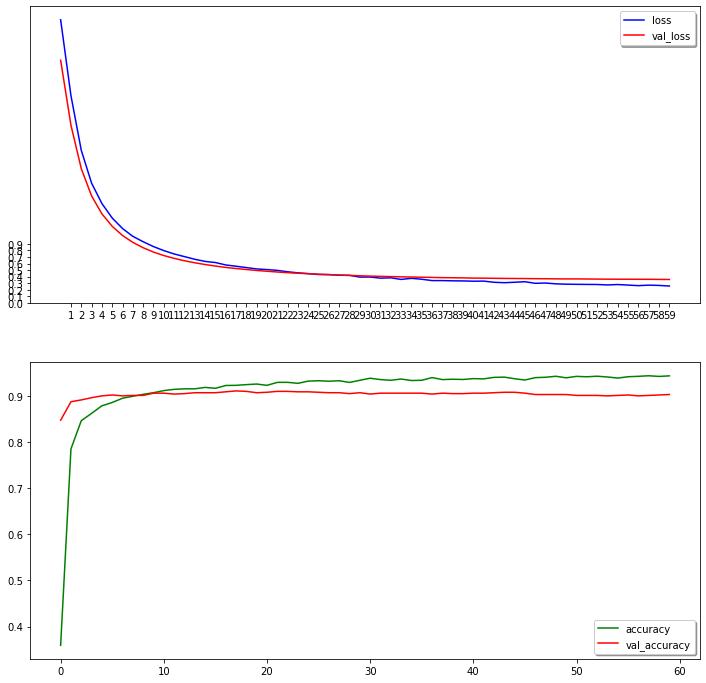

In [ ]:
fig , (ax1,ax2) = plt.subplots(2,1,figsize = (12,12))
ax1.plot(h.history['loss'],color = 'b',label = "loss")
ax1.plot(h.history['val_loss'],color = 'r',label = 'val_loss')
ax1.set_xticks(np.arange(1,60,1))
ax1.set_yticks(np.arange(0,1,0.1))
ax1.legend(['loss','val_loss'],shadow = True)

ax2.plot(h.history['accuracy'],color = 'green',label = 'accuracy')
ax2.plot(h.history['val_accuracy'],color = 'red',label = 'val_accuracy')
ax2.legend(['accuracy','val_accuracy'],shadow = True)
plt.show()

## Prediction

In [ ]:
test_data = []
ids = []
for pic in os.listdir(test_path):
    ids.append(pic.split('.')[0])
    test_data.append(test_path+pic)

In [ ]:
test_dataframe = pd.DataFrame({'file_name':test_data})

In [ ]:
test_features = feature_extractor(test_dataframe)

Found 10357 validated image filenames.


  0%|                                                                                         | 0/1036 [00:00<?, ?it/s]

1/1 [==============================] - 0s 326ms/step


  0%|                                                                                 | 1/1036 [00:00<08:56,  1.93it/s]

1/1 [==============================] - 0s 142ms/step


  0%|▏                                                                                | 2/1036 [00:00<06:52,  2.50it/s]

1/1 [==============================] - 0s 156ms/step


  0%|▏                                                                                | 3/1036 [00:01<06:21,  2.71it/s]

1/1 [==============================] - 0s 142ms/step


  0%|▎                                                                                | 4/1036 [00:01<06:00,  2.86it/s]

1/1 [==============================] - 0s 147ms/step


  0%|▍                                                                                | 5/1036 [00:01<05:54,  2.91it/s]

1/1 [==============================] - 0s 158ms/step


  1%|▍                                                                                | 6/1036 [00:02<05:50,  2.94it/s]

1/1 [==============================] - 0s 145ms/step


  1%|▌                                                                                | 7/1036 [00:02<05:52,  2.92it/s]

1/1 [==============================] - 0s 149ms/step


  1%|▋                                                                                | 8/1036 [00:02<05:47,  2.96it/s]

1/1 [==============================] - 0s 147ms/step


  1%|▋                                                                                | 9/1036 [00:03<05:44,  2.98it/s]

1/1 [==============================] - 0s 147ms/step


  1%|▊                                                                               | 10/1036 [00:03<05:42,  3.00it/s]

1/1 [==============================] - 0s 166ms/step


  1%|▊                                                                               | 11/1036 [00:03<05:40,  3.01it/s]

1/1 [==============================] - 0s 157ms/step


  1%|▉                                                                               | 12/1036 [00:04<05:40,  3.01it/s]

1/1 [==============================] - 0s 148ms/step


  1%|█                                                                               | 13/1036 [00:04<05:39,  3.01it/s]

1/1 [==============================] - 0s 147ms/step


  1%|█                                                                               | 14/1036 [00:04<05:39,  3.01it/s]

1/1 [==============================] - 0s 152ms/step


  1%|█▏                                                                              | 15/1036 [00:05<05:34,  3.05it/s]

1/1 [==============================] - 0s 150ms/step


  2%|█▏                                                                              | 16/1036 [00:05<05:32,  3.07it/s]

1/1 [==============================] - 0s 141ms/step


  2%|█▎                                                                              | 17/1036 [00:05<05:36,  3.03it/s]

1/1 [==============================] - 0s 163ms/step


  2%|█▍                                                                              | 18/1036 [00:06<05:32,  3.06it/s]

1/1 [==============================] - 0s 158ms/step


  2%|█▍                                                                              | 19/1036 [00:06<05:31,  3.07it/s]

1/1 [==============================] - 0s 144ms/step


  2%|█▌                                                                              | 20/1036 [00:06<05:26,  3.11it/s]

1/1 [==============================] - 0s 161ms/step


  2%|█▌                                                                              | 21/1036 [00:07<05:27,  3.10it/s]

1/1 [==============================] - 0s 153ms/step


  2%|█▋                                                                              | 22/1036 [00:07<05:29,  3.07it/s]

1/1 [==============================] - 0s 146ms/step


  2%|█▊                                                                              | 23/1036 [00:07<05:32,  3.05it/s]

1/1 [==============================] - 0s 150ms/step


  2%|█▊                                                                              | 24/1036 [00:08<05:39,  2.98it/s]

1/1 [==============================] - 0s 141ms/step


  2%|█▉                                                                              | 25/1036 [00:08<05:35,  3.02it/s]

1/1 [==============================] - 0s 154ms/step


  3%|██                                                                              | 26/1036 [00:08<05:27,  3.08it/s]

1/1 [==============================] - 0s 145ms/step


  3%|██                                                                              | 27/1036 [00:09<05:24,  3.11it/s]

1/1 [==============================] - 0s 152ms/step


  3%|██▏                                                                             | 28/1036 [00:09<05:25,  3.10it/s]

1/1 [==============================] - 0s 153ms/step


  3%|██▏                                                                             | 29/1036 [00:09<05:24,  3.10it/s]

1/1 [==============================] - 0s 145ms/step


  3%|██▎                                                                             | 30/1036 [00:10<05:25,  3.09it/s]

1/1 [==============================] - 0s 138ms/step


  3%|██▍                                                                             | 31/1036 [00:10<05:22,  3.12it/s]

1/1 [==============================] - 0s 161ms/step


  3%|██▍                                                                             | 32/1036 [00:10<05:23,  3.11it/s]

1/1 [==============================] - 0s 151ms/step


  3%|██▌                                                                             | 33/1036 [00:10<05:27,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


  3%|██▋                                                                             | 34/1036 [00:11<05:30,  3.03it/s]

1/1 [==============================] - 0s 159ms/step


  3%|██▋                                                                             | 35/1036 [00:11<05:35,  2.99it/s]

1/1 [==============================] - 0s 154ms/step


  3%|██▊                                                                             | 36/1036 [00:12<05:39,  2.95it/s]

1/1 [==============================] - 0s 145ms/step


  4%|██▊                                                                             | 37/1036 [00:12<05:36,  2.97it/s]

1/1 [==============================] - 0s 140ms/step


  4%|██▉                                                                             | 38/1036 [00:12<05:33,  3.00it/s]

1/1 [==============================] - 0s 136ms/step


  4%|███                                                                             | 39/1036 [00:12<05:26,  3.05it/s]

1/1 [==============================] - 0s 159ms/step


  4%|███                                                                             | 40/1036 [00:13<05:25,  3.06it/s]

1/1 [==============================] - 0s 141ms/step


  4%|███▏                                                                            | 41/1036 [00:13<05:24,  3.07it/s]

1/1 [==============================] - 0s 149ms/step


  4%|███▏                                                                            | 42/1036 [00:13<05:24,  3.06it/s]

1/1 [==============================] - 0s 150ms/step


  4%|███▎                                                                            | 43/1036 [00:14<05:28,  3.03it/s]

1/1 [==============================] - 0s 154ms/step


  4%|███▍                                                                            | 44/1036 [00:14<05:31,  2.99it/s]

1/1 [==============================] - 0s 156ms/step


  4%|███▍                                                                            | 45/1036 [00:14<05:34,  2.97it/s]

1/1 [==============================] - 0s 151ms/step


  4%|███▌                                                                            | 46/1036 [00:15<05:37,  2.94it/s]

1/1 [==============================] - 0s 158ms/step


  5%|███▋                                                                            | 47/1036 [00:15<05:39,  2.92it/s]

1/1 [==============================] - 0s 155ms/step


  5%|███▋                                                                            | 48/1036 [00:16<05:37,  2.92it/s]

1/1 [==============================] - 0s 140ms/step


  5%|███▊                                                                            | 49/1036 [00:16<05:28,  3.00it/s]

1/1 [==============================] - 0s 141ms/step


  5%|███▊                                                                            | 50/1036 [00:16<05:27,  3.01it/s]

1/1 [==============================] - 0s 143ms/step


  5%|███▉                                                                            | 51/1036 [00:16<05:24,  3.04it/s]

1/1 [==============================] - 0s 141ms/step


  5%|████                                                                            | 52/1036 [00:17<05:20,  3.07it/s]

1/1 [==============================] - 0s 158ms/step


  5%|████                                                                            | 53/1036 [00:17<05:19,  3.08it/s]

1/1 [==============================] - 0s 153ms/step


  5%|████▏                                                                           | 54/1036 [00:17<05:24,  3.03it/s]

1/1 [==============================] - 0s 151ms/step


  5%|████▏                                                                           | 55/1036 [00:18<05:26,  3.01it/s]

1/1 [==============================] - 0s 155ms/step


  5%|████▎                                                                           | 56/1036 [00:18<05:28,  2.98it/s]

1/1 [==============================] - 0s 156ms/step


  6%|████▍                                                                           | 57/1036 [00:18<05:30,  2.97it/s]

1/1 [==============================] - 0s 144ms/step


  6%|████▍                                                                           | 58/1036 [00:19<07:13,  2.25it/s]

1/1 [==============================] - 0s 144ms/step


  6%|████▌                                                                           | 59/1036 [00:20<06:36,  2.47it/s]

1/1 [==============================] - 0s 143ms/step


  6%|████▋                                                                           | 60/1036 [00:20<06:12,  2.62it/s]

1/1 [==============================] - 0s 150ms/step


  6%|████▋                                                                           | 61/1036 [00:20<05:57,  2.73it/s]

1/1 [==============================] - 0s 142ms/step


  6%|████▊                                                                           | 62/1036 [00:20<05:42,  2.85it/s]

1/1 [==============================] - 0s 137ms/step


  6%|████▊                                                                           | 63/1036 [00:21<05:32,  2.93it/s]

1/1 [==============================] - 0s 135ms/step


  6%|████▉                                                                           | 64/1036 [00:21<05:27,  2.97it/s]

1/1 [==============================] - 0s 139ms/step


  6%|█████                                                                           | 65/1036 [00:21<05:23,  3.00it/s]

1/1 [==============================] - 0s 150ms/step


  6%|█████                                                                           | 66/1036 [00:22<05:20,  3.02it/s]

1/1 [==============================] - 0s 154ms/step


  6%|█████▏                                                                          | 67/1036 [00:22<05:24,  2.99it/s]

1/1 [==============================] - 0s 150ms/step


  7%|█████▎                                                                          | 68/1036 [00:22<05:21,  3.01it/s]

1/1 [==============================] - 0s 152ms/step


  7%|█████▎                                                                          | 69/1036 [00:23<05:18,  3.04it/s]

1/1 [==============================] - 0s 153ms/step


  7%|█████▍                                                                          | 70/1036 [00:23<05:19,  3.02it/s]

1/1 [==============================] - 0s 154ms/step


  7%|█████▍                                                                          | 71/1036 [00:23<05:16,  3.05it/s]

1/1 [==============================] - 0s 157ms/step


  7%|█████▌                                                                          | 72/1036 [00:24<05:13,  3.07it/s]

1/1 [==============================] - 0s 137ms/step


  7%|█████▋                                                                          | 73/1036 [00:24<05:09,  3.11it/s]

1/1 [==============================] - 0s 140ms/step


  7%|█████▋                                                                          | 74/1036 [00:24<05:09,  3.11it/s]

1/1 [==============================] - 0s 154ms/step


  7%|█████▊                                                                          | 75/1036 [00:25<05:10,  3.10it/s]

1/1 [==============================] - 0s 156ms/step


  7%|█████▊                                                                          | 76/1036 [00:25<05:14,  3.05it/s]

1/1 [==============================] - 0s 148ms/step


  7%|█████▉                                                                          | 77/1036 [00:25<05:11,  3.08it/s]

1/1 [==============================] - 0s 153ms/step


  8%|██████                                                                          | 78/1036 [00:26<05:18,  3.01it/s]

1/1 [==============================] - 0s 158ms/step


  8%|██████                                                                          | 79/1036 [00:26<05:20,  2.98it/s]

1/1 [==============================] - 0s 154ms/step


  8%|██████▏                                                                         | 80/1036 [00:26<05:22,  2.97it/s]

1/1 [==============================] - 0s 149ms/step


  8%|██████▎                                                                         | 81/1036 [00:27<05:22,  2.96it/s]

1/1 [==============================] - 0s 155ms/step


  8%|██████▎                                                                         | 82/1036 [00:27<05:22,  2.95it/s]

1/1 [==============================] - 0s 146ms/step


  8%|██████▍                                                                         | 83/1036 [00:27<05:19,  2.99it/s]

1/1 [==============================] - 0s 144ms/step


  8%|██████▍                                                                         | 84/1036 [00:28<05:12,  3.05it/s]

1/1 [==============================] - 0s 151ms/step


  8%|██████▌                                                                         | 85/1036 [00:28<05:11,  3.05it/s]

1/1 [==============================] - 0s 157ms/step


  8%|██████▋                                                                         | 86/1036 [00:28<05:11,  3.05it/s]

1/1 [==============================] - 0s 145ms/step


  8%|██████▋                                                                         | 87/1036 [00:29<05:11,  3.05it/s]

1/1 [==============================] - 0s 157ms/step


  8%|██████▊                                                                         | 88/1036 [00:29<05:11,  3.04it/s]

1/1 [==============================] - 0s 146ms/step


  9%|██████▊                                                                         | 89/1036 [00:29<05:07,  3.08it/s]

1/1 [==============================] - 0s 159ms/step


  9%|██████▉                                                                         | 90/1036 [00:30<05:13,  3.02it/s]

1/1 [==============================] - 0s 148ms/step


  9%|███████                                                                         | 91/1036 [00:30<05:11,  3.03it/s]

1/1 [==============================] - 0s 157ms/step


  9%|███████                                                                         | 92/1036 [00:30<05:12,  3.02it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███████▏                                                                        | 93/1036 [00:31<05:11,  3.03it/s]

1/1 [==============================] - 0s 142ms/step


  9%|███████▎                                                                        | 94/1036 [00:31<05:08,  3.05it/s]

1/1 [==============================] - 0s 152ms/step


  9%|███████▎                                                                        | 95/1036 [00:31<05:06,  3.07it/s]

1/1 [==============================] - 0s 157ms/step


  9%|███████▍                                                                        | 96/1036 [00:32<05:06,  3.07it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███████▍                                                                        | 97/1036 [00:32<05:11,  3.01it/s]

1/1 [==============================] - 0s 156ms/step


  9%|███████▌                                                                        | 98/1036 [00:32<05:12,  3.00it/s]

1/1 [==============================] - 0s 157ms/step


 10%|███████▋                                                                        | 99/1036 [00:33<05:14,  2.98it/s]

1/1 [==============================] - 0s 158ms/step


 10%|███████▋                                                                       | 100/1036 [00:33<05:16,  2.95it/s]

1/1 [==============================] - 0s 142ms/step


 10%|███████▋                                                                       | 101/1036 [00:33<05:13,  2.98it/s]

1/1 [==============================] - 0s 138ms/step


 10%|███████▊                                                                       | 102/1036 [00:34<05:08,  3.03it/s]

1/1 [==============================] - 0s 157ms/step


 10%|███████▊                                                                       | 103/1036 [00:34<05:07,  3.04it/s]

1/1 [==============================] - 0s 158ms/step


 10%|███████▉                                                                       | 104/1036 [00:34<05:06,  3.04it/s]

1/1 [==============================] - 0s 175ms/step


 10%|████████                                                                       | 105/1036 [00:35<05:11,  2.99it/s]

1/1 [==============================] - 0s 158ms/step


 10%|████████                                                                       | 106/1036 [00:35<05:09,  3.01it/s]

1/1 [==============================] - 0s 151ms/step


 10%|████████▏                                                                      | 107/1036 [00:35<05:06,  3.03it/s]

1/1 [==============================] - 0s 208ms/step


 10%|████████▏                                                                      | 108/1036 [00:36<05:38,  2.74it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▎                                                                      | 109/1036 [00:36<05:44,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


 11%|████████▍                                                                      | 110/1036 [00:37<05:39,  2.72it/s]

1/1 [==============================] - 0s 157ms/step


 11%|████████▍                                                                      | 111/1036 [00:37<05:28,  2.82it/s]

1/1 [==============================] - 0s 141ms/step


 11%|████████▌                                                                      | 112/1036 [00:37<05:23,  2.86it/s]

1/1 [==============================] - 0s 188ms/step


 11%|████████▌                                                                      | 113/1036 [00:38<05:35,  2.75it/s]

1/1 [==============================] - 0s 174ms/step


 11%|████████▋                                                                      | 114/1036 [00:38<05:33,  2.76it/s]

1/1 [==============================] - 0s 162ms/step


 11%|████████▊                                                                      | 115/1036 [00:38<05:25,  2.83it/s]

1/1 [==============================] - 0s 157ms/step


 11%|████████▊                                                                      | 116/1036 [00:39<05:20,  2.87it/s]

1/1 [==============================] - 0s 158ms/step


 11%|████████▉                                                                      | 117/1036 [00:39<05:14,  2.92it/s]

1/1 [==============================] - 0s 156ms/step


 11%|████████▉                                                                      | 118/1036 [00:39<05:08,  2.98it/s]

1/1 [==============================] - 0s 162ms/step


 11%|█████████                                                                      | 119/1036 [00:40<05:11,  2.95it/s]

1/1 [==============================] - 0s 153ms/step


 12%|█████████▏                                                                     | 120/1036 [00:40<05:08,  2.96it/s]

1/1 [==============================] - 0s 139ms/step


 12%|█████████▏                                                                     | 121/1036 [00:40<05:08,  2.97it/s]

1/1 [==============================] - 0s 145ms/step


 12%|█████████▎                                                                     | 122/1036 [00:41<05:12,  2.93it/s]

1/1 [==============================] - 0s 169ms/step


 12%|█████████▍                                                                     | 123/1036 [00:41<05:12,  2.92it/s]

1/1 [==============================] - 0s 170ms/step


 12%|█████████▍                                                                     | 124/1036 [00:41<05:12,  2.92it/s]

1/1 [==============================] - 0s 145ms/step


 12%|█████████▌                                                                     | 125/1036 [00:42<05:10,  2.93it/s]

1/1 [==============================] - 0s 146ms/step


 12%|█████████▌                                                                     | 126/1036 [00:42<05:12,  2.91it/s]

1/1 [==============================] - 0s 169ms/step


 12%|█████████▋                                                                     | 127/1036 [00:42<05:13,  2.90it/s]

1/1 [==============================] - 0s 159ms/step


 12%|█████████▊                                                                     | 128/1036 [00:43<05:13,  2.90it/s]

1/1 [==============================] - 0s 162ms/step


 12%|█████████▊                                                                     | 129/1036 [00:43<05:17,  2.86it/s]

1/1 [==============================] - 0s 159ms/step


 13%|█████████▉                                                                     | 130/1036 [00:43<05:28,  2.76it/s]

1/1 [==============================] - 0s 158ms/step


 13%|█████████▉                                                                     | 131/1036 [00:44<05:16,  2.86it/s]

1/1 [==============================] - 0s 153ms/step


 13%|██████████                                                                     | 132/1036 [00:44<05:15,  2.87it/s]

1/1 [==============================] - 0s 157ms/step


 13%|██████████▏                                                                    | 133/1036 [00:44<05:09,  2.92it/s]

1/1 [==============================] - 0s 165ms/step


 13%|██████████▏                                                                    | 134/1036 [00:45<05:13,  2.87it/s]

1/1 [==============================] - 0s 173ms/step


 13%|██████████▎                                                                    | 135/1036 [00:45<05:18,  2.83it/s]

1/1 [==============================] - 0s 174ms/step


 13%|██████████▎                                                                    | 136/1036 [00:46<05:23,  2.79it/s]

1/1 [==============================] - 0s 169ms/step


 13%|██████████▍                                                                    | 137/1036 [00:46<05:17,  2.83it/s]

1/1 [==============================] - 0s 158ms/step


 13%|██████████▌                                                                    | 138/1036 [00:46<05:11,  2.89it/s]

1/1 [==============================] - 0s 160ms/step


 13%|██████████▌                                                                    | 139/1036 [00:47<05:12,  2.87it/s]

1/1 [==============================] - 0s 159ms/step


 14%|██████████▋                                                                    | 140/1036 [00:47<05:09,  2.89it/s]

1/1 [==============================] - 0s 159ms/step


 14%|██████████▊                                                                    | 141/1036 [00:47<05:09,  2.89it/s]

1/1 [==============================] - 0s 148ms/step


 14%|██████████▊                                                                    | 142/1036 [00:48<05:06,  2.91it/s]

1/1 [==============================] - 0s 152ms/step


 14%|██████████▉                                                                    | 143/1036 [00:48<05:05,  2.93it/s]

1/1 [==============================] - 0s 174ms/step


 14%|██████████▉                                                                    | 144/1036 [00:48<05:06,  2.91it/s]

1/1 [==============================] - 0s 170ms/step


 14%|███████████                                                                    | 145/1036 [00:49<05:12,  2.85it/s]

1/1 [==============================] - 0s 176ms/step


 14%|███████████▏                                                                   | 146/1036 [00:49<05:19,  2.78it/s]

1/1 [==============================] - 0s 154ms/step


 14%|███████████▏                                                                   | 147/1036 [00:49<05:19,  2.78it/s]

1/1 [==============================] - 0s 143ms/step


 14%|███████████▎                                                                   | 148/1036 [00:50<05:15,  2.82it/s]

1/1 [==============================] - 0s 154ms/step


 14%|███████████▎                                                                   | 149/1036 [00:50<05:13,  2.83it/s]

1/1 [==============================] - 0s 160ms/step


 14%|███████████▍                                                                   | 150/1036 [00:50<05:16,  2.80it/s]

1/1 [==============================] - 0s 159ms/step


 15%|███████████▌                                                                   | 151/1036 [00:51<05:15,  2.80it/s]

1/1 [==============================] - 0s 155ms/step


 15%|███████████▌                                                                   | 152/1036 [00:51<05:18,  2.78it/s]

1/1 [==============================] - 0s 163ms/step


 15%|███████████▋                                                                   | 153/1036 [00:52<05:23,  2.73it/s]

1/1 [==============================] - 0s 156ms/step


 15%|███████████▋                                                                   | 154/1036 [00:52<05:23,  2.73it/s]

1/1 [==============================] - 0s 162ms/step


 15%|███████████▊                                                                   | 155/1036 [00:52<05:28,  2.68it/s]

1/1 [==============================] - 0s 202ms/step


 15%|███████████▉                                                                   | 156/1036 [00:53<05:32,  2.64it/s]

1/1 [==============================] - 0s 158ms/step


 15%|███████████▉                                                                   | 157/1036 [00:53<05:42,  2.57it/s]

1/1 [==============================] - 0s 169ms/step


 15%|████████████                                                                   | 158/1036 [00:53<05:36,  2.61it/s]

1/1 [==============================] - 0s 156ms/step


 15%|████████████                                                                   | 159/1036 [00:54<05:27,  2.68it/s]

1/1 [==============================] - 0s 155ms/step


 15%|████████████▏                                                                  | 160/1036 [00:54<05:22,  2.72it/s]

1/1 [==============================] - 0s 198ms/step


 16%|████████████▎                                                                  | 161/1036 [00:55<05:38,  2.59it/s]

1/1 [==============================] - 0s 192ms/step


 16%|████████████▎                                                                  | 162/1036 [00:55<05:48,  2.51it/s]

1/1 [==============================] - 0s 178ms/step


 16%|████████████▍                                                                  | 163/1036 [00:55<05:50,  2.49it/s]

1/1 [==============================] - 0s 161ms/step


 16%|████████████▌                                                                  | 164/1036 [00:56<05:43,  2.54it/s]

1/1 [==============================] - 0s 168ms/step


 16%|████████████▌                                                                  | 165/1036 [00:56<05:41,  2.55it/s]

1/1 [==============================] - 0s 178ms/step


 16%|████████████▋                                                                  | 166/1036 [00:57<05:27,  2.66it/s]

1/1 [==============================] - 0s 154ms/step


 16%|████████████▋                                                                  | 167/1036 [00:57<05:17,  2.74it/s]

1/1 [==============================] - 0s 143ms/step


 16%|████████████▊                                                                  | 168/1036 [00:57<05:08,  2.82it/s]

1/1 [==============================] - 0s 202ms/step


 16%|████████████▉                                                                  | 169/1036 [00:58<05:27,  2.65it/s]

1/1 [==============================] - 0s 209ms/step


 16%|████████████▉                                                                  | 170/1036 [00:58<05:40,  2.55it/s]

1/1 [==============================] - 0s 191ms/step


 17%|█████████████                                                                  | 171/1036 [00:58<05:43,  2.52it/s]

1/1 [==============================] - 0s 175ms/step


 17%|█████████████                                                                  | 172/1036 [00:59<05:37,  2.56it/s]

1/1 [==============================] - 0s 160ms/step


 17%|█████████████▏                                                                 | 173/1036 [00:59<05:27,  2.63it/s]

1/1 [==============================] - 0s 163ms/step


 17%|█████████████▎                                                                 | 174/1036 [01:00<05:13,  2.75it/s]

1/1 [==============================] - 0s 174ms/step


 17%|█████████████▎                                                                 | 175/1036 [01:00<05:15,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


 17%|█████████████▍                                                                 | 176/1036 [01:00<05:13,  2.75it/s]

1/1 [==============================] - 0s 170ms/step


 17%|█████████████▍                                                                 | 177/1036 [01:01<05:09,  2.78it/s]

1/1 [==============================] - 0s 146ms/step


 17%|█████████████▌                                                                 | 178/1036 [01:01<05:03,  2.82it/s]

1/1 [==============================] - 0s 157ms/step


 17%|█████████████▋                                                                 | 179/1036 [01:01<05:02,  2.83it/s]

1/1 [==============================] - 0s 174ms/step


 17%|█████████████▋                                                                 | 180/1036 [01:02<05:05,  2.80it/s]

1/1 [==============================] - 0s 158ms/step


 17%|█████████████▊                                                                 | 181/1036 [01:02<05:04,  2.81it/s]

1/1 [==============================] - 0s 157ms/step


 18%|█████████████▉                                                                 | 182/1036 [01:02<04:58,  2.86it/s]

1/1 [==============================] - 0s 178ms/step


 18%|█████████████▉                                                                 | 183/1036 [01:03<05:13,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 18%|██████████████                                                                 | 184/1036 [01:03<05:18,  2.68it/s]

1/1 [==============================] - 0s 156ms/step


 18%|██████████████                                                                 | 185/1036 [01:04<05:11,  2.73it/s]

1/1 [==============================] - 0s 163ms/step


 18%|██████████████▏                                                                | 186/1036 [01:04<05:02,  2.81it/s]

1/1 [==============================] - 0s 157ms/step


 18%|██████████████▎                                                                | 187/1036 [01:04<04:59,  2.84it/s]

1/1 [==============================] - 0s 157ms/step


 18%|██████████████▎                                                                | 188/1036 [01:05<04:55,  2.87it/s]

1/1 [==============================] - 0s 163ms/step


 18%|██████████████▍                                                                | 189/1036 [01:05<04:51,  2.90it/s]

1/1 [==============================] - 0s 173ms/step


 18%|██████████████▍                                                                | 190/1036 [01:05<05:00,  2.82it/s]

1/1 [==============================] - 0s 173ms/step


 18%|██████████████▌                                                                | 191/1036 [01:06<05:05,  2.77it/s]

1/1 [==============================] - 0s 161ms/step


 19%|██████████████▋                                                                | 192/1036 [01:06<05:08,  2.73it/s]

1/1 [==============================] - 0s 158ms/step


 19%|██████████████▋                                                                | 193/1036 [01:06<05:00,  2.81it/s]

1/1 [==============================] - 0s 156ms/step


 19%|██████████████▊                                                                | 194/1036 [01:07<05:01,  2.80it/s]

1/1 [==============================] - 0s 174ms/step


 19%|██████████████▊                                                                | 195/1036 [01:07<05:00,  2.80it/s]

1/1 [==============================] - 0s 158ms/step


 19%|██████████████▉                                                                | 196/1036 [01:07<04:57,  2.82it/s]

1/1 [==============================] - 0s 173ms/step


 19%|███████████████                                                                | 197/1036 [01:08<04:59,  2.81it/s]

1/1 [==============================] - 0s 161ms/step


 19%|███████████████                                                                | 198/1036 [01:08<05:01,  2.78it/s]

1/1 [==============================] - 0s 162ms/step


 19%|███████████████▏                                                               | 199/1036 [01:08<05:03,  2.76it/s]

1/1 [==============================] - 0s 173ms/step


 19%|███████████████▎                                                               | 200/1036 [01:09<05:07,  2.72it/s]

1/1 [==============================] - 0s 160ms/step


 19%|███████████████▎                                                               | 201/1036 [01:09<05:03,  2.75it/s]

1/1 [==============================] - 0s 161ms/step


 19%|███████████████▍                                                               | 202/1036 [01:10<04:59,  2.78it/s]

1/1 [==============================] - 0s 160ms/step


 20%|███████████████▍                                                               | 203/1036 [01:10<04:57,  2.80it/s]

1/1 [==============================] - 0s 164ms/step


 20%|███████████████▌                                                               | 204/1036 [01:10<05:01,  2.76it/s]

1/1 [==============================] - 0s 161ms/step


 20%|███████████████▋                                                               | 205/1036 [01:11<04:58,  2.78it/s]

1/1 [==============================] - 0s 156ms/step


 20%|███████████████▋                                                               | 206/1036 [01:11<04:52,  2.84it/s]

1/1 [==============================] - 0s 157ms/step


 20%|███████████████▊                                                               | 207/1036 [01:11<04:55,  2.81it/s]

1/1 [==============================] - 0s 158ms/step


 20%|███████████████▊                                                               | 208/1036 [01:12<04:56,  2.79it/s]

1/1 [==============================] - 0s 157ms/step


 20%|███████████████▉                                                               | 209/1036 [01:12<04:55,  2.80it/s]

1/1 [==============================] - 0s 161ms/step


 20%|████████████████                                                               | 210/1036 [01:12<04:52,  2.83it/s]

1/1 [==============================] - 0s 156ms/step


 20%|████████████████                                                               | 211/1036 [01:13<04:59,  2.75it/s]

1/1 [==============================] - 0s 171ms/step


 20%|████████████████▏                                                              | 212/1036 [01:13<05:03,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▏                                                              | 213/1036 [01:14<05:00,  2.74it/s]

1/1 [==============================] - 0s 157ms/step


 21%|████████████████▎                                                              | 214/1036 [01:14<04:56,  2.77it/s]

1/1 [==============================] - 0s 159ms/step


 21%|████████████████▍                                                              | 215/1036 [01:14<04:49,  2.84it/s]

1/1 [==============================] - 0s 141ms/step


 21%|████████████████▍                                                              | 216/1036 [01:15<04:41,  2.91it/s]

1/1 [==============================] - 0s 161ms/step


 21%|████████████████▌                                                              | 217/1036 [01:15<04:44,  2.88it/s]

1/1 [==============================] - 0s 172ms/step


 21%|████████████████▌                                                              | 218/1036 [01:15<04:51,  2.81it/s]

1/1 [==============================] - 0s 188ms/step


 21%|████████████████▋                                                              | 219/1036 [01:16<04:55,  2.77it/s]

1/1 [==============================] - 0s 164ms/step


 21%|████████████████▊                                                              | 220/1036 [01:16<04:53,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


 21%|████████████████▊                                                              | 221/1036 [01:16<04:49,  2.81it/s]

1/1 [==============================] - 0s 176ms/step


 21%|████████████████▉                                                              | 222/1036 [01:17<04:56,  2.75it/s]

1/1 [==============================] - 0s 175ms/step


 22%|█████████████████                                                              | 223/1036 [01:17<04:56,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


 22%|█████████████████                                                              | 224/1036 [01:17<04:55,  2.75it/s]

1/1 [==============================] - 0s 157ms/step


 22%|█████████████████▏                                                             | 225/1036 [01:18<04:52,  2.77it/s]

1/1 [==============================] - 0s 144ms/step


 22%|█████████████████▏                                                             | 226/1036 [01:18<04:47,  2.82it/s]

1/1 [==============================] - 0s 171ms/step


 22%|█████████████████▎                                                             | 227/1036 [01:19<04:53,  2.75it/s]

1/1 [==============================] - 0s 172ms/step


 22%|█████████████████▍                                                             | 228/1036 [01:19<04:59,  2.70it/s]

1/1 [==============================] - 0s 166ms/step


 22%|█████████████████▍                                                             | 229/1036 [01:19<05:00,  2.68it/s]

1/1 [==============================] - 0s 163ms/step


 22%|█████████████████▌                                                             | 230/1036 [01:20<04:55,  2.73it/s]

1/1 [==============================] - 0s 177ms/step


 22%|█████████████████▌                                                             | 231/1036 [01:20<04:53,  2.74it/s]

1/1 [==============================] - 0s 169ms/step


 22%|█████████████████▋                                                             | 232/1036 [01:20<04:57,  2.70it/s]

1/1 [==============================] - 0s 164ms/step


 22%|█████████████████▊                                                             | 233/1036 [01:21<05:04,  2.64it/s]

1/1 [==============================] - 0s 177ms/step


 23%|█████████████████▊                                                             | 234/1036 [01:21<05:11,  2.57it/s]

1/1 [==============================] - 0s 163ms/step


 23%|█████████████████▉                                                             | 235/1036 [01:22<05:09,  2.59it/s]

1/1 [==============================] - 0s 168ms/step


 23%|█████████████████▉                                                             | 236/1036 [01:22<05:01,  2.65it/s]

1/1 [==============================] - 0s 163ms/step


 23%|██████████████████                                                             | 237/1036 [01:22<04:55,  2.71it/s]

1/1 [==============================] - 0s 160ms/step


 23%|██████████████████▏                                                            | 238/1036 [01:23<04:47,  2.78it/s]

1/1 [==============================] - 0s 213ms/step


 23%|██████████████████▏                                                            | 239/1036 [01:23<05:20,  2.49it/s]

1/1 [==============================] - 0s 196ms/step


 23%|██████████████████▎                                                            | 240/1036 [01:24<05:18,  2.50it/s]

1/1 [==============================] - 0s 172ms/step


 23%|██████████████████▍                                                            | 241/1036 [01:24<05:12,  2.54it/s]

1/1 [==============================] - 0s 177ms/step


 23%|██████████████████▍                                                            | 242/1036 [01:24<05:10,  2.56it/s]

1/1 [==============================] - 0s 185ms/step


 23%|██████████████████▌                                                            | 243/1036 [01:25<05:14,  2.52it/s]

1/1 [==============================] - 0s 185ms/step


 24%|██████████████████▌                                                            | 244/1036 [01:25<05:15,  2.51it/s]

1/1 [==============================] - 0s 185ms/step


 24%|██████████████████▋                                                            | 245/1036 [01:26<05:17,  2.49it/s]

1/1 [==============================] - 0s 178ms/step


 24%|██████████████████▊                                                            | 246/1036 [01:26<05:17,  2.49it/s]

1/1 [==============================] - 0s 169ms/step


 24%|██████████████████▊                                                            | 247/1036 [01:26<05:15,  2.50it/s]

1/1 [==============================] - 0s 176ms/step


 24%|██████████████████▉                                                            | 248/1036 [01:27<05:07,  2.56it/s]

1/1 [==============================] - 0s 161ms/step


 24%|██████████████████▉                                                            | 249/1036 [01:27<05:04,  2.59it/s]

1/1 [==============================] - 0s 167ms/step


 24%|███████████████████                                                            | 250/1036 [01:27<04:51,  2.69it/s]

1/1 [==============================] - 0s 151ms/step


 24%|███████████████████▏                                                           | 251/1036 [01:28<04:46,  2.74it/s]

1/1 [==============================] - 0s 172ms/step


 24%|███████████████████▏                                                           | 252/1036 [01:28<04:47,  2.73it/s]

1/1 [==============================] - 0s 175ms/step


 24%|███████████████████▎                                                           | 253/1036 [01:28<04:48,  2.71it/s]

1/1 [==============================] - 0s 163ms/step


 25%|███████████████████▎                                                           | 254/1036 [01:29<04:42,  2.77it/s]

1/1 [==============================] - 0s 157ms/step


 25%|███████████████████▍                                                           | 255/1036 [01:29<04:39,  2.80it/s]

1/1 [==============================] - 0s 212ms/step


 25%|███████████████████▌                                                           | 256/1036 [01:30<04:57,  2.62it/s]

1/1 [==============================] - 0s 203ms/step


 25%|███████████████████▌                                                           | 257/1036 [01:30<05:09,  2.51it/s]

1/1 [==============================] - 0s 197ms/step


 25%|███████████████████▋                                                           | 258/1036 [01:30<05:17,  2.45it/s]

1/1 [==============================] - 0s 173ms/step


 25%|███████████████████▊                                                           | 259/1036 [01:31<05:12,  2.49it/s]

1/1 [==============================] - 0s 169ms/step


 25%|███████████████████▊                                                           | 260/1036 [01:31<05:03,  2.56it/s]

1/1 [==============================] - 0s 163ms/step


 25%|███████████████████▉                                                           | 261/1036 [01:32<05:04,  2.55it/s]

1/1 [==============================] - 0s 180ms/step


 25%|███████████████████▉                                                           | 262/1036 [01:32<05:01,  2.57it/s]

1/1 [==============================] - 0s 162ms/step


 25%|████████████████████                                                           | 263/1036 [01:32<04:52,  2.65it/s]

1/1 [==============================] - 0s 145ms/step


 25%|████████████████████▏                                                          | 264/1036 [01:33<04:43,  2.72it/s]

1/1 [==============================] - 0s 157ms/step


 26%|████████████████████▏                                                          | 265/1036 [01:33<04:45,  2.70it/s]

1/1 [==============================] - 0s 176ms/step


 26%|████████████████████▎                                                          | 266/1036 [01:33<04:47,  2.68it/s]

1/1 [==============================] - 0s 157ms/step


 26%|████████████████████▎                                                          | 267/1036 [01:34<04:41,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 26%|████████████████████▍                                                          | 268/1036 [01:34<04:37,  2.77it/s]

1/1 [==============================] - 0s 156ms/step


 26%|████████████████████▌                                                          | 269/1036 [01:34<04:30,  2.84it/s]

1/1 [==============================] - 0s 214ms/step


 26%|████████████████████▌                                                          | 270/1036 [01:35<04:53,  2.61it/s]

1/1 [==============================] - 0s 215ms/step


 26%|████████████████████▋                                                          | 271/1036 [01:35<05:10,  2.46it/s]

1/1 [==============================] - 0s 198ms/step


 26%|████████████████████▋                                                          | 272/1036 [01:36<05:14,  2.43it/s]

1/1 [==============================] - 0s 170ms/step


 26%|████████████████████▊                                                          | 273/1036 [01:36<05:05,  2.50it/s]

1/1 [==============================] - 0s 152ms/step


 26%|████████████████████▉                                                          | 274/1036 [01:37<04:53,  2.60it/s]

1/1 [==============================] - 0s 171ms/step


 27%|████████████████████▉                                                          | 275/1036 [01:37<04:58,  2.55it/s]

1/1 [==============================] - 0s 196ms/step


 27%|█████████████████████                                                          | 276/1036 [01:37<05:15,  2.41it/s]

1/1 [==============================] - 0s 169ms/step


 27%|█████████████████████                                                          | 277/1036 [01:38<05:12,  2.43it/s]

1/1 [==============================] - 0s 165ms/step


 27%|█████████████████████▏                                                         | 278/1036 [01:38<05:03,  2.50it/s]

1/1 [==============================] - 0s 173ms/step


 27%|█████████████████████▎                                                         | 279/1036 [01:39<04:58,  2.53it/s]

1/1 [==============================] - 0s 159ms/step


 27%|█████████████████████▎                                                         | 280/1036 [01:39<04:53,  2.57it/s]

1/1 [==============================] - 0s 170ms/step


 27%|█████████████████████▍                                                         | 281/1036 [01:39<04:53,  2.58it/s]

1/1 [==============================] - 0s 168ms/step


 27%|█████████████████████▌                                                         | 282/1036 [01:40<04:49,  2.60it/s]

1/1 [==============================] - 0s 171ms/step


 27%|█████████████████████▌                                                         | 283/1036 [01:40<04:53,  2.56it/s]

1/1 [==============================] - 0s 158ms/step


 27%|█████████████████████▋                                                         | 284/1036 [01:41<04:49,  2.60it/s]

1/1 [==============================] - 0s 161ms/step


 28%|█████████████████████▋                                                         | 285/1036 [01:41<04:49,  2.59it/s]

1/1 [==============================] - 0s 168ms/step


 28%|█████████████████████▊                                                         | 286/1036 [01:41<04:45,  2.63it/s]

1/1 [==============================] - 0s 206ms/step


 28%|█████████████████████▉                                                         | 287/1036 [01:42<04:54,  2.54it/s]

1/1 [==============================] - 0s 209ms/step


 28%|█████████████████████▉                                                         | 288/1036 [01:42<05:04,  2.46it/s]

1/1 [==============================] - 0s 191ms/step


 28%|██████████████████████                                                         | 289/1036 [01:43<05:07,  2.43it/s]

1/1 [==============================] - 0s 178ms/step


 28%|██████████████████████                                                         | 290/1036 [01:43<05:04,  2.45it/s]

1/1 [==============================] - 0s 160ms/step


 28%|██████████████████████▏                                                        | 291/1036 [01:43<04:50,  2.56it/s]

1/1 [==============================] - 0s 208ms/step


 28%|██████████████████████▎                                                        | 292/1036 [01:44<05:02,  2.46it/s]

1/1 [==============================] - 0s 191ms/step


 28%|██████████████████████▎                                                        | 293/1036 [01:44<05:06,  2.43it/s]

1/1 [==============================] - 0s 176ms/step


 28%|██████████████████████▍                                                        | 294/1036 [01:45<05:02,  2.45it/s]

1/1 [==============================] - 0s 177ms/step


 28%|██████████████████████▍                                                        | 295/1036 [01:45<04:58,  2.48it/s]

1/1 [==============================] - 0s 189ms/step


 29%|██████████████████████▌                                                        | 296/1036 [01:45<05:00,  2.46it/s]

1/1 [==============================] - 0s 172ms/step


 29%|██████████████████████▋                                                        | 297/1036 [01:46<04:52,  2.52it/s]

1/1 [==============================] - 0s 158ms/step


 29%|██████████████████████▋                                                        | 298/1036 [01:46<04:46,  2.58it/s]

1/1 [==============================] - 0s 158ms/step


 29%|██████████████████████▊                                                        | 299/1036 [01:46<04:40,  2.63it/s]

1/1 [==============================] - 0s 157ms/step


 29%|██████████████████████▉                                                        | 300/1036 [01:47<04:33,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


 29%|██████████████████████▉                                                        | 301/1036 [01:47<04:32,  2.69it/s]

1/1 [==============================] - 0s 176ms/step


 29%|███████████████████████                                                        | 302/1036 [01:48<04:33,  2.68it/s]

1/1 [==============================] - 0s 162ms/step


 29%|███████████████████████                                                        | 303/1036 [01:48<04:32,  2.69it/s]

1/1 [==============================] - 0s 151ms/step


 29%|███████████████████████▏                                                       | 304/1036 [01:48<04:24,  2.77it/s]

1/1 [==============================] - 0s 157ms/step


 29%|███████████████████████▎                                                       | 305/1036 [01:49<04:18,  2.83it/s]

1/1 [==============================] - 0s 201ms/step


 30%|███████████████████████▎                                                       | 306/1036 [01:49<04:38,  2.63it/s]

1/1 [==============================] - 0s 200ms/step


 30%|███████████████████████▍                                                       | 307/1036 [01:49<04:49,  2.51it/s]

1/1 [==============================] - 0s 185ms/step


 30%|███████████████████████▍                                                       | 308/1036 [01:50<04:46,  2.54it/s]

1/1 [==============================] - 0s 168ms/step


 30%|███████████████████████▌                                                       | 309/1036 [01:50<04:45,  2.54it/s]

1/1 [==============================] - 0s 169ms/step


 30%|███████████████████████▋                                                       | 310/1036 [01:51<04:38,  2.61it/s]

1/1 [==============================] - 0s 155ms/step


 30%|███████████████████████▋                                                       | 311/1036 [01:51<04:29,  2.69it/s]

1/1 [==============================] - 0s 169ms/step


 30%|███████████████████████▊                                                       | 312/1036 [01:51<04:28,  2.70it/s]

1/1 [==============================] - 0s 166ms/step


 30%|███████████████████████▊                                                       | 313/1036 [01:52<04:25,  2.73it/s]

1/1 [==============================] - 0s 212ms/step


 30%|███████████████████████▉                                                       | 314/1036 [01:52<04:41,  2.57it/s]

1/1 [==============================] - 0s 196ms/step


 30%|████████████████████████                                                       | 315/1036 [01:53<04:55,  2.44it/s]

1/1 [==============================] - 0s 185ms/step


 31%|████████████████████████                                                       | 316/1036 [01:53<04:56,  2.42it/s]

1/1 [==============================] - 0s 192ms/step


 31%|████████████████████████▏                                                      | 317/1036 [01:53<04:55,  2.43it/s]

1/1 [==============================] - 0s 167ms/step


 31%|████████████████████████▏                                                      | 318/1036 [01:54<04:46,  2.50it/s]

1/1 [==============================] - 0s 161ms/step


 31%|████████████████████████▎                                                      | 319/1036 [01:54<04:37,  2.59it/s]

1/1 [==============================] - 0s 211ms/step


 31%|████████████████████████▍                                                      | 320/1036 [01:55<04:49,  2.48it/s]

1/1 [==============================] - 0s 196ms/step


 31%|████████████████████████▍                                                      | 321/1036 [01:55<04:55,  2.42it/s]

1/1 [==============================] - 0s 192ms/step


 31%|████████████████████████▌                                                      | 322/1036 [01:55<04:56,  2.41it/s]

1/1 [==============================] - 0s 189ms/step


 31%|████████████████████████▋                                                      | 323/1036 [01:56<04:51,  2.44it/s]

1/1 [==============================] - 0s 175ms/step


 31%|████████████████████████▋                                                      | 324/1036 [01:56<04:46,  2.48it/s]

1/1 [==============================] - 0s 186ms/step


 31%|████████████████████████▊                                                      | 325/1036 [01:57<04:48,  2.47it/s]

1/1 [==============================] - 0s 177ms/step


 31%|████████████████████████▊                                                      | 326/1036 [01:57<04:45,  2.48it/s]

1/1 [==============================] - 0s 172ms/step


 32%|████████████████████████▉                                                      | 327/1036 [01:57<04:48,  2.45it/s]

1/1 [==============================] - 0s 209ms/step


 32%|█████████████████████████                                                      | 328/1036 [01:58<04:52,  2.42it/s]

1/1 [==============================] - 0s 170ms/step


 32%|█████████████████████████                                                      | 329/1036 [01:58<04:44,  2.48it/s]

1/1 [==============================] - 0s 179ms/step


 32%|█████████████████████████▏                                                     | 330/1036 [01:59<04:42,  2.50it/s]

1/1 [==============================] - 0s 173ms/step


 32%|█████████████████████████▏                                                     | 331/1036 [01:59<04:39,  2.52it/s]

1/1 [==============================] - 0s 172ms/step


 32%|█████████████████████████▎                                                     | 332/1036 [01:59<04:29,  2.62it/s]

1/1 [==============================] - 0s 165ms/step


 32%|█████████████████████████▍                                                     | 333/1036 [02:00<04:23,  2.67it/s]

1/1 [==============================] - 0s 156ms/step


 32%|█████████████████████████▍                                                     | 334/1036 [02:00<04:19,  2.71it/s]

1/1 [==============================] - 0s 198ms/step


 32%|█████████████████████████▌                                                     | 335/1036 [02:01<04:33,  2.57it/s]

1/1 [==============================] - 0s 194ms/step


 32%|█████████████████████████▌                                                     | 336/1036 [02:01<04:42,  2.47it/s]

1/1 [==============================] - 0s 196ms/step


 33%|█████████████████████████▋                                                     | 337/1036 [02:01<04:48,  2.42it/s]

1/1 [==============================] - 0s 170ms/step


 33%|█████████████████████████▊                                                     | 338/1036 [02:02<04:41,  2.48it/s]

1/1 [==============================] - 0s 163ms/step


 33%|█████████████████████████▊                                                     | 339/1036 [02:02<04:26,  2.61it/s]

1/1 [==============================] - 0s 198ms/step


 33%|█████████████████████████▉                                                     | 340/1036 [02:03<04:38,  2.50it/s]

1/1 [==============================] - 0s 197ms/step


 33%|██████████████████████████                                                     | 341/1036 [02:03<04:43,  2.45it/s]

1/1 [==============================] - 0s 189ms/step


 33%|██████████████████████████                                                     | 342/1036 [02:03<04:47,  2.41it/s]

1/1 [==============================] - 0s 189ms/step


 33%|██████████████████████████▏                                                    | 343/1036 [02:04<04:47,  2.41it/s]

1/1 [==============================] - 0s 181ms/step


 33%|██████████████████████████▏                                                    | 344/1036 [02:04<04:38,  2.48it/s]

1/1 [==============================] - 0s 178ms/step


 33%|██████████████████████████▎                                                    | 345/1036 [02:05<04:30,  2.56it/s]

1/1 [==============================] - 0s 162ms/step


 33%|██████████████████████████▍                                                    | 346/1036 [02:05<04:20,  2.65it/s]

1/1 [==============================] - 0s 166ms/step


 33%|██████████████████████████▍                                                    | 347/1036 [02:05<04:16,  2.69it/s]

1/1 [==============================] - 0s 152ms/step


 34%|██████████████████████████▌                                                    | 348/1036 [02:06<04:08,  2.77it/s]

1/1 [==============================] - 0s 223ms/step


 34%|██████████████████████████▌                                                    | 349/1036 [02:06<04:28,  2.56it/s]

1/1 [==============================] - 0s 229ms/step


 34%|██████████████████████████▋                                                    | 350/1036 [02:07<04:40,  2.44it/s]

1/1 [==============================] - 0s 197ms/step


 34%|██████████████████████████▊                                                    | 351/1036 [02:07<04:44,  2.41it/s]

1/1 [==============================] - 0s 161ms/step


 34%|██████████████████████████▊                                                    | 352/1036 [02:07<04:36,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▉                                                    | 353/1036 [02:08<04:27,  2.55it/s]

1/1 [==============================] - 0s 149ms/step


 34%|██████████████████████████▉                                                    | 354/1036 [02:08<04:18,  2.64it/s]

1/1 [==============================] - 0s 191ms/step


 34%|███████████████████████████                                                    | 355/1036 [02:09<04:30,  2.51it/s]

1/1 [==============================] - 0s 195ms/step


 34%|███████████████████████████▏                                                   | 356/1036 [02:09<04:38,  2.45it/s]

1/1 [==============================] - 0s 180ms/step


 34%|███████████████████████████▏                                                   | 357/1036 [02:09<04:37,  2.45it/s]

1/1 [==============================] - 0s 190ms/step


 35%|███████████████████████████▎                                                   | 358/1036 [02:10<04:38,  2.44it/s]

1/1 [==============================] - 0s 180ms/step


 35%|███████████████████████████▍                                                   | 359/1036 [02:10<04:39,  2.42it/s]

1/1 [==============================] - 0s 193ms/step


 35%|███████████████████████████▍                                                   | 360/1036 [02:11<04:42,  2.40it/s]

1/1 [==============================] - 0s 184ms/step


 35%|███████████████████████████▌                                                   | 361/1036 [02:11<04:43,  2.38it/s]

1/1 [==============================] - 0s 187ms/step


 35%|███████████████████████████▌                                                   | 362/1036 [02:11<04:38,  2.42it/s]

1/1 [==============================] - 0s 158ms/step


 35%|███████████████████████████▋                                                   | 363/1036 [02:12<04:23,  2.55it/s]

1/1 [==============================] - 0s 194ms/step


 35%|███████████████████████████▊                                                   | 364/1036 [02:12<04:33,  2.45it/s]

1/1 [==============================] - 0s 212ms/step


 35%|███████████████████████████▊                                                   | 365/1036 [02:13<04:39,  2.40it/s]

1/1 [==============================] - 0s 206ms/step


 35%|███████████████████████████▉                                                   | 366/1036 [02:13<04:40,  2.39it/s]

1/1 [==============================] - 0s 185ms/step


 35%|███████████████████████████▉                                                   | 367/1036 [02:13<04:35,  2.43it/s]

1/1 [==============================] - 0s 180ms/step


 36%|████████████████████████████                                                   | 368/1036 [02:14<04:27,  2.50it/s]

1/1 [==============================] - 0s 171ms/step


 36%|████████████████████████████▏                                                  | 369/1036 [02:14<04:21,  2.55it/s]

1/1 [==============================] - 0s 157ms/step


 36%|████████████████████████████▏                                                  | 370/1036 [02:15<04:14,  2.62it/s]

1/1 [==============================] - 0s 170ms/step


 36%|████████████████████████████▎                                                  | 371/1036 [02:15<04:12,  2.63it/s]

1/1 [==============================] - 0s 169ms/step


 36%|████████████████████████████▎                                                  | 372/1036 [02:15<04:10,  2.65it/s]

1/1 [==============================] - 0s 145ms/step


 36%|████████████████████████████▍                                                  | 373/1036 [02:16<04:01,  2.74it/s]

1/1 [==============================] - 0s 197ms/step


 36%|████████████████████████████▌                                                  | 374/1036 [02:16<04:15,  2.59it/s]

1/1 [==============================] - 0s 202ms/step


 36%|████████████████████████████▌                                                  | 375/1036 [02:17<04:25,  2.49it/s]

1/1 [==============================] - 0s 187ms/step


 36%|████████████████████████████▋                                                  | 376/1036 [02:17<04:33,  2.41it/s]

1/1 [==============================] - 0s 173ms/step


 36%|████████████████████████████▋                                                  | 377/1036 [02:17<04:27,  2.47it/s]

1/1 [==============================] - 0s 169ms/step


 36%|████████████████████████████▊                                                  | 378/1036 [02:18<04:22,  2.50it/s]

1/1 [==============================] - 0s 175ms/step


 37%|████████████████████████████▉                                                  | 379/1036 [02:18<04:21,  2.51it/s]

1/1 [==============================] - 0s 180ms/step


 37%|████████████████████████████▉                                                  | 380/1036 [02:19<04:20,  2.52it/s]

1/1 [==============================] - 0s 186ms/step


 37%|█████████████████████████████                                                  | 381/1036 [02:19<04:20,  2.52it/s]

1/1 [==============================] - 0s 153ms/step


 37%|█████████████████████████████▏                                                 | 382/1036 [02:20<05:43,  1.90it/s]

1/1 [==============================] - 0s 204ms/step


 37%|█████████████████████████████▏                                                 | 383/1036 [02:20<05:28,  1.99it/s]

1/1 [==============================] - 0s 187ms/step


 37%|█████████████████████████████▎                                                 | 384/1036 [02:21<05:12,  2.09it/s]

1/1 [==============================] - 0s 186ms/step


 37%|█████████████████████████████▎                                                 | 385/1036 [02:21<05:01,  2.16it/s]

1/1 [==============================] - 0s 171ms/step


 37%|█████████████████████████████▍                                                 | 386/1036 [02:21<04:45,  2.27it/s]

1/1 [==============================] - 0s 178ms/step


 37%|█████████████████████████████▌                                                 | 387/1036 [02:22<04:34,  2.36it/s]

1/1 [==============================] - 0s 187ms/step


 37%|█████████████████████████████▌                                                 | 388/1036 [02:22<04:31,  2.38it/s]

1/1 [==============================] - 0s 186ms/step


 38%|█████████████████████████████▋                                                 | 389/1036 [02:23<04:25,  2.44it/s]

1/1 [==============================] - 0s 167ms/step


 38%|█████████████████████████████▋                                                 | 390/1036 [02:23<04:17,  2.51it/s]

1/1 [==============================] - 0s 162ms/step


 38%|█████████████████████████████▊                                                 | 391/1036 [02:23<04:11,  2.56it/s]

1/1 [==============================] - 0s 172ms/step


 38%|█████████████████████████████▉                                                 | 392/1036 [02:24<04:06,  2.61it/s]

1/1 [==============================] - 0s 177ms/step


 38%|█████████████████████████████▉                                                 | 393/1036 [02:24<04:00,  2.67it/s]

1/1 [==============================] - 0s 169ms/step


 38%|██████████████████████████████                                                 | 394/1036 [02:24<04:00,  2.67it/s]

1/1 [==============================] - 0s 207ms/step


 38%|██████████████████████████████                                                 | 395/1036 [02:25<04:15,  2.51it/s]

1/1 [==============================] - 0s 214ms/step


 38%|██████████████████████████████▏                                                | 396/1036 [02:25<04:25,  2.41it/s]

1/1 [==============================] - 0s 190ms/step


 38%|██████████████████████████████▎                                                | 397/1036 [02:26<04:24,  2.41it/s]

1/1 [==============================] - 0s 171ms/step


 38%|██████████████████████████████▎                                                | 398/1036 [02:26<04:17,  2.48it/s]

1/1 [==============================] - 0s 157ms/step


 39%|██████████████████████████████▍                                                | 399/1036 [02:27<04:05,  2.60it/s]

1/1 [==============================] - 0s 206ms/step


 39%|██████████████████████████████▌                                                | 400/1036 [02:27<04:17,  2.47it/s]

1/1 [==============================] - 0s 214ms/step


 39%|██████████████████████████████▌                                                | 401/1036 [02:27<04:25,  2.39it/s]

1/1 [==============================] - 0s 187ms/step


 39%|██████████████████████████████▋                                                | 402/1036 [02:28<04:24,  2.40it/s]

1/1 [==============================] - 0s 182ms/step


 39%|██████████████████████████████▋                                                | 403/1036 [02:28<04:20,  2.43it/s]

1/1 [==============================] - 0s 167ms/step


 39%|██████████████████████████████▊                                                | 404/1036 [02:29<04:07,  2.55it/s]

1/1 [==============================] - 0s 179ms/step


 39%|██████████████████████████████▉                                                | 405/1036 [02:29<04:13,  2.49it/s]

1/1 [==============================] - 0s 189ms/step


 39%|██████████████████████████████▉                                                | 406/1036 [02:29<04:19,  2.43it/s]

1/1 [==============================] - 0s 191ms/step


 39%|███████████████████████████████                                                | 407/1036 [02:30<04:24,  2.38it/s]

1/1 [==============================] - 0s 189ms/step


 39%|███████████████████████████████                                                | 408/1036 [02:30<04:17,  2.43it/s]

1/1 [==============================] - 0s 174ms/step


 39%|███████████████████████████████▏                                               | 409/1036 [02:31<04:11,  2.49it/s]

1/1 [==============================] - 0s 182ms/step


 40%|███████████████████████████████▎                                               | 410/1036 [02:31<04:07,  2.53it/s]

1/1 [==============================] - 0s 172ms/step


 40%|███████████████████████████████▎                                               | 411/1036 [02:31<04:10,  2.49it/s]

1/1 [==============================] - 0s 191ms/step


 40%|███████████████████████████████▍                                               | 412/1036 [02:32<04:13,  2.46it/s]

1/1 [==============================] - 0s 174ms/step


 40%|███████████████████████████████▍                                               | 413/1036 [02:32<04:04,  2.54it/s]

1/1 [==============================] - 0s 159ms/step


 40%|███████████████████████████████▌                                               | 414/1036 [02:33<03:59,  2.60it/s]

1/1 [==============================] - 0s 162ms/step


 40%|███████████████████████████████▋                                               | 415/1036 [02:33<03:50,  2.70it/s]

1/1 [==============================] - 0s 157ms/step


 40%|███████████████████████████████▋                                               | 416/1036 [02:33<03:48,  2.71it/s]

1/1 [==============================] - 0s 198ms/step


 40%|███████████████████████████████▊                                               | 417/1036 [02:34<04:01,  2.57it/s]

1/1 [==============================] - 0s 179ms/step


 40%|███████████████████████████████▊                                               | 418/1036 [02:34<04:04,  2.53it/s]

1/1 [==============================] - 0s 182ms/step


 40%|███████████████████████████████▉                                               | 419/1036 [02:35<04:07,  2.50it/s]

1/1 [==============================] - 0s 185ms/step


 41%|████████████████████████████████                                               | 420/1036 [02:35<04:09,  2.47it/s]

1/1 [==============================] - 0s 188ms/step


 41%|████████████████████████████████                                               | 421/1036 [02:35<04:11,  2.45it/s]

1/1 [==============================] - 0s 178ms/step


 41%|████████████████████████████████▏                                              | 422/1036 [02:36<04:12,  2.43it/s]

1/1 [==============================] - 0s 172ms/step


 41%|████████████████████████████████▎                                              | 423/1036 [02:36<04:13,  2.42it/s]

1/1 [==============================] - 0s 168ms/step


 41%|████████████████████████████████▎                                              | 424/1036 [02:37<04:12,  2.43it/s]

1/1 [==============================] - 0s 181ms/step


 41%|████████████████████████████████▍                                              | 425/1036 [02:37<04:03,  2.51it/s]

1/1 [==============================] - 0s 184ms/step


 41%|████████████████████████████████▍                                              | 426/1036 [02:37<04:06,  2.47it/s]

1/1 [==============================] - 0s 188ms/step


 41%|████████████████████████████████▌                                              | 427/1036 [02:38<04:11,  2.43it/s]

1/1 [==============================] - 0s 192ms/step


 41%|████████████████████████████████▋                                              | 428/1036 [02:38<04:15,  2.38it/s]

1/1 [==============================] - 0s 194ms/step


 41%|████████████████████████████████▋                                              | 429/1036 [02:39<04:13,  2.39it/s]

1/1 [==============================] - 0s 173ms/step


 42%|████████████████████████████████▊                                              | 430/1036 [02:39<04:06,  2.46it/s]

1/1 [==============================] - 0s 189ms/step


 42%|████████████████████████████████▊                                              | 431/1036 [02:39<04:06,  2.45it/s]

1/1 [==============================] - 0s 173ms/step


 42%|████████████████████████████████▉                                              | 432/1036 [02:40<04:01,  2.50it/s]

1/1 [==============================] - 0s 174ms/step


 42%|█████████████████████████████████                                              | 433/1036 [02:40<04:00,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 42%|█████████████████████████████████                                              | 434/1036 [02:41<03:58,  2.52it/s]

1/1 [==============================] - 0s 186ms/step


 42%|█████████████████████████████████▏                                             | 435/1036 [02:41<03:58,  2.52it/s]

1/1 [==============================] - 0s 178ms/step


 42%|█████████████████████████████████▏                                             | 436/1036 [02:41<03:52,  2.58it/s]

1/1 [==============================] - 0s 157ms/step


 42%|█████████████████████████████████▎                                             | 437/1036 [02:42<03:44,  2.67it/s]

1/1 [==============================] - 0s 163ms/step


 42%|█████████████████████████████████▍                                             | 438/1036 [02:42<03:43,  2.68it/s]

1/1 [==============================] - 0s 157ms/step


 42%|█████████████████████████████████▍                                             | 439/1036 [02:42<03:37,  2.74it/s]

1/1 [==============================] - 0s 202ms/step


 42%|█████████████████████████████████▌                                             | 440/1036 [02:43<03:48,  2.60it/s]

1/1 [==============================] - 0s 220ms/step


 43%|█████████████████████████████████▋                                             | 441/1036 [02:43<04:02,  2.46it/s]

1/1 [==============================] - 0s 186ms/step


 43%|█████████████████████████████████▋                                             | 442/1036 [02:44<04:02,  2.45it/s]

1/1 [==============================] - 0s 168ms/step


 43%|█████████████████████████████████▊                                             | 443/1036 [02:44<03:59,  2.48it/s]

1/1 [==============================] - 0s 182ms/step


 43%|█████████████████████████████████▊                                             | 444/1036 [02:45<03:56,  2.51it/s]

1/1 [==============================] - 0s 191ms/step


 43%|█████████████████████████████████▉                                             | 445/1036 [02:45<03:54,  2.52it/s]

1/1 [==============================] - 0s 170ms/step


 43%|██████████████████████████████████                                             | 446/1036 [02:45<03:49,  2.57it/s]

1/1 [==============================] - 0s 160ms/step


 43%|██████████████████████████████████                                             | 447/1036 [02:46<03:47,  2.58it/s]

1/1 [==============================] - 0s 157ms/step


 43%|██████████████████████████████████▏                                            | 448/1036 [02:46<03:42,  2.64it/s]

1/1 [==============================] - 0s 157ms/step


 43%|██████████████████████████████████▏                                            | 449/1036 [02:46<03:32,  2.76it/s]

1/1 [==============================] - 0s 218ms/step


 43%|██████████████████████████████████▎                                            | 450/1036 [02:47<03:48,  2.56it/s]

1/1 [==============================] - 0s 217ms/step


 44%|██████████████████████████████████▍                                            | 451/1036 [02:47<03:57,  2.46it/s]

1/1 [==============================] - 0s 202ms/step


 44%|██████████████████████████████████▍                                            | 452/1036 [02:48<04:03,  2.40it/s]

1/1 [==============================] - 0s 176ms/step


 44%|██████████████████████████████████▌                                            | 453/1036 [02:48<03:59,  2.44it/s]

1/1 [==============================] - 0s 173ms/step


 44%|██████████████████████████████████▌                                            | 454/1036 [02:49<03:54,  2.48it/s]

1/1 [==============================] - 0s 188ms/step


 44%|██████████████████████████████████▋                                            | 455/1036 [02:49<03:53,  2.49it/s]

1/1 [==============================] - 0s 183ms/step


 44%|██████████████████████████████████▊                                            | 456/1036 [02:49<03:51,  2.50it/s]

1/1 [==============================] - 0s 192ms/step


 44%|██████████████████████████████████▊                                            | 457/1036 [02:50<03:51,  2.50it/s]

1/1 [==============================] - 0s 188ms/step


 44%|██████████████████████████████████▉                                            | 458/1036 [02:50<03:49,  2.52it/s]

1/1 [==============================] - 0s 184ms/step


 44%|███████████████████████████████████                                            | 459/1036 [02:50<03:49,  2.51it/s]

1/1 [==============================] - 0s 161ms/step


 44%|███████████████████████████████████                                            | 460/1036 [02:51<03:47,  2.54it/s]

1/1 [==============================] - 0s 182ms/step


 44%|███████████████████████████████████▏                                           | 461/1036 [02:51<03:41,  2.59it/s]

1/1 [==============================] - 0s 168ms/step


 45%|███████████████████████████████████▏                                           | 462/1036 [02:52<03:41,  2.59it/s]

1/1 [==============================] - 0s 146ms/step


 45%|███████████████████████████████████▎                                           | 463/1036 [02:52<03:36,  2.65it/s]

1/1 [==============================] - 0s 146ms/step


 45%|███████████████████████████████████▍                                           | 464/1036 [02:52<03:28,  2.75it/s]

1/1 [==============================] - 0s 209ms/step


 45%|███████████████████████████████████▍                                           | 465/1036 [02:53<03:39,  2.60it/s]

1/1 [==============================] - 0s 216ms/step


 45%|███████████████████████████████████▌                                           | 466/1036 [02:53<03:51,  2.46it/s]

1/1 [==============================] - 0s 204ms/step


 45%|███████████████████████████████████▌                                           | 467/1036 [02:54<03:56,  2.41it/s]

1/1 [==============================] - 0s 189ms/step


 45%|███████████████████████████████████▋                                           | 468/1036 [02:54<04:01,  2.35it/s]

1/1 [==============================] - 0s 155ms/step


 45%|███████████████████████████████████▊                                           | 469/1036 [02:54<03:47,  2.49it/s]

1/1 [==============================] - 0s 162ms/step


 45%|███████████████████████████████████▊                                           | 470/1036 [02:55<03:38,  2.59it/s]

1/1 [==============================] - 0s 177ms/step


 45%|███████████████████████████████████▉                                           | 471/1036 [02:55<03:40,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


 46%|███████████████████████████████████▉                                           | 472/1036 [02:56<03:40,  2.56it/s]

1/1 [==============================] - 0s 170ms/step


 46%|████████████████████████████████████                                           | 473/1036 [02:56<03:45,  2.49it/s]

1/1 [==============================] - 0s 156ms/step


 46%|████████████████████████████████████▏                                          | 474/1036 [02:56<03:40,  2.55it/s]

1/1 [==============================] - 0s 152ms/step


 46%|████████████████████████████████████▏                                          | 475/1036 [02:57<03:33,  2.63it/s]

1/1 [==============================] - 0s 176ms/step


 46%|████████████████████████████████████▎                                          | 476/1036 [02:57<03:33,  2.63it/s]

1/1 [==============================] - 0s 179ms/step


 46%|████████████████████████████████████▎                                          | 477/1036 [02:58<03:34,  2.61it/s]

1/1 [==============================] - 0s 165ms/step


 46%|████████████████████████████████████▍                                          | 478/1036 [02:58<03:29,  2.66it/s]

1/1 [==============================] - 0s 160ms/step


 46%|████████████████████████████████████▌                                          | 479/1036 [02:58<03:25,  2.71it/s]

1/1 [==============================] - 0s 161ms/step


 46%|████████████████████████████████████▌                                          | 480/1036 [02:59<03:25,  2.70it/s]

1/1 [==============================] - 0s 176ms/step


 46%|████████████████████████████████████▋                                          | 481/1036 [02:59<03:27,  2.67it/s]

1/1 [==============================] - 0s 169ms/step


 47%|████████████████████████████████████▊                                          | 482/1036 [02:59<03:28,  2.66it/s]

1/1 [==============================] - 0s 174ms/step


 47%|████████████████████████████████████▊                                          | 483/1036 [03:00<03:25,  2.69it/s]

1/1 [==============================] - 0s 192ms/step


 47%|████████████████████████████████████▉                                          | 484/1036 [03:00<03:38,  2.53it/s]

1/1 [==============================] - 0s 190ms/step


 47%|████████████████████████████████████▉                                          | 485/1036 [03:01<03:42,  2.48it/s]

1/1 [==============================] - 0s 173ms/step


 47%|█████████████████████████████████████                                          | 486/1036 [03:01<03:39,  2.50it/s]

1/1 [==============================] - 0s 183ms/step


 47%|█████████████████████████████████████▏                                         | 487/1036 [03:01<03:36,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


 47%|█████████████████████████████████████▏                                         | 488/1036 [03:02<03:33,  2.57it/s]

1/1 [==============================] - 0s 190ms/step


 47%|█████████████████████████████████████▎                                         | 489/1036 [03:02<03:31,  2.59it/s]

1/1 [==============================] - 0s 162ms/step


 47%|█████████████████████████████████████▎                                         | 490/1036 [03:02<03:26,  2.65it/s]

1/1 [==============================] - 0s 163ms/step


 47%|█████████████████████████████████████▍                                         | 491/1036 [03:03<03:21,  2.70it/s]

1/1 [==============================] - 0s 162ms/step


 47%|█████████████████████████████████████▌                                         | 492/1036 [03:03<03:20,  2.72it/s]

1/1 [==============================] - 0s 168ms/step


 48%|█████████████████████████████████████▌                                         | 493/1036 [03:04<03:24,  2.65it/s]

1/1 [==============================] - 0s 182ms/step


 48%|█████████████████████████████████████▋                                         | 494/1036 [03:04<03:32,  2.55it/s]

1/1 [==============================] - 0s 186ms/step


 48%|█████████████████████████████████████▋                                         | 495/1036 [03:04<03:35,  2.51it/s]

1/1 [==============================] - 0s 177ms/step


 48%|█████████████████████████████████████▊                                         | 496/1036 [03:05<03:34,  2.51it/s]

1/1 [==============================] - 0s 189ms/step


 48%|█████████████████████████████████████▉                                         | 497/1036 [03:05<03:33,  2.53it/s]

1/1 [==============================] - 0s 192ms/step


 48%|█████████████████████████████████████▉                                         | 498/1036 [03:06<03:34,  2.51it/s]

1/1 [==============================] - 0s 167ms/step


 48%|██████████████████████████████████████                                         | 499/1036 [03:06<03:29,  2.56it/s]

1/1 [==============================] - 0s 166ms/step


 48%|██████████████████████████████████████▏                                        | 500/1036 [03:06<03:24,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


 48%|██████████████████████████████████████▏                                        | 501/1036 [03:07<03:22,  2.65it/s]

1/1 [==============================] - 0s 184ms/step


 48%|██████████████████████████████████████▎                                        | 502/1036 [03:07<03:24,  2.61it/s]

1/1 [==============================] - 0s 178ms/step


 49%|██████████████████████████████████████▎                                        | 503/1036 [03:08<03:25,  2.59it/s]

1/1 [==============================] - 0s 187ms/step


 49%|██████████████████████████████████████▍                                        | 504/1036 [03:08<03:29,  2.53it/s]

1/1 [==============================] - 0s 196ms/step


 49%|██████████████████████████████████████▌                                        | 505/1036 [03:08<03:34,  2.48it/s]

1/1 [==============================] - 0s 172ms/step


 49%|██████████████████████████████████████▌                                        | 506/1036 [03:09<03:28,  2.54it/s]

1/1 [==============================] - 0s 157ms/step


 49%|██████████████████████████████████████▋                                        | 507/1036 [03:09<03:22,  2.61it/s]

1/1 [==============================] - 0s 178ms/step


 49%|██████████████████████████████████████▋                                        | 508/1036 [03:09<03:26,  2.56it/s]

1/1 [==============================] - 0s 186ms/step


 49%|██████████████████████████████████████▊                                        | 509/1036 [03:10<03:28,  2.53it/s]

1/1 [==============================] - 0s 167ms/step


 49%|██████████████████████████████████████▉                                        | 510/1036 [03:10<03:24,  2.57it/s]

1/1 [==============================] - 0s 162ms/step


 49%|██████████████████████████████████████▉                                        | 511/1036 [03:11<03:17,  2.65it/s]

1/1 [==============================] - 0s 162ms/step


 49%|███████████████████████████████████████                                        | 512/1036 [03:11<03:13,  2.71it/s]

1/1 [==============================] - 0s 188ms/step


 50%|███████████████████████████████████████                                        | 513/1036 [03:11<03:22,  2.59it/s]

1/1 [==============================] - 0s 201ms/step


 50%|███████████████████████████████████████▏                                       | 514/1036 [03:12<03:28,  2.50it/s]

1/1 [==============================] - 0s 192ms/step


 50%|███████████████████████████████████████▎                                       | 515/1036 [03:12<03:31,  2.46it/s]

1/1 [==============================] - 0s 210ms/step


 50%|███████████████████████████████████████▎                                       | 516/1036 [03:13<03:35,  2.41it/s]

1/1 [==============================] - 0s 174ms/step


 50%|███████████████████████████████████████▍                                       | 517/1036 [03:13<03:30,  2.46it/s]

1/1 [==============================] - 0s 190ms/step


 50%|███████████████████████████████████████▌                                       | 518/1036 [03:13<03:28,  2.49it/s]

1/1 [==============================] - 0s 190ms/step


 50%|███████████████████████████████████████▌                                       | 519/1036 [03:14<03:25,  2.51it/s]

1/1 [==============================] - 0s 195ms/step


 50%|███████████████████████████████████████▋                                       | 520/1036 [03:14<03:25,  2.51it/s]

1/1 [==============================] - 0s 193ms/step


 50%|███████████████████████████████████████▋                                       | 521/1036 [03:15<03:26,  2.49it/s]

1/1 [==============================] - 0s 172ms/step


 50%|███████████████████████████████████████▊                                       | 522/1036 [03:15<03:21,  2.55it/s]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████▉                                       | 523/1036 [03:15<03:14,  2.64it/s]

1/1 [==============================] - 0s 176ms/step


 51%|███████████████████████████████████████▉                                       | 524/1036 [03:16<03:14,  2.64it/s]

1/1 [==============================] - 0s 179ms/step


 51%|████████████████████████████████████████                                       | 525/1036 [03:16<03:14,  2.62it/s]

1/1 [==============================] - 0s 190ms/step


 51%|████████████████████████████████████████                                       | 526/1036 [03:17<03:15,  2.61it/s]

1/1 [==============================] - 0s 181ms/step


 51%|████████████████████████████████████████▏                                      | 527/1036 [03:17<03:15,  2.60it/s]

1/1 [==============================] - 0s 189ms/step


 51%|████████████████████████████████████████▎                                      | 528/1036 [03:17<03:13,  2.62it/s]

1/1 [==============================] - 0s 173ms/step


 51%|████████████████████████████████████████▎                                      | 529/1036 [03:18<03:10,  2.66it/s]

1/1 [==============================] - 0s 159ms/step


 51%|████████████████████████████████████████▍                                      | 530/1036 [03:18<03:06,  2.72it/s]

1/1 [==============================] - 0s 162ms/step


 51%|████████████████████████████████████████▍                                      | 531/1036 [03:18<03:00,  2.79it/s]

1/1 [==============================] - 0s 220ms/step


 51%|████████████████████████████████████████▌                                      | 532/1036 [03:19<03:13,  2.60it/s]

1/1 [==============================] - 0s 220ms/step


 51%|████████████████████████████████████████▋                                      | 533/1036 [03:19<03:22,  2.48it/s]

1/1 [==============================] - 0s 191ms/step


 52%|████████████████████████████████████████▋                                      | 534/1036 [03:20<03:25,  2.45it/s]

1/1 [==============================] - 0s 189ms/step


 52%|████████████████████████████████████████▊                                      | 535/1036 [03:20<03:21,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


 52%|████████████████████████████████████████▊                                      | 536/1036 [03:20<03:18,  2.52it/s]

1/1 [==============================] - 0s 153ms/step


 52%|████████████████████████████████████████▉                                      | 537/1036 [03:21<03:13,  2.58it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████████████████████████████████████████                                      | 538/1036 [03:21<03:12,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


 52%|█████████████████████████████████████████                                      | 539/1036 [03:22<03:08,  2.64it/s]

1/1 [==============================] - 0s 173ms/step


 52%|█████████████████████████████████████████▏                                     | 540/1036 [03:22<03:07,  2.64it/s]

1/1 [==============================] - 0s 178ms/step


 52%|█████████████████████████████████████████▎                                     | 541/1036 [03:22<03:09,  2.61it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████████████████████████████████████████▎                                     | 542/1036 [03:23<03:02,  2.71it/s]

1/1 [==============================] - 0s 210ms/step


 52%|█████████████████████████████████████████▍                                     | 543/1036 [03:23<03:10,  2.59it/s]

1/1 [==============================] - 0s 220ms/step


 53%|█████████████████████████████████████████▍                                     | 544/1036 [03:24<03:17,  2.49it/s]

1/1 [==============================] - 0s 186ms/step


 53%|█████████████████████████████████████████▌                                     | 545/1036 [03:24<03:21,  2.44it/s]

1/1 [==============================] - 0s 182ms/step


 53%|█████████████████████████████████████████▋                                     | 546/1036 [03:24<03:19,  2.45it/s]

1/1 [==============================] - 0s 187ms/step


 53%|█████████████████████████████████████████▋                                     | 547/1036 [03:25<03:19,  2.45it/s]

1/1 [==============================] - 0s 193ms/step


 53%|█████████████████████████████████████████▊                                     | 548/1036 [03:25<03:19,  2.44it/s]

1/1 [==============================] - 0s 190ms/step


 53%|█████████████████████████████████████████▊                                     | 549/1036 [03:26<03:19,  2.44it/s]

1/1 [==============================] - 0s 159ms/step


 53%|█████████████████████████████████████████▉                                     | 550/1036 [03:26<03:10,  2.55it/s]

1/1 [==============================] - 0s 158ms/step


 53%|██████████████████████████████████████████                                     | 551/1036 [03:26<03:05,  2.61it/s]

1/1 [==============================] - 0s 172ms/step


 53%|██████████████████████████████████████████                                     | 552/1036 [03:27<02:58,  2.71it/s]

1/1 [==============================] - 0s 161ms/step


 53%|██████████████████████████████████████████▏                                    | 553/1036 [03:27<02:57,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


 53%|██████████████████████████████████████████▏                                    | 554/1036 [03:27<02:57,  2.72it/s]

1/1 [==============================] - 0s 174ms/step


 54%|██████████████████████████████████████████▎                                    | 555/1036 [03:28<02:59,  2.69it/s]

1/1 [==============================] - 0s 158ms/step


 54%|██████████████████████████████████████████▍                                    | 556/1036 [03:28<02:55,  2.73it/s]

1/1 [==============================] - 0s 158ms/step


 54%|██████████████████████████████████████████▍                                    | 557/1036 [03:28<02:52,  2.78it/s]

1/1 [==============================] - 0s 173ms/step


 54%|██████████████████████████████████████████▌                                    | 558/1036 [03:29<02:52,  2.77it/s]

1/1 [==============================] - 0s 174ms/step


 54%|██████████████████████████████████████████▋                                    | 559/1036 [03:29<02:57,  2.68it/s]

1/1 [==============================] - 0s 199ms/step


 54%|██████████████████████████████████████████▋                                    | 560/1036 [03:30<02:59,  2.65it/s]

1/1 [==============================] - 0s 157ms/step


 54%|██████████████████████████████████████████▊                                    | 561/1036 [03:30<02:56,  2.70it/s]

1/1 [==============================] - 0s 155ms/step


 54%|██████████████████████████████████████████▊                                    | 562/1036 [03:30<02:51,  2.77it/s]

1/1 [==============================] - 0s 172ms/step


 54%|██████████████████████████████████████████▉                                    | 563/1036 [03:31<02:53,  2.72it/s]

1/1 [==============================] - 0s 189ms/step


 54%|███████████████████████████████████████████                                    | 564/1036 [03:31<02:55,  2.69it/s]

1/1 [==============================] - 0s 156ms/step


 55%|███████████████████████████████████████████                                    | 565/1036 [03:31<02:52,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 55%|███████████████████████████████████████████▏                                   | 566/1036 [03:32<02:49,  2.77it/s]

1/1 [==============================] - 0s 142ms/step


 55%|███████████████████████████████████████████▏                                   | 567/1036 [03:32<02:43,  2.87it/s]

1/1 [==============================] - 0s 189ms/step


 55%|███████████████████████████████████████████▎                                   | 568/1036 [03:32<02:52,  2.71it/s]

1/1 [==============================] - 0s 205ms/step


 55%|███████████████████████████████████████████▍                                   | 569/1036 [03:33<02:58,  2.62it/s]

1/1 [==============================] - 0s 190ms/step


 55%|███████████████████████████████████████████▍                                   | 570/1036 [03:33<03:04,  2.53it/s]

1/1 [==============================] - 0s 188ms/step


 55%|███████████████████████████████████████████▌                                   | 571/1036 [03:34<03:06,  2.49it/s]

1/1 [==============================] - 0s 171ms/step


 55%|███████████████████████████████████████████▌                                   | 572/1036 [03:34<03:03,  2.53it/s]

1/1 [==============================] - 0s 180ms/step


 55%|███████████████████████████████████████████▋                                   | 573/1036 [03:34<02:59,  2.58it/s]

1/1 [==============================] - 0s 171ms/step


 55%|███████████████████████████████████████████▊                                   | 574/1036 [03:35<02:54,  2.65it/s]

1/1 [==============================] - 0s 146ms/step


 56%|███████████████████████████████████████████▊                                   | 575/1036 [03:35<02:49,  2.72it/s]

1/1 [==============================] - 0s 174ms/step


 56%|███████████████████████████████████████████▉                                   | 576/1036 [03:36<02:48,  2.74it/s]

1/1 [==============================] - 0s 174ms/step


 56%|███████████████████████████████████████████▉                                   | 577/1036 [03:36<02:52,  2.66it/s]

1/1 [==============================] - 0s 190ms/step


 56%|████████████████████████████████████████████                                   | 578/1036 [03:36<02:54,  2.63it/s]

1/1 [==============================] - 0s 173ms/step


 56%|████████████████████████████████████████████▏                                  | 579/1036 [03:37<02:54,  2.62it/s]

1/1 [==============================] - 0s 157ms/step


 56%|████████████████████████████████████████████▏                                  | 580/1036 [03:37<02:52,  2.64it/s]

1/1 [==============================] - 0s 173ms/step


 56%|████████████████████████████████████████████▎                                  | 581/1036 [03:37<02:50,  2.67it/s]

1/1 [==============================] - 0s 171ms/step


 56%|████████████████████████████████████████████▍                                  | 582/1036 [03:38<02:50,  2.66it/s]

1/1 [==============================] - 0s 173ms/step


 56%|████████████████████████████████████████████▍                                  | 583/1036 [03:38<02:49,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


 56%|████████████████████████████████████████████▌                                  | 584/1036 [03:39<02:54,  2.60it/s]

1/1 [==============================] - 0s 190ms/step


 56%|████████████████████████████████████████████▌                                  | 585/1036 [03:39<02:56,  2.55it/s]

1/1 [==============================] - 0s 175ms/step


 57%|████████████████████████████████████████████▋                                  | 586/1036 [03:39<02:55,  2.56it/s]

1/1 [==============================] - 0s 158ms/step


 57%|████████████████████████████████████████████▊                                  | 587/1036 [03:40<02:56,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


 57%|████████████████████████████████████████████▊                                  | 588/1036 [03:40<02:55,  2.55it/s]

1/1 [==============================] - 0s 156ms/step


 57%|████████████████████████████████████████████▉                                  | 589/1036 [03:41<02:50,  2.62it/s]

1/1 [==============================] - 0s 170ms/step


 57%|████████████████████████████████████████████▉                                  | 590/1036 [03:41<02:48,  2.65it/s]

1/1 [==============================] - 0s 175ms/step


 57%|█████████████████████████████████████████████                                  | 591/1036 [03:41<02:50,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


 57%|█████████████████████████████████████████████▏                                 | 592/1036 [03:42<02:47,  2.65it/s]

1/1 [==============================] - 0s 157ms/step


 57%|█████████████████████████████████████████████▏                                 | 593/1036 [03:42<02:49,  2.62it/s]

1/1 [==============================] - 0s 189ms/step


 57%|█████████████████████████████████████████████▎                                 | 594/1036 [03:42<02:49,  2.60it/s]

1/1 [==============================] - 0s 159ms/step


 57%|█████████████████████████████████████████████▎                                 | 595/1036 [03:43<02:49,  2.60it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████████████████████████████████████████████▍                                 | 596/1036 [03:43<02:44,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


 58%|█████████████████████████████████████████████▌                                 | 597/1036 [03:44<02:45,  2.65it/s]

1/1 [==============================] - 0s 192ms/step


 58%|█████████████████████████████████████████████▌                                 | 598/1036 [03:44<02:46,  2.63it/s]

1/1 [==============================] - 0s 173ms/step


 58%|█████████████████████████████████████████████▋                                 | 599/1036 [03:44<02:46,  2.62it/s]

1/1 [==============================] - 0s 186ms/step


 58%|█████████████████████████████████████████████▊                                 | 600/1036 [03:45<02:48,  2.58it/s]

1/1 [==============================] - 0s 169ms/step


 58%|█████████████████████████████████████████████▊                                 | 601/1036 [03:45<02:46,  2.62it/s]

1/1 [==============================] - 0s 157ms/step


 58%|█████████████████████████████████████████████▉                                 | 602/1036 [03:45<02:42,  2.66it/s]

1/1 [==============================] - 0s 173ms/step


 58%|█████████████████████████████████████████████▉                                 | 603/1036 [03:46<02:39,  2.71it/s]

1/1 [==============================] - 0s 176ms/step


 58%|██████████████████████████████████████████████                                 | 604/1036 [03:46<02:37,  2.74it/s]

1/1 [==============================] - 0s 174ms/step


 58%|██████████████████████████████████████████████▏                                | 605/1036 [03:47<02:37,  2.74it/s]

1/1 [==============================] - 0s 159ms/step


 58%|██████████████████████████████████████████████▏                                | 606/1036 [03:47<02:39,  2.70it/s]

1/1 [==============================] - 0s 171ms/step


 59%|██████████████████████████████████████████████▎                                | 607/1036 [03:47<02:41,  2.66it/s]

1/1 [==============================] - 0s 174ms/step


 59%|██████████████████████████████████████████████▎                                | 608/1036 [03:48<02:38,  2.70it/s]

1/1 [==============================] - 0s 173ms/step


 59%|██████████████████████████████████████████████▍                                | 609/1036 [03:48<02:34,  2.76it/s]

1/1 [==============================] - 0s 205ms/step


 59%|██████████████████████████████████████████████▌                                | 610/1036 [03:48<02:44,  2.59it/s]

1/1 [==============================] - 0s 198ms/step


 59%|██████████████████████████████████████████████▌                                | 611/1036 [03:49<02:49,  2.51it/s]

1/1 [==============================] - 0s 194ms/step


 59%|██████████████████████████████████████████████▋                                | 612/1036 [03:49<02:48,  2.52it/s]

1/1 [==============================] - 0s 189ms/step


 59%|██████████████████████████████████████████████▋                                | 613/1036 [03:50<02:51,  2.47it/s]

1/1 [==============================] - 0s 188ms/step


 59%|██████████████████████████████████████████████▊                                | 614/1036 [03:50<02:49,  2.48it/s]

1/1 [==============================] - 0s 173ms/step


 59%|██████████████████████████████████████████████▉                                | 615/1036 [03:51<02:47,  2.51it/s]

1/1 [==============================] - 0s 173ms/step


 59%|██████████████████████████████████████████████▉                                | 616/1036 [03:51<02:44,  2.56it/s]

1/1 [==============================] - 0s 171ms/step


 60%|███████████████████████████████████████████████                                | 617/1036 [03:51<02:39,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


 60%|███████████████████████████████████████████████▏                               | 618/1036 [03:52<02:38,  2.64it/s]

1/1 [==============================] - 0s 174ms/step


 60%|███████████████████████████████████████████████▏                               | 619/1036 [03:52<02:35,  2.68it/s]

1/1 [==============================] - 0s 159ms/step


 60%|███████████████████████████████████████████████▎                               | 620/1036 [03:52<02:33,  2.71it/s]

1/1 [==============================] - 0s 158ms/step


 60%|███████████████████████████████████████████████▎                               | 621/1036 [03:53<02:31,  2.74it/s]

1/1 [==============================] - 0s 172ms/step


 60%|███████████████████████████████████████████████▍                               | 622/1036 [03:53<02:29,  2.76it/s]

1/1 [==============================] - 0s 176ms/step


 60%|███████████████████████████████████████████████▌                               | 623/1036 [03:53<02:30,  2.74it/s]

1/1 [==============================] - 0s 157ms/step


 60%|███████████████████████████████████████████████▌                               | 624/1036 [03:54<02:30,  2.74it/s]

1/1 [==============================] - 0s 191ms/step


 60%|███████████████████████████████████████████████▋                               | 625/1036 [03:54<02:32,  2.69it/s]

1/1 [==============================] - 0s 156ms/step


 60%|███████████████████████████████████████████████▋                               | 626/1036 [03:55<02:31,  2.71it/s]

1/1 [==============================] - 0s 157ms/step


 61%|███████████████████████████████████████████████▊                               | 627/1036 [03:55<02:26,  2.80it/s]

1/1 [==============================] - 0s 157ms/step


 61%|███████████████████████████████████████████████▉                               | 628/1036 [03:55<02:24,  2.83it/s]

1/1 [==============================] - 0s 220ms/step


 61%|███████████████████████████████████████████████▉                               | 629/1036 [03:56<02:35,  2.62it/s]

1/1 [==============================] - 0s 222ms/step


 61%|████████████████████████████████████████████████                               | 630/1036 [03:56<02:41,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


 61%|████████████████████████████████████████████████                               | 631/1036 [03:57<02:43,  2.48it/s]

1/1 [==============================] - 0s 174ms/step


 61%|████████████████████████████████████████████████▏                              | 632/1036 [03:57<02:39,  2.53it/s]

1/1 [==============================] - 0s 173ms/step


 61%|████████████████████████████████████████████████▎                              | 633/1036 [03:57<02:35,  2.59it/s]

1/1 [==============================] - 0s 173ms/step


 61%|████████████████████████████████████████████████▎                              | 634/1036 [03:58<02:33,  2.62it/s]

1/1 [==============================] - 0s 159ms/step


 61%|████████████████████████████████████████████████▍                              | 635/1036 [03:58<02:28,  2.70it/s]

1/1 [==============================] - 0s 153ms/step


 61%|████████████████████████████████████████████████▍                              | 636/1036 [03:58<02:26,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


 61%|████████████████████████████████████████████████▌                              | 637/1036 [03:59<02:29,  2.68it/s]

1/1 [==============================] - 0s 173ms/step


 62%|████████████████████████████████████████████████▋                              | 638/1036 [03:59<02:31,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


 62%|████████████████████████████████████████████████▋                              | 639/1036 [04:00<02:32,  2.60it/s]

1/1 [==============================] - 0s 163ms/step


 62%|████████████████████████████████████████████████▊                              | 640/1036 [04:00<02:29,  2.64it/s]

1/1 [==============================] - 0s 173ms/step


 62%|████████████████████████████████████████████████▉                              | 641/1036 [04:00<02:24,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 62%|████████████████████████████████████████████████▉                              | 642/1036 [04:01<02:18,  2.85it/s]

1/1 [==============================] - 0s 203ms/step


 62%|█████████████████████████████████████████████████                              | 643/1036 [04:01<02:28,  2.65it/s]

1/1 [==============================] - 0s 202ms/step


 62%|█████████████████████████████████████████████████                              | 644/1036 [04:01<02:34,  2.54it/s]

1/1 [==============================] - 0s 189ms/step


 62%|█████████████████████████████████████████████████▏                             | 645/1036 [04:02<02:37,  2.48it/s]

1/1 [==============================] - 0s 190ms/step


 62%|█████████████████████████████████████████████████▎                             | 646/1036 [04:02<02:38,  2.46it/s]

1/1 [==============================] - 0s 190ms/step


 62%|█████████████████████████████████████████████████▎                             | 647/1036 [04:03<02:34,  2.52it/s]

1/1 [==============================] - 0s 177ms/step


 63%|█████████████████████████████████████████████████▍                             | 648/1036 [04:03<02:30,  2.58it/s]

1/1 [==============================] - 0s 157ms/step


 63%|█████████████████████████████████████████████████▍                             | 649/1036 [04:03<02:26,  2.64it/s]

1/1 [==============================] - 0s 156ms/step


 63%|█████████████████████████████████████████████████▌                             | 650/1036 [04:04<02:24,  2.67it/s]

1/1 [==============================] - 0s 172ms/step


 63%|█████████████████████████████████████████████████▋                             | 651/1036 [04:04<02:23,  2.69it/s]

1/1 [==============================] - 0s 157ms/step


 63%|█████████████████████████████████████████████████▋                             | 652/1036 [04:04<02:21,  2.72it/s]

1/1 [==============================] - 0s 205ms/step


 63%|█████████████████████████████████████████████████▊                             | 653/1036 [04:05<02:29,  2.57it/s]

1/1 [==============================] - 0s 205ms/step


 63%|█████████████████████████████████████████████████▊                             | 654/1036 [04:05<02:34,  2.46it/s]

1/1 [==============================] - 0s 188ms/step


 63%|█████████████████████████████████████████████████▉                             | 655/1036 [04:06<02:31,  2.51it/s]

1/1 [==============================] - 0s 184ms/step


 63%|██████████████████████████████████████████████████                             | 656/1036 [04:06<02:29,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


 63%|██████████████████████████████████████████████████                             | 657/1036 [04:06<02:26,  2.59it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████████████████████████████████████████████████▏                            | 658/1036 [04:07<02:22,  2.65it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████████████████████████████████████████████████▎                            | 659/1036 [04:07<02:18,  2.72it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████████████████████████████████████████████████▎                            | 660/1036 [04:08<02:17,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████████████████████████████████████████████████▍                            | 661/1036 [04:08<02:19,  2.68it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████████████████████████████████████████████████▍                            | 662/1036 [04:08<02:17,  2.72it/s]

1/1 [==============================] - 0s 172ms/step


 64%|██████████████████████████████████████████████████▌                            | 663/1036 [04:09<02:15,  2.75it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████████████████████████████████████████████████▋                            | 664/1036 [04:09<02:12,  2.80it/s]

1/1 [==============================] - 0s 158ms/step


 64%|██████████████████████████████████████████████████▋                            | 665/1036 [04:09<02:12,  2.81it/s]

1/1 [==============================] - 0s 173ms/step


 64%|██████████████████████████████████████████████████▊                            | 666/1036 [04:10<02:12,  2.80it/s]

1/1 [==============================] - 0s 173ms/step


 64%|██████████████████████████████████████████████████▊                            | 667/1036 [04:10<02:13,  2.76it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████████████████████████████████████████████████▉                            | 668/1036 [04:10<02:09,  2.85it/s]

1/1 [==============================] - 0s 217ms/step


 65%|███████████████████████████████████████████████████                            | 669/1036 [04:11<02:17,  2.67it/s]

1/1 [==============================] - 0s 207ms/step


 65%|███████████████████████████████████████████████████                            | 670/1036 [04:11<02:22,  2.56it/s]

1/1 [==============================] - 0s 189ms/step


 65%|███████████████████████████████████████████████████▏                           | 671/1036 [04:12<02:22,  2.57it/s]

1/1 [==============================] - 0s 203ms/step


 65%|███████████████████████████████████████████████████▏                           | 672/1036 [04:12<02:23,  2.54it/s]

1/1 [==============================] - 0s 157ms/step


 65%|███████████████████████████████████████████████████▎                           | 673/1036 [04:12<02:20,  2.58it/s]

1/1 [==============================] - 0s 177ms/step


 65%|███████████████████████████████████████████████████▍                           | 674/1036 [04:13<02:16,  2.64it/s]

1/1 [==============================] - 0s 157ms/step


 65%|███████████████████████████████████████████████████▍                           | 675/1036 [04:13<02:11,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


 65%|███████████████████████████████████████████████████▌                           | 676/1036 [04:13<02:11,  2.74it/s]

1/1 [==============================] - 0s 190ms/step


 65%|███████████████████████████████████████████████████▌                           | 677/1036 [04:14<02:12,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 65%|███████████████████████████████████████████████████▋                           | 678/1036 [04:14<02:10,  2.74it/s]

1/1 [==============================] - 0s 158ms/step


 66%|███████████████████████████████████████████████████▊                           | 679/1036 [04:14<02:07,  2.81it/s]

1/1 [==============================] - 0s 171ms/step


 66%|███████████████████████████████████████████████████▊                           | 680/1036 [04:15<02:07,  2.78it/s]

1/1 [==============================] - 0s 190ms/step


 66%|███████████████████████████████████████████████████▉                           | 681/1036 [04:15<02:10,  2.72it/s]

1/1 [==============================] - 0s 174ms/step


 66%|████████████████████████████████████████████████████                           | 682/1036 [04:16<02:09,  2.74it/s]

1/1 [==============================] - 0s 157ms/step


 66%|████████████████████████████████████████████████████                           | 683/1036 [04:16<02:08,  2.75it/s]

1/1 [==============================] - 0s 158ms/step


 66%|████████████████████████████████████████████████████▏                          | 684/1036 [04:16<02:03,  2.85it/s]

1/1 [==============================] - 0s 202ms/step


 66%|████████████████████████████████████████████████████▏                          | 685/1036 [04:17<02:11,  2.67it/s]

1/1 [==============================] - 0s 205ms/step


 66%|████████████████████████████████████████████████████▎                          | 686/1036 [04:17<02:16,  2.56it/s]

1/1 [==============================] - 0s 190ms/step


 66%|████████████████████████████████████████████████████▍                          | 687/1036 [04:18<02:18,  2.52it/s]

1/1 [==============================] - 0s 189ms/step


 66%|████████████████████████████████████████████████████▍                          | 688/1036 [04:18<02:20,  2.49it/s]

1/1 [==============================] - 0s 188ms/step


 67%|████████████████████████████████████████████████████▌                          | 689/1036 [04:18<02:20,  2.48it/s]

1/1 [==============================] - 0s 175ms/step


 67%|████████████████████████████████████████████████████▌                          | 690/1036 [04:19<02:18,  2.50it/s]

1/1 [==============================] - 0s 189ms/step


 67%|████████████████████████████████████████████████████▋                          | 691/1036 [04:19<02:18,  2.50it/s]

1/1 [==============================] - 0s 178ms/step


 67%|████████████████████████████████████████████████████▊                          | 692/1036 [04:20<02:13,  2.57it/s]

1/1 [==============================] - 0s 157ms/step


 67%|████████████████████████████████████████████████████▊                          | 693/1036 [04:20<02:12,  2.58it/s]

1/1 [==============================] - 0s 158ms/step


 67%|████████████████████████████████████████████████████▉                          | 694/1036 [04:20<02:10,  2.61it/s]

1/1 [==============================] - 0s 167ms/step


 67%|████████████████████████████████████████████████████▉                          | 695/1036 [04:21<02:07,  2.68it/s]

1/1 [==============================] - 0s 173ms/step


 67%|█████████████████████████████████████████████████████                          | 696/1036 [04:21<02:06,  2.68it/s]

1/1 [==============================] - 0s 157ms/step


 67%|█████████████████████████████████████████████████████▏                         | 697/1036 [04:22<02:49,  2.01it/s]

1/1 [==============================] - 0s 155ms/step


 67%|█████████████████████████████████████████████████████▏                         | 698/1036 [04:22<02:34,  2.19it/s]

1/1 [==============================] - 0s 157ms/step


 67%|█████████████████████████████████████████████████████▎                         | 699/1036 [04:23<02:22,  2.37it/s]

1/1 [==============================] - 0s 173ms/step


 68%|█████████████████████████████████████████████████████▍                         | 700/1036 [04:23<02:15,  2.48it/s]

1/1 [==============================] - 0s 176ms/step


 68%|█████████████████████████████████████████████████████▍                         | 701/1036 [04:23<02:11,  2.55it/s]

1/1 [==============================] - 0s 175ms/step


 68%|█████████████████████████████████████████████████████▌                         | 702/1036 [04:24<02:06,  2.65it/s]

1/1 [==============================] - 0s 158ms/step


 68%|█████████████████████████████████████████████████████▌                         | 703/1036 [04:24<02:01,  2.74it/s]

1/1 [==============================] - 0s 157ms/step


 68%|█████████████████████████████████████████████████████▋                         | 704/1036 [04:24<02:01,  2.74it/s]

1/1 [==============================] - 0s 172ms/step


 68%|█████████████████████████████████████████████████████▊                         | 705/1036 [04:25<02:02,  2.70it/s]

1/1 [==============================] - 0s 171ms/step


 68%|█████████████████████████████████████████████████████▊                         | 706/1036 [04:25<02:03,  2.66it/s]

1/1 [==============================] - 0s 157ms/step


 68%|█████████████████████████████████████████████████████▉                         | 707/1036 [04:25<02:00,  2.73it/s]

1/1 [==============================] - 0s 144ms/step


 68%|█████████████████████████████████████████████████████▉                         | 708/1036 [04:26<01:56,  2.83it/s]

1/1 [==============================] - 0s 221ms/step


 68%|██████████████████████████████████████████████████████                         | 709/1036 [04:26<02:04,  2.62it/s]

1/1 [==============================] - 0s 219ms/step


 69%|██████████████████████████████████████████████████████▏                        | 710/1036 [04:27<02:12,  2.46it/s]

1/1 [==============================] - 0s 204ms/step


 69%|██████████████████████████████████████████████████████▏                        | 711/1036 [04:27<02:14,  2.42it/s]

1/1 [==============================] - 0s 173ms/step


 69%|██████████████████████████████████████████████████████▎                        | 712/1036 [04:27<02:09,  2.51it/s]

1/1 [==============================] - 0s 173ms/step


 69%|██████████████████████████████████████████████████████▎                        | 713/1036 [04:28<02:05,  2.58it/s]

1/1 [==============================] - 0s 157ms/step


 69%|██████████████████████████████████████████████████████▍                        | 714/1036 [04:28<02:01,  2.66it/s]

1/1 [==============================] - 0s 158ms/step


 69%|██████████████████████████████████████████████████████▌                        | 715/1036 [04:28<01:57,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


 69%|██████████████████████████████████████████████████████▌                        | 716/1036 [04:29<01:57,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


 69%|██████████████████████████████████████████████████████▋                        | 717/1036 [04:29<01:58,  2.69it/s]

1/1 [==============================] - 0s 176ms/step


 69%|██████████████████████████████████████████████████████▊                        | 718/1036 [04:30<01:58,  2.68it/s]

1/1 [==============================] - 0s 162ms/step


 69%|██████████████████████████████████████████████████████▊                        | 719/1036 [04:30<01:56,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 69%|██████████████████████████████████████████████████████▉                        | 720/1036 [04:30<01:53,  2.79it/s]

1/1 [==============================] - 0s 155ms/step


 70%|██████████████████████████████████████████████████████▉                        | 721/1036 [04:31<01:51,  2.82it/s]

1/1 [==============================] - 0s 204ms/step


 70%|███████████████████████████████████████████████████████                        | 722/1036 [04:31<01:59,  2.62it/s]

1/1 [==============================] - 0s 205ms/step


 70%|███████████████████████████████████████████████████████▏                       | 723/1036 [04:32<02:04,  2.52it/s]

1/1 [==============================] - 0s 190ms/step


 70%|███████████████████████████████████████████████████████▏                       | 724/1036 [04:32<02:05,  2.50it/s]

1/1 [==============================] - 0s 173ms/step


 70%|███████████████████████████████████████████████████████▎                       | 725/1036 [04:32<02:02,  2.55it/s]

1/1 [==============================] - 0s 162ms/step


 70%|███████████████████████████████████████████████████████▎                       | 726/1036 [04:33<01:59,  2.59it/s]

1/1 [==============================] - 0s 192ms/step


 70%|███████████████████████████████████████████████████████▍                       | 727/1036 [04:33<01:58,  2.60it/s]

1/1 [==============================] - 0s 173ms/step


 70%|███████████████████████████████████████████████████████▌                       | 728/1036 [04:33<01:54,  2.69it/s]

1/1 [==============================] - 0s 157ms/step


 70%|███████████████████████████████████████████████████████▌                       | 729/1036 [04:34<01:49,  2.80it/s]

1/1 [==============================] - 0s 158ms/step


 70%|███████████████████████████████████████████████████████▋                       | 730/1036 [04:34<01:52,  2.72it/s]

1/1 [==============================] - 0s 188ms/step


 71%|███████████████████████████████████████████████████████▋                       | 731/1036 [04:35<01:56,  2.62it/s]

1/1 [==============================] - 0s 173ms/step


 71%|███████████████████████████████████████████████████████▊                       | 732/1036 [04:35<01:54,  2.66it/s]

1/1 [==============================] - 0s 173ms/step


 71%|███████████████████████████████████████████████████████▉                       | 733/1036 [04:35<01:52,  2.70it/s]

1/1 [==============================] - 0s 155ms/step


 71%|███████████████████████████████████████████████████████▉                       | 734/1036 [04:36<01:49,  2.76it/s]

1/1 [==============================] - 0s 158ms/step


 71%|████████████████████████████████████████████████████████                       | 735/1036 [04:36<01:48,  2.77it/s]

1/1 [==============================] - 0s 178ms/step


 71%|████████████████████████████████████████████████████████                       | 736/1036 [04:36<01:47,  2.79it/s]

1/1 [==============================] - 0s 158ms/step


 71%|████████████████████████████████████████████████████████▏                      | 737/1036 [04:37<01:45,  2.84it/s]

1/1 [==============================] - 0s 175ms/step


 71%|████████████████████████████████████████████████████████▎                      | 738/1036 [04:37<01:44,  2.84it/s]

1/1 [==============================] - 0s 174ms/step


 71%|████████████████████████████████████████████████████████▎                      | 739/1036 [04:37<01:45,  2.82it/s]

1/1 [==============================] - 0s 157ms/step


 71%|████████████████████████████████████████████████████████▍                      | 740/1036 [04:38<01:44,  2.84it/s]

1/1 [==============================] - 0s 155ms/step


 72%|████████████████████████████████████████████████████████▌                      | 741/1036 [04:38<01:40,  2.94it/s]

1/1 [==============================] - 0s 200ms/step


 72%|████████████████████████████████████████████████████████▌                      | 742/1036 [04:38<01:48,  2.71it/s]

1/1 [==============================] - 0s 202ms/step


 72%|████████████████████████████████████████████████████████▋                      | 743/1036 [04:39<01:53,  2.58it/s]

1/1 [==============================] - 0s 197ms/step


 72%|████████████████████████████████████████████████████████▋                      | 744/1036 [04:39<01:55,  2.52it/s]

1/1 [==============================] - 0s 171ms/step


 72%|████████████████████████████████████████████████████████▊                      | 745/1036 [04:40<01:54,  2.53it/s]

1/1 [==============================] - 0s 158ms/step


 72%|████████████████████████████████████████████████████████▉                      | 746/1036 [04:40<01:52,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


 72%|████████████████████████████████████████████████████████▉                      | 747/1036 [04:40<01:51,  2.60it/s]

1/1 [==============================] - 0s 174ms/step


 72%|█████████████████████████████████████████████████████████                      | 748/1036 [04:41<01:48,  2.66it/s]

1/1 [==============================] - 0s 162ms/step


 72%|█████████████████████████████████████████████████████████                      | 749/1036 [04:41<01:45,  2.71it/s]

1/1 [==============================] - 0s 177ms/step


 72%|█████████████████████████████████████████████████████████▏                     | 750/1036 [04:42<01:45,  2.72it/s]

1/1 [==============================] - 0s 174ms/step


 72%|█████████████████████████████████████████████████████████▎                     | 751/1036 [04:42<01:45,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 73%|█████████████████████████████████████████████████████████▎                     | 752/1036 [04:42<01:44,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 753/1036 [04:43<01:43,  2.74it/s]

1/1 [==============================] - 0s 158ms/step


 73%|█████████████████████████████████████████████████████████▍                     | 754/1036 [04:43<01:43,  2.73it/s]

1/1 [==============================] - 0s 172ms/step


 73%|█████████████████████████████████████████████████████████▌                     | 755/1036 [04:43<01:43,  2.71it/s]

1/1 [==============================] - 0s 189ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 756/1036 [04:44<01:43,  2.69it/s]

1/1 [==============================] - 0s 178ms/step


 73%|█████████████████████████████████████████████████████████▋                     | 757/1036 [04:44<01:44,  2.67it/s]

1/1 [==============================] - 0s 158ms/step


 73%|█████████████████████████████████████████████████████████▊                     | 758/1036 [04:44<01:40,  2.76it/s]

1/1 [==============================] - 0s 173ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 759/1036 [04:45<01:38,  2.82it/s]

1/1 [==============================] - 0s 189ms/step


 73%|█████████████████████████████████████████████████████████▉                     | 760/1036 [04:45<01:41,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 73%|██████████████████████████████████████████████████████████                     | 761/1036 [04:46<01:41,  2.71it/s]

1/1 [==============================] - 0s 157ms/step


 74%|██████████████████████████████████████████████████████████                     | 762/1036 [04:46<01:38,  2.78it/s]

1/1 [==============================] - 0s 157ms/step


 74%|██████████████████████████████████████████████████████████▏                    | 763/1036 [04:46<01:35,  2.86it/s]

1/1 [==============================] - 0s 217ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 764/1036 [04:47<01:42,  2.65it/s]

1/1 [==============================] - 0s 220ms/step


 74%|██████████████████████████████████████████████████████████▎                    | 765/1036 [04:47<01:47,  2.51it/s]

1/1 [==============================] - 0s 205ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 766/1036 [04:48<01:49,  2.46it/s]

1/1 [==============================] - 0s 182ms/step


 74%|██████████████████████████████████████████████████████████▍                    | 767/1036 [04:48<01:47,  2.50it/s]

1/1 [==============================] - 0s 189ms/step


 74%|██████████████████████████████████████████████████████████▌                    | 768/1036 [04:48<01:46,  2.52it/s]

1/1 [==============================] - 0s 191ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 769/1036 [04:49<01:45,  2.54it/s]

1/1 [==============================] - 0s 187ms/step


 74%|██████████████████████████████████████████████████████████▋                    | 770/1036 [04:49<01:44,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


 74%|██████████████████████████████████████████████████████████▊                    | 771/1036 [04:49<01:41,  2.61it/s]

1/1 [==============================] - 0s 159ms/step


 75%|██████████████████████████████████████████████████████████▊                    | 772/1036 [04:50<01:38,  2.69it/s]

1/1 [==============================] - 0s 158ms/step


 75%|██████████████████████████████████████████████████████████▉                    | 773/1036 [04:50<01:36,  2.74it/s]

1/1 [==============================] - 0s 169ms/step


 75%|███████████████████████████████████████████████████████████                    | 774/1036 [04:51<01:38,  2.67it/s]

1/1 [==============================] - 0s 189ms/step


 75%|███████████████████████████████████████████████████████████                    | 775/1036 [04:51<01:42,  2.55it/s]

1/1 [==============================] - 0s 179ms/step


 75%|███████████████████████████████████████████████████████████▏                   | 776/1036 [04:51<01:42,  2.54it/s]

1/1 [==============================] - 0s 174ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 777/1036 [04:52<01:41,  2.56it/s]

1/1 [==============================] - 0s 176ms/step


 75%|███████████████████████████████████████████████████████████▎                   | 778/1036 [04:52<01:39,  2.59it/s]

1/1 [==============================] - 0s 157ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 779/1036 [04:52<01:36,  2.66it/s]

1/1 [==============================] - 0s 174ms/step


 75%|███████████████████████████████████████████████████████████▍                   | 780/1036 [04:53<01:34,  2.72it/s]

1/1 [==============================] - 0s 157ms/step


 75%|███████████████████████████████████████████████████████████▌                   | 781/1036 [04:53<01:34,  2.69it/s]

1/1 [==============================] - 0s 189ms/step


 75%|███████████████████████████████████████████████████████████▋                   | 782/1036 [04:54<01:37,  2.60it/s]

1/1 [==============================] - 0s 191ms/step


 76%|███████████████████████████████████████████████████████████▋                   | 783/1036 [04:54<01:37,  2.59it/s]

1/1 [==============================] - 0s 158ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 784/1036 [04:54<01:36,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


 76%|███████████████████████████████████████████████████████████▊                   | 785/1036 [04:55<01:33,  2.70it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████████████████████████████████████████████████████████▉                   | 786/1036 [04:55<01:30,  2.77it/s]

1/1 [==============================] - 0s 158ms/step


 76%|████████████████████████████████████████████████████████████                   | 787/1036 [04:55<01:29,  2.77it/s]

1/1 [==============================] - 0s 174ms/step


 76%|████████████████████████████████████████████████████████████                   | 788/1036 [04:56<01:32,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 789/1036 [04:56<01:31,  2.71it/s]

1/1 [==============================] - 0s 158ms/step


 76%|████████████████████████████████████████████████████████████▏                  | 790/1036 [04:57<01:30,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 76%|████████████████████████████████████████████████████████████▎                  | 791/1036 [04:57<01:29,  2.74it/s]

1/1 [==============================] - 0s 173ms/step


 76%|████████████████████████████████████████████████████████████▍                  | 792/1036 [04:57<01:30,  2.69it/s]

1/1 [==============================] - 0s 173ms/step


 77%|████████████████████████████████████████████████████████████▍                  | 793/1036 [04:58<01:29,  2.71it/s]

1/1 [==============================] - 0s 158ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 794/1036 [04:58<01:27,  2.76it/s]

1/1 [==============================] - 0s 141ms/step


 77%|████████████████████████████████████████████████████████████▌                  | 795/1036 [04:58<01:25,  2.81it/s]

1/1 [==============================] - 0s 168ms/step


 77%|████████████████████████████████████████████████████████████▋                  | 796/1036 [04:59<01:26,  2.78it/s]

1/1 [==============================] - 0s 172ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 797/1036 [04:59<01:26,  2.77it/s]

1/1 [==============================] - 0s 158ms/step


 77%|████████████████████████████████████████████████████████████▊                  | 798/1036 [04:59<01:25,  2.80it/s]

1/1 [==============================] - 0s 157ms/step


 77%|████████████████████████████████████████████████████████████▉                  | 799/1036 [05:00<01:24,  2.81it/s]

1/1 [==============================] - 0s 174ms/step


 77%|█████████████████████████████████████████████████████████████                  | 800/1036 [05:00<01:23,  2.83it/s]

1/1 [==============================] - 0s 173ms/step


 77%|█████████████████████████████████████████████████████████████                  | 801/1036 [05:00<01:24,  2.77it/s]

1/1 [==============================] - 0s 155ms/step


 77%|█████████████████████████████████████████████████████████████▏                 | 802/1036 [05:01<01:24,  2.76it/s]

1/1 [==============================] - 0s 157ms/step


 78%|█████████████████████████████████████████████████████████████▏                 | 803/1036 [05:01<01:23,  2.80it/s]

1/1 [==============================] - 0s 173ms/step


 78%|█████████████████████████████████████████████████████████████▎                 | 804/1036 [05:02<01:23,  2.78it/s]

1/1 [==============================] - 0s 165ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 805/1036 [05:02<01:23,  2.78it/s]

1/1 [==============================] - 0s 157ms/step


 78%|█████████████████████████████████████████████████████████████▍                 | 806/1036 [05:02<01:22,  2.80it/s]

1/1 [==============================] - 0s 173ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 807/1036 [05:03<01:22,  2.79it/s]

1/1 [==============================] - 0s 159ms/step


 78%|█████████████████████████████████████████████████████████████▌                 | 808/1036 [05:03<01:21,  2.80it/s]

1/1 [==============================] - 0s 156ms/step


 78%|█████████████████████████████████████████████████████████████▋                 | 809/1036 [05:03<01:21,  2.78it/s]

1/1 [==============================] - 0s 174ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 810/1036 [05:04<01:21,  2.77it/s]

1/1 [==============================] - 0s 158ms/step


 78%|█████████████████████████████████████████████████████████████▊                 | 811/1036 [05:04<01:20,  2.81it/s]

1/1 [==============================] - 0s 171ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 812/1036 [05:04<01:21,  2.75it/s]

1/1 [==============================] - 0s 173ms/step


 78%|█████████████████████████████████████████████████████████████▉                 | 813/1036 [05:05<01:22,  2.71it/s]

1/1 [==============================] - 0s 174ms/step


 79%|██████████████████████████████████████████████████████████████                 | 814/1036 [05:05<01:23,  2.65it/s]

1/1 [==============================] - 0s 172ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 815/1036 [05:06<01:22,  2.68it/s]

1/1 [==============================] - 0s 159ms/step


 79%|██████████████████████████████████████████████████████████████▏                | 816/1036 [05:06<01:19,  2.77it/s]

1/1 [==============================] - 0s 159ms/step


 79%|██████████████████████████████████████████████████████████████▎                | 817/1036 [05:06<01:17,  2.83it/s]

1/1 [==============================] - 0s 205ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 818/1036 [05:07<01:22,  2.66it/s]

1/1 [==============================] - 0s 189ms/step


 79%|██████████████████████████████████████████████████████████████▍                | 819/1036 [05:07<01:24,  2.57it/s]

1/1 [==============================] - 0s 189ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 820/1036 [05:08<01:25,  2.53it/s]

1/1 [==============================] - 0s 191ms/step


 79%|██████████████████████████████████████████████████████████████▌                | 821/1036 [05:08<01:26,  2.50it/s]

1/1 [==============================] - 0s 158ms/step


 79%|██████████████████████████████████████████████████████████████▋                | 822/1036 [05:08<01:24,  2.54it/s]

1/1 [==============================] - 0s 158ms/step


 79%|██████████████████████████████████████████████████████████████▊                | 823/1036 [05:09<01:21,  2.62it/s]

1/1 [==============================] - 0s 157ms/step


 80%|██████████████████████████████████████████████████████████████▊                | 824/1036 [05:09<01:17,  2.73it/s]

1/1 [==============================] - 0s 155ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 825/1036 [05:09<01:16,  2.77it/s]

1/1 [==============================] - 0s 172ms/step


 80%|██████████████████████████████████████████████████████████████▉                | 826/1036 [05:10<01:19,  2.66it/s]

1/1 [==============================] - 0s 172ms/step


 80%|███████████████████████████████████████████████████████████████                | 827/1036 [05:10<01:19,  2.64it/s]

1/1 [==============================] - 0s 164ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 828/1036 [05:11<01:17,  2.68it/s]

1/1 [==============================] - 0s 146ms/step


 80%|███████████████████████████████████████████████████████████████▏               | 829/1036 [05:11<01:15,  2.73it/s]

1/1 [==============================] - 0s 152ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 830/1036 [05:11<01:13,  2.80it/s]

1/1 [==============================] - 0s 203ms/step


 80%|███████████████████████████████████████████████████████████████▎               | 831/1036 [05:12<01:17,  2.64it/s]

1/1 [==============================] - 0s 205ms/step


 80%|███████████████████████████████████████████████████████████████▍               | 832/1036 [05:12<01:19,  2.57it/s]

1/1 [==============================] - 0s 190ms/step


 80%|███████████████████████████████████████████████████████████████▌               | 833/1036 [05:12<01:20,  2.53it/s]

1/1 [==============================] - 0s 172ms/step


 81%|███████████████████████████████████████████████████████████████▌               | 834/1036 [05:13<01:18,  2.57it/s]

1/1 [==============================] - 0s 158ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 835/1036 [05:13<01:15,  2.65it/s]

1/1 [==============================] - 0s 157ms/step


 81%|███████████████████████████████████████████████████████████████▋               | 836/1036 [05:14<01:13,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 81%|███████████████████████████████████████████████████████████████▊               | 837/1036 [05:14<01:11,  2.79it/s]

1/1 [==============================] - 0s 160ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 838/1036 [05:14<01:09,  2.83it/s]

1/1 [==============================] - 0s 173ms/step


 81%|███████████████████████████████████████████████████████████████▉               | 839/1036 [05:15<01:09,  2.82it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████████████████████████████████████████████████████████████               | 840/1036 [05:15<01:08,  2.87it/s]

1/1 [==============================] - 0s 203ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 841/1036 [05:15<01:13,  2.65it/s]

1/1 [==============================] - 0s 206ms/step


 81%|████████████████████████████████████████████████████████████████▏              | 842/1036 [05:16<01:16,  2.54it/s]

1/1 [==============================] - 0s 182ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 843/1036 [05:16<01:17,  2.50it/s]

1/1 [==============================] - 0s 191ms/step


 81%|████████████████████████████████████████████████████████████████▎              | 844/1036 [05:17<01:17,  2.49it/s]

1/1 [==============================] - 0s 189ms/step


 82%|████████████████████████████████████████████████████████████████▍              | 845/1036 [05:17<01:15,  2.52it/s]

1/1 [==============================] - 0s 189ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 846/1036 [05:17<01:16,  2.49it/s]

1/1 [==============================] - 0s 173ms/step


 82%|████████████████████████████████████████████████████████████████▌              | 847/1036 [05:18<01:15,  2.51it/s]

1/1 [==============================] - 0s 171ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 848/1036 [05:18<01:12,  2.59it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████████████████████████████████████████████████████████████▋              | 849/1036 [05:18<01:10,  2.64it/s]

1/1 [==============================] - 0s 157ms/step


 82%|████████████████████████████████████████████████████████████████▊              | 850/1036 [05:19<01:08,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 851/1036 [05:19<01:07,  2.74it/s]

1/1 [==============================] - 0s 165ms/step


 82%|████████████████████████████████████████████████████████████████▉              | 852/1036 [05:20<01:08,  2.69it/s]

1/1 [==============================] - 0s 191ms/step


 82%|█████████████████████████████████████████████████████████████████              | 853/1036 [05:20<01:09,  2.63it/s]

1/1 [==============================] - 0s 173ms/step


 82%|█████████████████████████████████████████████████████████████████              | 854/1036 [05:20<01:08,  2.67it/s]

1/1 [==============================] - 0s 156ms/step


 83%|█████████████████████████████████████████████████████████████████▏             | 855/1036 [05:21<01:06,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 856/1036 [05:21<01:04,  2.81it/s]

1/1 [==============================] - 0s 189ms/step


 83%|█████████████████████████████████████████████████████████████████▎             | 857/1036 [05:21<01:07,  2.65it/s]

1/1 [==============================] - 0s 205ms/step


 83%|█████████████████████████████████████████████████████████████████▍             | 858/1036 [05:22<01:10,  2.54it/s]

1/1 [==============================] - 0s 208ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 859/1036 [05:22<01:11,  2.48it/s]

1/1 [==============================] - 0s 173ms/step


 83%|█████████████████████████████████████████████████████████████████▌             | 860/1036 [05:23<01:09,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 861/1036 [05:23<01:07,  2.61it/s]

1/1 [==============================] - 0s 157ms/step


 83%|█████████████████████████████████████████████████████████████████▋             | 862/1036 [05:23<01:04,  2.68it/s]

1/1 [==============================] - 0s 172ms/step


 83%|█████████████████████████████████████████████████████████████████▊             | 863/1036 [05:24<01:03,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 864/1036 [05:24<01:03,  2.72it/s]

1/1 [==============================] - 0s 171ms/step


 83%|█████████████████████████████████████████████████████████████████▉             | 865/1036 [05:24<01:03,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 84%|██████████████████████████████████████████████████████████████████             | 866/1036 [05:25<01:02,  2.73it/s]

1/1 [==============================] - 0s 158ms/step


 84%|██████████████████████████████████████████████████████████████████             | 867/1036 [05:25<01:00,  2.79it/s]

1/1 [==============================] - 0s 158ms/step


 84%|██████████████████████████████████████████████████████████████████▏            | 868/1036 [05:26<01:00,  2.78it/s]

1/1 [==============================] - 0s 171ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 869/1036 [05:26<01:00,  2.76it/s]

1/1 [==============================] - 0s 160ms/step


 84%|██████████████████████████████████████████████████████████████████▎            | 870/1036 [05:26<00:59,  2.77it/s]

1/1 [==============================] - 0s 167ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 871/1036 [05:27<00:59,  2.79it/s]

1/1 [==============================] - 0s 155ms/step


 84%|██████████████████████████████████████████████████████████████████▍            | 872/1036 [05:27<00:58,  2.81it/s]

1/1 [==============================] - 0s 215ms/step


 84%|██████████████████████████████████████████████████████████████████▌            | 873/1036 [05:27<01:02,  2.63it/s]

1/1 [==============================] - 0s 188ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 874/1036 [05:28<01:03,  2.54it/s]

1/1 [==============================] - 0s 187ms/step


 84%|██████████████████████████████████████████████████████████████████▋            | 875/1036 [05:28<01:04,  2.49it/s]

1/1 [==============================] - 0s 190ms/step


 85%|██████████████████████████████████████████████████████████████████▊            | 876/1036 [05:29<01:02,  2.54it/s]

1/1 [==============================] - 0s 174ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 877/1036 [05:29<01:02,  2.55it/s]

1/1 [==============================] - 0s 159ms/step


 85%|██████████████████████████████████████████████████████████████████▉            | 878/1036 [05:29<01:00,  2.62it/s]

1/1 [==============================] - 0s 173ms/step


 85%|███████████████████████████████████████████████████████████████████            | 879/1036 [05:30<00:59,  2.64it/s]

1/1 [==============================] - 0s 158ms/step


 85%|███████████████████████████████████████████████████████████████████            | 880/1036 [05:30<00:58,  2.69it/s]

1/1 [==============================] - 0s 161ms/step


 85%|███████████████████████████████████████████████████████████████████▏           | 881/1036 [05:30<00:55,  2.78it/s]

1/1 [==============================] - 0s 189ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 882/1036 [05:31<00:57,  2.66it/s]

1/1 [==============================] - 0s 203ms/step


 85%|███████████████████████████████████████████████████████████████████▎           | 883/1036 [05:31<00:59,  2.57it/s]

1/1 [==============================] - 0s 174ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 884/1036 [05:32<00:57,  2.62it/s]

1/1 [==============================] - 0s 161ms/step


 85%|███████████████████████████████████████████████████████████████████▍           | 885/1036 [05:32<00:55,  2.71it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████▌           | 886/1036 [05:32<00:54,  2.75it/s]

1/1 [==============================] - 0s 188ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 887/1036 [05:33<00:55,  2.69it/s]

1/1 [==============================] - 0s 174ms/step


 86%|███████████████████████████████████████████████████████████████████▋           | 888/1036 [05:33<00:56,  2.63it/s]

1/1 [==============================] - 0s 189ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 889/1036 [05:33<00:56,  2.62it/s]

1/1 [==============================] - 0s 172ms/step


 86%|███████████████████████████████████████████████████████████████████▊           | 890/1036 [05:34<00:55,  2.65it/s]

1/1 [==============================] - 0s 157ms/step


 86%|███████████████████████████████████████████████████████████████████▉           | 891/1036 [05:34<00:53,  2.72it/s]

1/1 [==============================] - 0s 176ms/step


 86%|████████████████████████████████████████████████████████████████████           | 892/1036 [05:35<00:52,  2.73it/s]

1/1 [==============================] - 0s 174ms/step


 86%|████████████████████████████████████████████████████████████████████           | 893/1036 [05:35<00:53,  2.67it/s]

1/1 [==============================] - 0s 189ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 894/1036 [05:35<00:53,  2.64it/s]

1/1 [==============================] - 0s 172ms/step


 86%|████████████████████████████████████████████████████████████████████▏          | 895/1036 [05:36<00:52,  2.67it/s]

1/1 [==============================] - 0s 158ms/step


 86%|████████████████████████████████████████████████████████████████████▎          | 896/1036 [05:36<00:51,  2.72it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 897/1036 [05:36<00:49,  2.82it/s]

1/1 [==============================] - 0s 187ms/step


 87%|████████████████████████████████████████████████████████████████████▍          | 898/1036 [05:37<00:51,  2.67it/s]

1/1 [==============================] - 0s 204ms/step


 87%|████████████████████████████████████████████████████████████████████▌          | 899/1036 [05:37<00:53,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 900/1036 [05:38<00:52,  2.60it/s]

1/1 [==============================] - 0s 172ms/step


 87%|████████████████████████████████████████████████████████████████████▋          | 901/1036 [05:38<00:52,  2.58it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 902/1036 [05:38<00:50,  2.65it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████████████████████████████████████████████████████████████████▊          | 903/1036 [05:39<00:48,  2.72it/s]

1/1 [==============================] - 0s 175ms/step


 87%|████████████████████████████████████████████████████████████████████▉          | 904/1036 [05:39<00:48,  2.72it/s]

1/1 [==============================] - 0s 172ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 905/1036 [05:39<00:48,  2.70it/s]

1/1 [==============================] - 0s 183ms/step


 87%|█████████████████████████████████████████████████████████████████████          | 906/1036 [05:40<00:50,  2.57it/s]

1/1 [==============================] - 0s 189ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 907/1036 [05:40<00:50,  2.58it/s]

1/1 [==============================] - 0s 188ms/step


 88%|█████████████████████████████████████████████████████████████████████▏         | 908/1036 [05:41<00:49,  2.58it/s]

1/1 [==============================] - 0s 173ms/step


 88%|█████████████████████████████████████████████████████████████████████▎         | 909/1036 [05:41<00:48,  2.63it/s]

1/1 [==============================] - 0s 160ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 910/1036 [05:41<00:46,  2.69it/s]

1/1 [==============================] - 0s 157ms/step


 88%|█████████████████████████████████████████████████████████████████████▍         | 911/1036 [05:42<00:45,  2.77it/s]

1/1 [==============================] - 0s 204ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 912/1036 [05:42<00:47,  2.61it/s]

1/1 [==============================] - 0s 204ms/step


 88%|█████████████████████████████████████████████████████████████████████▌         | 913/1036 [05:43<00:49,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


 88%|█████████████████████████████████████████████████████████████████████▋         | 914/1036 [05:43<00:49,  2.48it/s]

1/1 [==============================] - 0s 174ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 915/1036 [05:43<00:48,  2.52it/s]

1/1 [==============================] - 0s 165ms/step


 88%|█████████████████████████████████████████████████████████████████████▊         | 916/1036 [05:44<00:48,  2.49it/s]

1/1 [==============================] - 0s 190ms/step


 89%|█████████████████████████████████████████████████████████████████████▉         | 917/1036 [05:44<00:48,  2.44it/s]

1/1 [==============================] - 0s 172ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 918/1036 [05:45<00:47,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


 89%|██████████████████████████████████████████████████████████████████████         | 919/1036 [05:45<00:46,  2.50it/s]

1/1 [==============================] - 0s 172ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 920/1036 [05:45<00:46,  2.52it/s]

1/1 [==============================] - 0s 159ms/step


 89%|██████████████████████████████████████████████████████████████████████▏        | 921/1036 [05:46<00:43,  2.61it/s]

1/1 [==============================] - 0s 157ms/step


 89%|██████████████████████████████████████████████████████████████████████▎        | 922/1036 [05:46<00:42,  2.69it/s]

1/1 [==============================] - 0s 147ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 923/1036 [05:46<00:40,  2.79it/s]

1/1 [==============================] - 0s 204ms/step


 89%|██████████████████████████████████████████████████████████████████████▍        | 924/1036 [05:47<00:42,  2.61it/s]

1/1 [==============================] - 0s 194ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 925/1036 [05:47<00:43,  2.54it/s]

1/1 [==============================] - 0s 206ms/step


 89%|██████████████████████████████████████████████████████████████████████▌        | 926/1036 [05:48<00:44,  2.49it/s]

1/1 [==============================] - 0s 186ms/step


 89%|██████████████████████████████████████████████████████████████████████▋        | 927/1036 [05:48<00:43,  2.52it/s]

1/1 [==============================] - 0s 189ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 928/1036 [05:48<00:42,  2.56it/s]

1/1 [==============================] - 0s 172ms/step


 90%|██████████████████████████████████████████████████████████████████████▊        | 929/1036 [05:49<00:40,  2.63it/s]

1/1 [==============================] - 0s 158ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 930/1036 [05:49<00:39,  2.71it/s]

1/1 [==============================] - 0s 143ms/step


 90%|██████████████████████████████████████████████████████████████████████▉        | 931/1036 [05:49<00:37,  2.78it/s]

1/1 [==============================] - 0s 220ms/step


 90%|███████████████████████████████████████████████████████████████████████        | 932/1036 [05:50<00:39,  2.62it/s]

1/1 [==============================] - 0s 219ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 933/1036 [05:50<00:41,  2.49it/s]

1/1 [==============================] - 0s 211ms/step


 90%|███████████████████████████████████████████████████████████████████████▏       | 934/1036 [05:51<00:41,  2.43it/s]

1/1 [==============================] - 0s 192ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 935/1036 [05:51<00:41,  2.46it/s]

1/1 [==============================] - 0s 173ms/step


 90%|███████████████████████████████████████████████████████████████████████▎       | 936/1036 [05:52<00:39,  2.53it/s]

1/1 [==============================] - 0s 160ms/step


 90%|███████████████████████████████████████████████████████████████████████▍       | 937/1036 [05:52<00:38,  2.54it/s]

1/1 [==============================] - 0s 161ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 938/1036 [05:52<00:38,  2.53it/s]

1/1 [==============================] - 0s 189ms/step


 91%|███████████████████████████████████████████████████████████████████████▌       | 939/1036 [05:53<00:37,  2.57it/s]

1/1 [==============================] - 0s 174ms/step


 91%|███████████████████████████████████████████████████████████████████████▋       | 940/1036 [05:53<00:36,  2.63it/s]

1/1 [==============================] - 0s 154ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 941/1036 [05:53<00:35,  2.70it/s]

1/1 [==============================] - 0s 172ms/step


 91%|███████████████████████████████████████████████████████████████████████▊       | 942/1036 [05:54<00:34,  2.69it/s]

1/1 [==============================] - 0s 177ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 943/1036 [05:54<00:34,  2.66it/s]

1/1 [==============================] - 0s 174ms/step


 91%|███████████████████████████████████████████████████████████████████████▉       | 944/1036 [05:55<00:34,  2.66it/s]

1/1 [==============================] - 0s 157ms/step


 91%|████████████████████████████████████████████████████████████████████████       | 945/1036 [05:55<00:33,  2.68it/s]

1/1 [==============================] - 0s 157ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 946/1036 [05:55<00:32,  2.77it/s]

1/1 [==============================] - 0s 171ms/step


 91%|████████████████████████████████████████████████████████████████████████▏      | 947/1036 [05:56<00:32,  2.70it/s]

1/1 [==============================] - 0s 174ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 948/1036 [05:56<00:33,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


 92%|████████████████████████████████████████████████████████████████████████▎      | 949/1036 [05:56<00:34,  2.55it/s]

1/1 [==============================] - 0s 173ms/step


 92%|████████████████████████████████████████████████████████████████████████▍      | 950/1036 [05:57<00:33,  2.57it/s]

1/1 [==============================] - 0s 188ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 951/1036 [05:57<00:32,  2.59it/s]

1/1 [==============================] - 0s 157ms/step


 92%|████████████████████████████████████████████████████████████████████████▌      | 952/1036 [05:58<00:31,  2.63it/s]

1/1 [==============================] - 0s 157ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 953/1036 [05:58<00:30,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 92%|████████████████████████████████████████████████████████████████████████▋      | 954/1036 [05:58<00:30,  2.73it/s]

1/1 [==============================] - 0s 179ms/step


 92%|████████████████████████████████████████████████████████████████████████▊      | 955/1036 [05:59<00:29,  2.71it/s]

1/1 [==============================] - 0s 157ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 956/1036 [05:59<00:29,  2.72it/s]

1/1 [==============================] - 0s 172ms/step


 92%|████████████████████████████████████████████████████████████████████████▉      | 957/1036 [05:59<00:28,  2.74it/s]

1/1 [==============================] - 0s 175ms/step


 92%|█████████████████████████████████████████████████████████████████████████      | 958/1036 [06:00<00:28,  2.73it/s]

1/1 [==============================] - 0s 173ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 959/1036 [06:00<00:28,  2.73it/s]

1/1 [==============================] - 0s 168ms/step


 93%|█████████████████████████████████████████████████████████████████████████▏     | 960/1036 [06:01<00:28,  2.71it/s]

1/1 [==============================] - 0s 157ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 961/1036 [06:01<00:27,  2.75it/s]

1/1 [==============================] - 0s 158ms/step


 93%|█████████████████████████████████████████████████████████████████████████▎     | 962/1036 [06:01<00:26,  2.81it/s]

1/1 [==============================] - 0s 173ms/step


 93%|█████████████████████████████████████████████████████████████████████████▍     | 963/1036 [06:02<00:26,  2.74it/s]

1/1 [==============================] - 0s 189ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 964/1036 [06:02<00:27,  2.64it/s]

1/1 [==============================] - 0s 188ms/step


 93%|█████████████████████████████████████████████████████████████████████████▌     | 965/1036 [06:02<00:27,  2.59it/s]

1/1 [==============================] - 0s 173ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 966/1036 [06:03<00:26,  2.64it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████████████████████████████████████████████████████████████████████▋     | 967/1036 [06:03<00:25,  2.68it/s]

1/1 [==============================] - 0s 157ms/step


 93%|█████████████████████████████████████████████████████████████████████████▊     | 968/1036 [06:03<00:25,  2.71it/s]

1/1 [==============================] - 0s 173ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 969/1036 [06:04<00:24,  2.73it/s]

1/1 [==============================] - 0s 157ms/step


 94%|█████████████████████████████████████████████████████████████████████████▉     | 970/1036 [06:04<00:24,  2.71it/s]

1/1 [==============================] - 0s 172ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 971/1036 [06:05<00:23,  2.74it/s]

1/1 [==============================] - 0s 151ms/step


 94%|██████████████████████████████████████████████████████████████████████████     | 972/1036 [06:05<00:22,  2.81it/s]

1/1 [==============================] - 0s 158ms/step


 94%|██████████████████████████████████████████████████████████████████████████▏    | 973/1036 [06:05<00:22,  2.86it/s]

1/1 [==============================] - 0s 220ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 974/1036 [06:06<00:23,  2.65it/s]

1/1 [==============================] - 0s 200ms/step


 94%|██████████████████████████████████████████████████████████████████████████▎    | 975/1036 [06:06<00:24,  2.54it/s]

1/1 [==============================] - 0s 188ms/step


 94%|██████████████████████████████████████████████████████████████████████████▍    | 976/1036 [06:07<00:24,  2.48it/s]

1/1 [==============================] - 0s 189ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 977/1036 [06:07<00:23,  2.53it/s]

1/1 [==============================] - 0s 189ms/step


 94%|██████████████████████████████████████████████████████████████████████████▌    | 978/1036 [06:07<00:23,  2.51it/s]

1/1 [==============================] - 0s 188ms/step


 94%|██████████████████████████████████████████████████████████████████████████▋    | 979/1036 [06:08<00:22,  2.49it/s]

1/1 [==============================] - 0s 173ms/step


 95%|██████████████████████████████████████████████████████████████████████████▋    | 980/1036 [06:08<00:22,  2.54it/s]

1/1 [==============================] - 0s 173ms/step


 95%|██████████████████████████████████████████████████████████████████████████▊    | 981/1036 [06:09<00:21,  2.56it/s]

1/1 [==============================] - 0s 157ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 982/1036 [06:09<00:26,  2.03it/s]

1/1 [==============================] - 0s 168ms/step


 95%|██████████████████████████████████████████████████████████████████████████▉    | 983/1036 [06:10<00:23,  2.25it/s]

1/1 [==============================] - 0s 221ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 984/1036 [06:10<00:23,  2.25it/s]

1/1 [==============================] - 0s 188ms/step


 95%|███████████████████████████████████████████████████████████████████████████    | 985/1036 [06:10<00:22,  2.28it/s]

1/1 [==============================] - 0s 189ms/step


 95%|███████████████████████████████████████████████████████████████████████████▏   | 986/1036 [06:11<00:21,  2.36it/s]

1/1 [==============================] - 0s 188ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 987/1036 [06:11<00:20,  2.44it/s]

1/1 [==============================] - 0s 173ms/step


 95%|███████████████████████████████████████████████████████████████████████████▎   | 988/1036 [06:12<00:19,  2.50it/s]

1/1 [==============================] - 0s 158ms/step


 95%|███████████████████████████████████████████████████████████████████████████▍   | 989/1036 [06:12<00:18,  2.61it/s]

1/1 [==============================] - 0s 156ms/step


 96%|███████████████████████████████████████████████████████████████████████████▍   | 990/1036 [06:12<00:17,  2.68it/s]

1/1 [==============================] - 0s 171ms/step


 96%|███████████████████████████████████████████████████████████████████████████▌   | 991/1036 [06:13<00:16,  2.67it/s]

1/1 [==============================] - 0s 190ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 992/1036 [06:13<00:16,  2.60it/s]

1/1 [==============================] - 0s 171ms/step


 96%|███████████████████████████████████████████████████████████████████████████▋   | 993/1036 [06:13<00:16,  2.66it/s]

1/1 [==============================] - 0s 157ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 994/1036 [06:14<00:15,  2.68it/s]

1/1 [==============================] - 0s 158ms/step


 96%|███████████████████████████████████████████████████████████████████████████▊   | 995/1036 [06:14<00:14,  2.76it/s]

1/1 [==============================] - 0s 156ms/step


 96%|███████████████████████████████████████████████████████████████████████████▉   | 996/1036 [06:14<00:14,  2.77it/s]

1/1 [==============================] - 0s 173ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 997/1036 [06:15<00:14,  2.77it/s]

1/1 [==============================] - 0s 157ms/step


 96%|████████████████████████████████████████████████████████████████████████████   | 998/1036 [06:15<00:13,  2.79it/s]

1/1 [==============================] - 0s 174ms/step


 96%|████████████████████████████████████████████████████████████████████████████▏  | 999/1036 [06:16<00:13,  2.77it/s]

1/1 [==============================] - 0s 178ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1000/1036 [06:16<00:13,  2.71it/s]

1/1 [==============================] - 0s 187ms/step


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1001/1036 [06:16<00:13,  2.66it/s]

1/1 [==============================] - 0s 175ms/step


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1002/1036 [06:17<00:12,  2.69it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1003/1036 [06:17<00:11,  2.75it/s]

1/1 [==============================] - 0s 152ms/step


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1004/1036 [06:17<00:11,  2.80it/s]

1/1 [==============================] - 0s 190ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1005/1036 [06:18<00:11,  2.72it/s]

1/1 [==============================] - 0s 173ms/step


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1006/1036 [06:18<00:11,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1007/1036 [06:19<00:11,  2.59it/s]

1/1 [==============================] - 0s 186ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1008/1036 [06:19<00:10,  2.57it/s]

1/1 [==============================] - 0s 174ms/step


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1009/1036 [06:19<00:10,  2.62it/s]

1/1 [==============================] - 0s 162ms/step


 97%|████████████████████████████████████████████████████████████████████████████  | 1010/1036 [06:20<00:09,  2.67it/s]

1/1 [==============================] - 0s 173ms/step


 98%|████████████████████████████████████████████████████████████████████████████  | 1011/1036 [06:20<00:09,  2.68it/s]

1/1 [==============================] - 0s 173ms/step


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1012/1036 [06:20<00:08,  2.75it/s]

1/1 [==============================] - 0s 205ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1013/1036 [06:21<00:08,  2.59it/s]

1/1 [==============================] - 0s 205ms/step


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1014/1036 [06:21<00:08,  2.50it/s]

1/1 [==============================] - 0s 190ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1015/1036 [06:22<00:08,  2.46it/s]

1/1 [==============================] - 0s 189ms/step


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1016/1036 [06:22<00:08,  2.47it/s]

1/1 [==============================] - 0s 173ms/step


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1017/1036 [06:22<00:07,  2.54it/s]

1/1 [==============================] - 0s 175ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1018/1036 [06:23<00:06,  2.58it/s]

1/1 [==============================] - 0s 157ms/step


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1019/1036 [06:23<00:06,  2.66it/s]

1/1 [==============================] - 0s 157ms/step


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1020/1036 [06:24<00:05,  2.74it/s]

1/1 [==============================] - 0s 160ms/step


 99%|████████████████████████████████████████████████████████████████████████████▊ | 1021/1036 [06:24<00:05,  2.74it/s]

1/1 [==============================] - 0s 172ms/step


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1022/1036 [06:24<00:05,  2.75it/s]

1/1 [==============================] - 0s 161ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1023/1036 [06:25<00:04,  2.79it/s]

1/1 [==============================] - 0s 187ms/step


 99%|█████████████████████████████████████████████████████████████████████████████ | 1024/1036 [06:25<00:04,  2.68it/s]

1/1 [==============================] - 0s 194ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1025/1036 [06:25<00:04,  2.64it/s]

1/1 [==============================] - 0s 189ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1026/1036 [06:26<00:03,  2.59it/s]

1/1 [==============================] - 0s 175ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1027/1036 [06:26<00:03,  2.63it/s]

1/1 [==============================] - 0s 174ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1028/1036 [06:27<00:03,  2.66it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1029/1036 [06:27<00:02,  2.66it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1030/1036 [06:27<00:02,  2.73it/s]

1/1 [==============================] - 0s 168ms/step


100%|█████████████████████████████████████████████████████████████████████████████▌| 1031/1036 [06:28<00:01,  2.82it/s]

1/1 [==============================] - 0s 189ms/step


100%|█████████████████████████████████████████████████████████████████████████████▋| 1032/1036 [06:28<00:01,  2.67it/s]

1/1 [==============================] - 0s 194ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1033/1036 [06:28<00:01,  2.55it/s]

1/1 [==============================] - 0s 189ms/step


100%|█████████████████████████████████████████████████████████████████████████████▊| 1034/1036 [06:29<00:00,  2.57it/s]

1/1 [==============================] - 0s 167ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1035/1036 [06:29<00:00,  2.60it/s]

1/1 [==============================] - 1s 514ms/step


100%|█████████████████████████████████████████████████████████████████████████████▉| 1035/1036 [06:30<00:00,  2.65it/s]


In [ ]:
y_pred = dnn.predict(test_features)

324/324 [==============================] - 0s 1ms/step


In [ ]:
def get_key(val):
    for key,value in class_to_num.items():
        if val == value:
            return key

pred_codes = np.argmax(y_pred,axis = 1)
predictions = []
for i in pred_codes:
    predictions.append(get_key(i))

In [ ]:
test_dataframe['breed'] = predictions

In [ ]:
np.set_printoptions(suppress = True)

In [ ]:
pd.set_option('display.float_format',lambda x: '%.10f' % x)

## For submissions in Kaggle (Optional)

In [ ]:
submission = pd.DataFrame(y_pred,columns = dog_breeds)
submission['id'] = ids

In [ ]:
submission.set_index('id')

affenpinscher  afghan_hound  \
id                                                              
000621fb3cbb32d8935728e48679680e   0.0000001807  0.0000001119   
00102ee9d8eb90812350685311fe5890   0.0000000696  0.0000000124   
0012a730dfa437f5f3613fb75efcd4ce   0.0007176353  0.0713558570   
001510bc8570bbeee98c8d80c8a95ec1   0.0000000006  0.0000000000   
001a5f3114548acdefa3d4da05474c2e   0.0761401430  0.0003379163   
...                                         ...           ...   
ffeda8623d4eee33c6d1156a2ecbfcf8   0.0015470983  0.0032322160   
fff1ec9e6e413275984966f745a313b0   0.0000003296  0.0000002578   
fff74b59b758bbbf13a5793182a9bbe4   0.0000004363  0.0000002888   
fff7d50d848e8014ac1e9172dc6762a3   0.0025026111  0.0070380569   
fffbff22c1f51e3dc80c4bf04089545b   0.0000889150  0.0003776627   

                                  african_hunting_dog     airedale  \
id                                                                   
000621fb3cbb32d8935728e48679680e         0.0000001951 0.0000002505   
00102ee9d8eb90812350685311fe5890         0.0000000555 0.0000000175   
0012a730dfa437f5f3613fb75efcd4ce         0.0016472378 0.0023137799   
001510bc8570bbeee98c8d80c8a95ec1         0.0000000000 0.0000000000   
001a5f3114548acdefa3d4da05474c2e         0.0001491061 0.0000551889   
...                                               ...          ...   
ffeda8623d4eee33c6d1156a2ecbfcf8         0.0055631124 0.0031273935   
fff1ec9e6e413275984966f745a313b0         0.0000001491 0.0000008618   
fff74b59b758bbbf13a5793182a9bbe4         0.0001540691 0.0000001178   
fff7d50d848e8014ac1e9172dc6762a3         0.0004929094 0.0006820434   
fffbff22c1f51e3dc80c4bf04089545b         0.0002860830 0.0002731489   

                                  american_staffordshire_terrier  appenzeller  \
id                                                                              
000621fb3cbb32d8935728e48679680e                    0.0000001020 0.0000002072   
00102ee9d8eb90812350685311fe5890                    0.0000000296 0.0000000063   
0012a730dfa437f5f3613fb75efcd4ce                    0.0058360561 0.0008197110   
001510bc8570bbeee98c8d80c8a95ec1                    0.0000000000 0.0000000000   
001a5f3114548acdefa3d4da05474c2e                    0.0000998704 0.0001464995   
...                                                          ...          ...   
ffeda8623d4eee33c6d1156a2ecbfcf8                    0.0019962848 0.0018689976   
fff1ec9e6e413275984966f745a313b0                    0.0000009579 0.0000001989   
fff74b59b758bbbf13a5793182a9bbe4                    0.0000003524 0.0000000652   
fff7d50d848e8014ac1e9172dc6762a3                    0.0004969580 0.0013302965   
fffbff22c1f51e3dc80c4bf04089545b                    0.0000990241 0.0000591396   

                                  australian_terrier      basenji  \
id                                                                  
000621fb3cbb32d8935728e48679680e        0.0000001696 0.0000002414   
00102ee9d8eb90812350685311fe5890        0.0000000098 0.0000000598   
0012a730dfa437f5f3613fb75efcd4ce        0.0036927706 0.0025207074   
001510bc8570bbeee98c8d80c8a95ec1        0.0000000000 0.0000000000   
001a5f3114548acdefa3d4da05474c2e        0.0001713315 0.0001112886   
...                                              ...          ...   
ffeda8623d4eee33c6d1156a2ecbfcf8        0.0043412750 0.0036622453   
fff1ec9e6e413275984966f745a313b0        0.0000007663 0.0000001675   
fff74b59b758bbbf13a5793182a9bbe4        0.0000001435 0.0000008197   
fff7d50d848e8014ac1e9172dc6762a3        0.0036861203 0.0015873634   
fffbff22c1f51e3dc80c4bf04089545b        0.0000761589 0.0002005629   

                                       basset       beagle  ...   toy_poodle  \
id                                                          ...                
000621fb3cbb32d8935728e48679680e 0.0000002866 0.0000003628  ... 0.0000003084   
00102ee9d8eb90812350685311fe5890 0.0000000356 0.0000000185  ... 0.0000000158   
0012a

In [ ]:
submission.to_csv('submission.csv',index = False)

## Plotting some Results

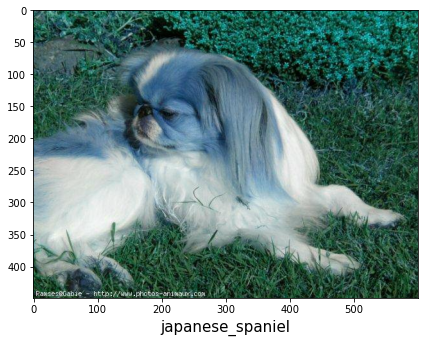

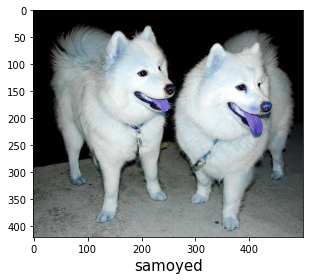

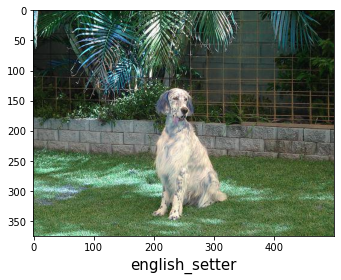

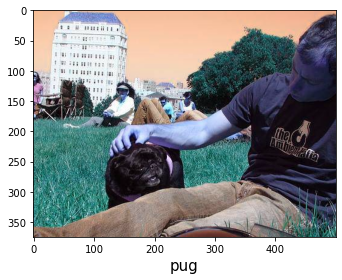

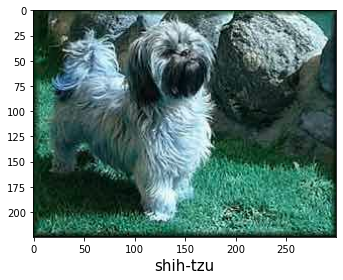

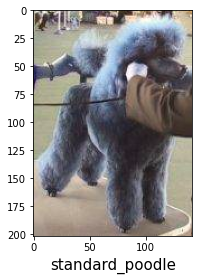

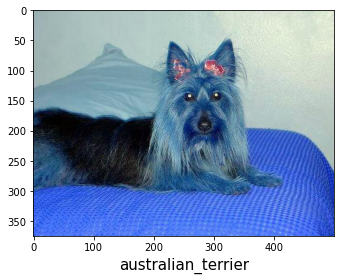

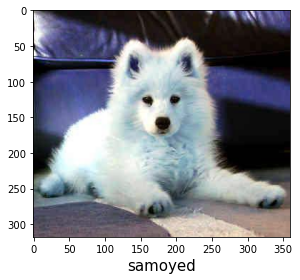

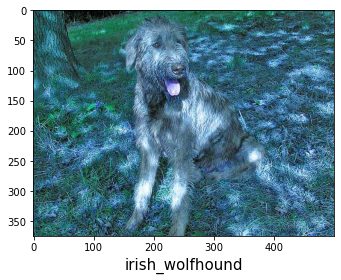

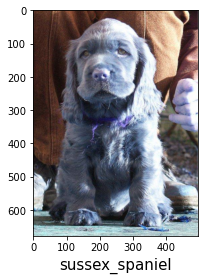

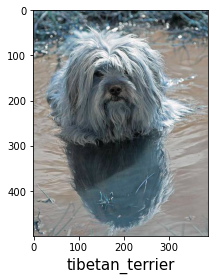

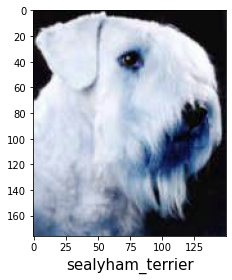

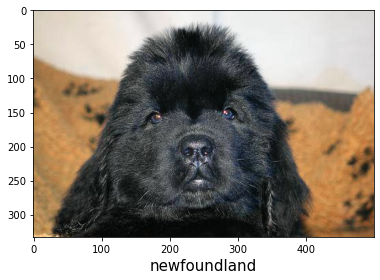

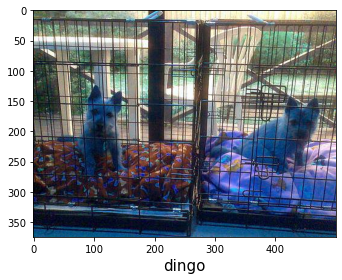

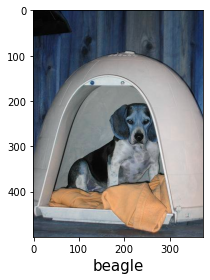

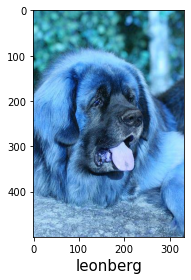

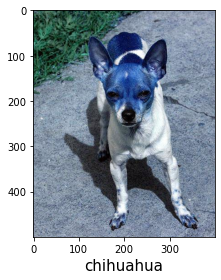

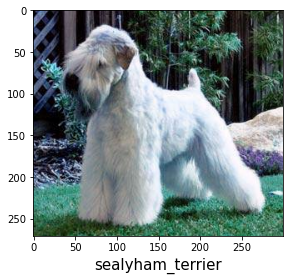

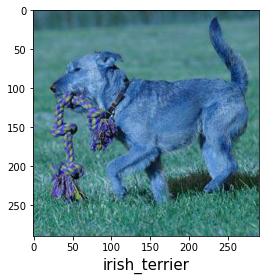

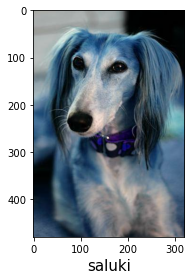

In [ ]:
plt.figure(figsize = (6,6))

for index,data in test_dataframe[:20].iterrows():
    img = data['file_name']
    label = data['breed']
    img = cv2.imread(img)
    plt.imshow(img)
    plt.xlabel(label,fontsize = (15))
    plt.tight_layout()
    plt.show()